# Recommender Systems

# Библиотеки

In [ ]:
pip install implicit

In [ ]:
pip install lightfm

In [ ]:
pip install matplotlib wordcloud

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.6 MB/s eta 0:00:00


In [ ]:
from abc import ABC, abstractmethod
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import geopandas as gpd
from sklearn.utils import shuffle
import re
from lightfm import LightFM
from wordcloud import WordCloud
from lightfm.data import Dataset
import scipy.sparse as sp
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from catboost import CatBoostClassifier

# Данные

В качестве данных будем использовать датасет от MTS.AI: [kion-data](https://arxiv.org/pdf/2209.00325.pdf).  
Это информация о просмотрах пользователей различных фильмов и сериалов с названиями, описаниями и прочими фичами.
**Обратите внимание, что вы можете парсить интернет, для получения дополнительных фичей! Только не забудьте описать, какие фичи вы взяли и где вы их достали!**   
Мы заранее поделили выборки на тренировочную и тестовую части, поэтому **просим** вас придерживаться следующих правил: с тренировочными данными разрешается делать **всё что угодно**, тестовую же часть **запрещается изменять**!  

Датасет представляет из себя 4 файла: тренировочную часть (`train_data.csv`), тестовую часть(`test_data.csv`), описание пользователей(`users.csv`) и описание айтемов(`items_.csv`).

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/ml_hse_1

/content/drive/MyDrive/ml_hse_1


In [ ]:
data_folder = "kion_data/"

users_df = pd.read_csv(data_folder + "users.csv")
items_df = pd.read_csv(data_folder + "items.csv")
train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["last_watch_dt"])
test_part = pd.read_csv(data_folder + "test_data.csv")
test_part = test_part.groupby("user_id").agg({"ground_truth": list}).reset_index()


# Пользователи

In [ ]:
users_df.head()

user_id        age        income sex  kids_flg
0   973171  age_25_34  income_60_90   М         1
1   962099  age_18_24  income_20_40   М         0
2   721985  age_45_54  income_20_40   Ж         0
3   704055  age_35_44  income_60_90   Ж         0
4   846063  age_35_44  income_40_60   Ж         1

In [ ]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366088 entries, 0 to 366087
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   366088 non-null  int64 
 1   age       362506 non-null  object
 2   income    362739 non-null  object
 3   sex       362027 non-null  object
 4   kids_flg  366088 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 14.0+ MB


## Какие есть признаки?

1. `user_id` – индентификатор пользователя, уникален для каждого
2. `age` – категориальный признак, показывающий возрастную группу пользователя
3. `income` – категориальный признак, показывающий зарплатную группу пользователя
4. `sex` – пол пользователя
5. `kids_flg` – наличие детей у пользователя


# Айтемы

In [ ]:
items_df.head(2)

item_id content_type           title      title_orig  release_year  \
0    10711         film  Поговори с ней  Hable con ella        2002.0   
1     2508         film     Голые перцы    Search Party        2014.0   

                                    genres countries  for_kids  age_rating  \
0  драмы, зарубежные, детективы, мелодрамы   Испания       NaN        16.0   
1         зарубежные, приключения, комедии       США       NaN        16.0   

  studios         directors  \
0     NaN  Педро Альмодовар   
1     NaN    Скот Армстронг   

                                              actors  \
0  Адольфо Фернандес, Ана Фернандес, Дарио Гранди...   
1  Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...   

                                         description  \
0  Мелодрама легендарного Педро Альмодовара «Пого...   
1  Уморительная современная комедия на популярную...   

                                            keywords  
0  Поговори, ней, 2002, Испания, друзья, любовь, ...  
1  Голые, перцы, 2014, США, друзья, свадьбы, прео...

## Какие есть признаки?

1. `item_id` – индентификатор айтема, уникален для каждого
2. `content_type` – категориальный признак, тип айтема (фильм, сериал и т.д.)
3. `title` – Название на русском языке
4. `title_orig` – Название на языке оригинала
5. `release_year` – год выхода
6. `genres` – список жанров (представлен строкой)
7. `countries` – страна издания
8. `for_kids` – предназначен для детей
9. `age_rating` – возрастной рейтинг картины
10. `studios` – студия, выпустившая картину
11. `directors` – режиссер(ы)
12. `actors` – актёры
13. `description` – описание (на русском)
14. `keywords` – ключевые слова, описывающие картину


# Просмотры пользователей

### Тренировочные данные

In [ ]:
print(f"Число тренировочных интеракций: {len(train_part):,}")
train_part.head()

Число тренировочных интеракций: 1,224,560


user_id  item_id last_watch_dt  total_dur  watched_pct
0   176549     9506    2021-05-11     4250.0         72.0
1   699317     1659    2021-05-29     8317.0        100.0
2   656683     7107    2021-05-09       10.0          0.0
3   864613     7638    2021-07-05    14483.0        100.0
4   964868     9506    2021-04-30     6725.0        100.0

### Тестовые данные

In [ ]:
print(f"Число тестовых пользователей: {len(test_part):,}")
test_part.head()

Число тестовых пользователей: 18,693


user_id                                  ground_truth
0       30                           [8584, 3031, 15363]
1      144                          [3800, 11987, 10942]
2      241                    [14841, 6162, 5808, 15266]
3      259  [16509, 10509, 4491, 5434, 4471, 10772, 817]
4      475                            [6214, 3734, 6686]

### Обратите внимание, что формат данных тестовой и тренировочной частей отличается.
#### Это сделано для того, чтобы вы могли использовать дополнительную информацию в своих моделях, например такую как время просмотра (`total_dur`), процент просмотра(`watched_pct`), а так же дату последнего просмотра (`last_watch_dt`)
#### При этом на тренировочных данных такой информации нет, так как мы не можем смотреть в будущее.     

#### Тестовые данные также приведены в удобный для подсчета метрик вид.

# Метрики

#### Кратко расскажем про метрики, которые мы будем использовать для измерения качества наших моделей.  

Мы будем смотреть всего на две метрики: **ndcg** и **recall**.  
Все метрики измеряются до какой-то позиции, у нас это будет **10**. То есть мы отдаем 10 самых подходящих пользователю айтемов по мнению модели и говорим, что это и есть наши рекомендации, качество которых мы хотим оценить.  

**ndcg** показывает, как модель справляется с задачей ранжирования, то есть ставит просмотренные айтемы выше непросмотренных
**recall** показывает, как много релевантных айтемов модель выдаёт в топе (смысл как в задаче классификации)

*Для обоих метрик лучше та, которая как можно ближе к **1.0***

Не бойтесь, если вам сейчас что-то непонятно, подробнее про метрики мы расскажем на смене или можете почитать в интернете:)

#### Ниже представлен код реализации, пожалуйста, не меняйте его!

In [ ]:
# ACHTUNG! DO NOT TOUCH

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "ground_truth") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

#### Класс, от которого стоит наследовать все ваши модели, чтобы эксперименты было проще проводить

In [ ]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений

        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращать список массивов из item_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

### Перейдем к моделям, начнем с супер простого подхода – давайте всем рекомендовать топ популярных (по числу просмотров) айтемов

# Baseline #1 – Топ Популярных

In [ ]:
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "item_id") -> None:
        # считаем популярность айтемов
        self.recommendations = df[item_id_col].value_counts().index.values
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train_part)
test_part["toppopular_recs"] = toppop.predict(test_part)
test_part.head()

user_id                                  ground_truth  \
0       30                           [8584, 3031, 15363]   
1      144                          [3800, 11987, 10942]   
2      241                    [14841, 6162, 5808, 15266]   
3      259  [16509, 10509, 4491, 5434, 4471, 10772, 817]   
4      475                            [6214, 3734, 6686]   

                                     toppopular_recs  
0  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...  
1  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...  
2  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...  
3  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...  
4  [10440, 15297, 13865, 9728, 4151, 2657, 3734, ...

##### Посмотрим на метрики, для этого передаем тестовый датафрейм и колонку с предсказаниями, в нашем случае это `toppopular_recs`  

In [ ]:
evaluate_recommender(df=test_part, model_preds_col="toppopular_recs")


{'ndcg': 0.17037237918248196, 'recall': 0.0763696799665908}

#### Не пугайтесь таких маленьких значений, в RecSys задачах часто очень тяжело подстроиться под данные, поэтому абсолютные значения невелики. Чтобы по-настоящему оценить качество вашей модели, нужно сранвить ее с каким-то простым решением, которое можно считать отправной точкой. Наш бейзлайн с популярными фильмами как раз подходит!

### Теперь возьмем подход посложнее, уже математически подкованный
Мы можем представить просмотры пользователей, как матрицу, где по столбцам будут отложены айтемы, а по строкам – пользователи. В `[i,j]` ячейке будет стоять 1, если пользователь смотрел фильм/сериал и 0, если нет.  
Тогда нашей задачей будет разложить исходную матрицу на две: матрицу пользователей и матрицу айтемов, перемножив которые, мы бы максимально приблизили известные нам единички.
Такой подход позволит нам заполнить все пропуски в нашей матрице, то есть все нули.

Для этого метода будем использовать модель **Alternating Least Squares (ALS)**. Она оптимизирует наши матрицы таким образом, чтобы мы хорошо восстанавливали все единички.
Подробнее про модель можно почитать в [документации](https://benfred.github.io/implicit/), или, например, [тут](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe), или как всегда – в интернете.

# Baseline #2 – Матричное разложение

In [ ]:
class ALS(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(
        self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs
    ) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(
            factors=factors, regularization=regularization, alpha=alpha, iterations=iterations, **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [ ]:
als_rec = ALS(iterations=1, factors=2, random_state=42)
als_rec.fit(train_part)
test_part["als_recs"] = als_rec.predict(test_part)


  0%|          | 0/1 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

#### Снова считаем метрики

In [ ]:
evaluate_recommender(test_part, model_preds_col="als_recs")


{'ndcg': 0.15702657768326359, 'recall': 0.06956445160783432}

### Ой-ой, кажется, что качество стало хуже, чем у популярных фильмов. Возможно мы плохо обучили модель, не самым правильным образом обработали данные, или она просто не подходит для этих данных, в любом случае, вам предстоит узнать можно ли обогнать `toppop` на данном датасете.

## Сделаем небольшой EDA наших предсказаний от ALS.

### Посмотрим, что наш алгоритм чаще всего рекомендует первым делом:

In [ ]:
def plot_first_items(test_part: pd.DataFrame, items_df: pd.DataFrame, rec_type:str):
    first_items = pd.DataFrame([x[0] for x in test_part[rec_type].values], columns=["item_id"])
    first_items = ( first_items.merge(items_df[["item_id", "title"]], on="item_id").groupby("title").size().sort_values(ascending=False)
    )
    first_items /= first_items.sum()
    first_items.head(10).plot(kind="bar")
    plt.ylabel("Доля от всех рекомендаций")
    plt.title("Распределение фильмов на первых местах")
    plt.show()


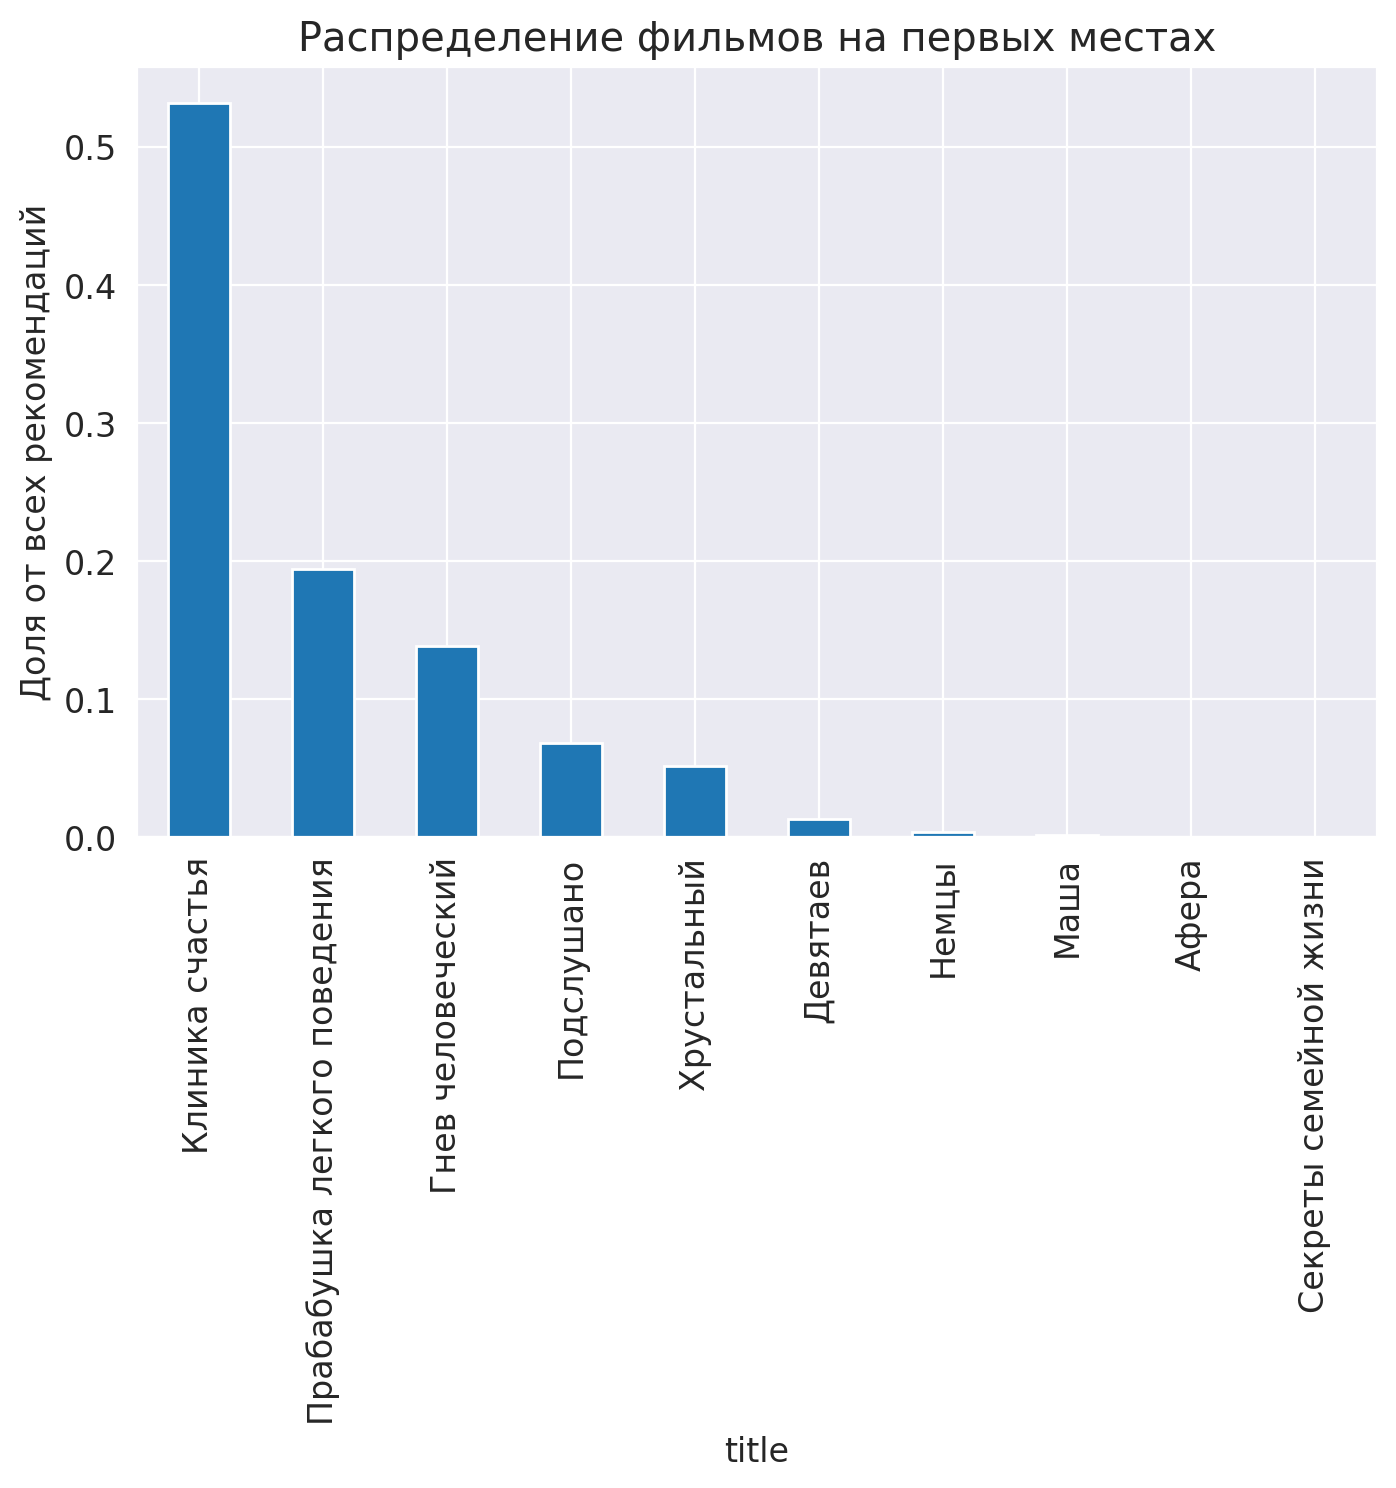

In [ ]:
plot_first_items(test_part, items_df, 'als_recs')

#### Посмотрим на похожие фильмы к фильму "Гнев человеческий", согласно als

In [ ]:
items_df[items_df["title"] == 'Гнев человеческий']


item_id content_type              title    title_orig  release_year  \
4809     9728         film  Гнев человеческий  Wrath of Man        2021.0   

                 genres            countries  for_kids  age_rating studios  \
4809  боевики, триллеры  Великобритания, США       NaN        18.0     NaN   

     directors                                             actors  \
4809  Гай Ричи  Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...   

                                            description  \
4809  Грузовики лос-анджелесской инкассаторской комп...   

                                               keywords  
4809  ограбление, криминальный авторитет, месть, пер...

In [ ]:
def get_similar_films(title, used_model, N=10):
    item_id = items_df[items_df["title"] == title]['item_id'].values[0]

    similar_encoded_ids = used_model.model.similar_items(
        used_model.item_encoder.transform([item_id]), N=N, filter_items=used_model.item_encoder.transform([item_id])
    )[0][0]
    similar_ids = used_model.item_encoder.inverse_transform(similar_encoded_ids)
    return items_df[items_df["item_id"].isin(similar_ids)][["content_type", "title", "release_year", "genres","countries", "directors", "age_rating"]]

In [ ]:
get_similar_films("Гнев человеческий", als_rec)

content_type                      title  release_year  \
1120          film         Мертвые не умирают        2019.0   
3710          film              Голос мастера        2013.0   
4070          film                     Тренер        2018.0   
4509          film               Юность Петра        1980.0   
6013          film          Отстреливая собак        2005.0   
6284          film  Вселенная Стивена Хокинга        2014.0   
6589          film         Алиса в Зазеркалье        2016.0   
10036       series       Убийство на Мидл Бич        2020.0   
10293       series                Потрепанные        2019.0   
10338         film                   Всё могу        2015.0   

                                         genres                    countries  \
1120                 фантастика, ужасы, комедии             США, Швеция, ЮАР   
3710                             драмы, комедии       Франция, США, Бразилия   
4070                               драмы, спорт                       Россия   
4509             драмы, биография, историческое                         СССР   
6013   драмы, зарубежные, исторические, военные               Великобритания   
6284                драмы, биография, мелодрамы  Великобритания, США, Япония   
6589             семейное, фэнтези, приключения          США, Великобритания   
10036                            документальное                          США   
10293                            драмы, комедии               Великобритания   
10338                       фантастика, комедии               Великобритания   

                directors  age_rating  
1120         Джим Джармуш        18.0  
3710      Гильерме Маконд        12.0  
4070    Данила Козловский        12.0  
4509     Сергей Герасимов        12.0  
6013   Майкл Кейтон-Джонс        12.0  
6284          Джеймс Марш        16.0  
6589         Джеймс Бобин        12.0  
10036                 NaN        18.0  
10293          Шон Уилсон        18.0  
10338         Терри Джонс        16.0

In [ ]:
get_similar_films("Ральф против Интернета", als_rec)

content_type                                           title  \
215           film  [4К] Наветренные острова – жемчужина Полинезии   
376           film                     Внимание: смертельно опасно   
2588          film                  Дневники шаловливых подростков   
3602          film                                 Безумная любовь   
6001        series                                    Я тебя слышу   
7729          film                              Омен: Перерождение   
7920        series                                  Садовое кольцо   
8482        series                            Великий соблазнитель   
9802          film                              37°4’ южной широты   
10456       series                                       Октонавты   

       release_year                                             genres  \
215          2020.0                                     документальное   
376          2017.0                         фильмы hbo, документальное   
2588         2018.0                                       для взрослых   
3602         1935.0           фантастика, ужасы, зарубежные, мелодрамы   
6001         2013.0          фантастика, мелодрамы, детективы, комедии   
7729         2019.0               мистика, триллеры, зарубежные, ужасы   
7920         2016.0                                          детективы   
8482         2018.0               дорамы, драмы, зарубежные, мелодрамы   
9802         2013.0                                   драмы, мелодрамы   
10456        2010.0  для детей, сериалы, приключения, зарубежные, с...   

              countries                     directors  age_rating  
215             Франция                Оливье Шиабоду        12.0  
376                 США                   Пэрри Пелтц        16.0  
2588              Чехия               Денис Франческо        21.0  
3602                США                   Карл Фройнд        16.0  
6001   Республика Корея                     Чо Су-вон        16.0  
7729                США              Николас МакКарти        18.0  
7920             Россия               Алексей Смирнов        16.0  
8482   Республика Корея            Кан Ин, Ли Дон-хён        16.0  
9802            Франция               Адриано Валерио        12.0  
10456               США  Дарра О’Коннелл, Никки Фелан         0.0

#### Получается, что "Гнев человеческий" и "Алиса в Зазеркалье" довольно близки.... возможно, возможно

# EDA : фильмы

In [ ]:
import seaborn as sns

In [ ]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

In [ ]:
items_df.sample()

item_id content_type   title      title_orig  release_year  \
9672     5362         film  Основы  The Essentials        2013.0   

                                       genres countries  for_kids  age_rating  \
9672  драмы, зарубежные, приключения, комедии       США       NaN        16.0   

     studios directors    actors  \
9672     NaN       NaN  Йен Уитт   

                                            description  \
9672  Пожилой мужчина по имени Джим – неудачливый со...   

                                               keywords  
9672  Основы, 2013, США, наркотики, неудачники, нови...

Я заранее посмотрела, где есть пропуски и обрабатывать их буду лишь в нужных столбцах:

In [ ]:
items_df.isna().sum()

item_id             0
content_type        0
title               0
title_orig       2923
release_year       48
genres              0
countries          16
for_kids        11539
age_rating          1
studios         11318
directors         907
actors           1799
description         1
keywords          362
dtype: int64

#### Тип контента

Есть фильмы и есть сериалы, фильмов гораздо больше

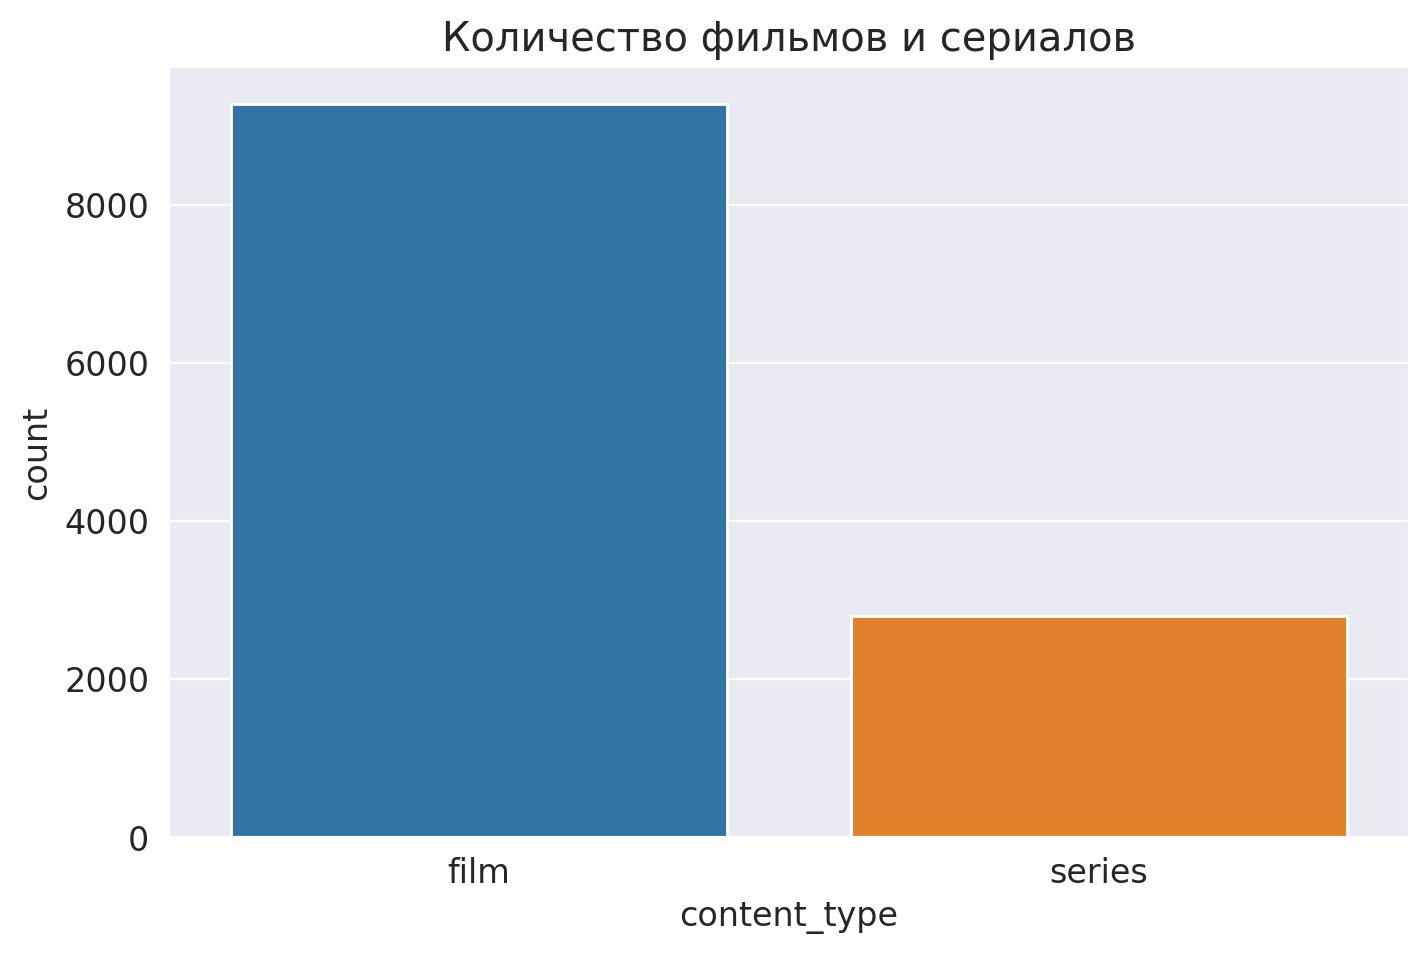

In [ ]:
sns.countplot(x= items_df["content_type"])
plt.title("Количество фильмов и сериалов")
plt.show()

In [ ]:
items_df.item_id.isna().sum()

0

#### Заголовок: NLP to-do

почистить слова "тест", 4к full version

#### Оригинальный заголовок

NAN : title_orig       2923

Видим, что почти все NaN в названии - это фильмы русские/украинские/из СССР. Поэтому заменим их названиями на русском:

In [ ]:
no_title = items_df.loc[items_df.title_orig.isna()]

In [ ]:
len(no_title[no_title["countries"] == "Россия"]) + len(no_title[no_title["countries"] == "СССР"]) + len(no_title[(no_title["countries"] == "Украина")])

2470

In [ ]:
items_df['title_orig'] = items_df['title_orig'].fillna(items_df['title'])

Также переведем все заголовки в нижний регистр

In [ ]:
items_df['title_orig'] = items_df['title_orig'].str.lower()

Обнаруживаем, что очень много заголовков совпадают! Уникальных лишь:

In [ ]:
items_df["title_orig"].nunique() / len(items_df)

0.9565757851993039

In [ ]:
items_df[["genres","title_orig"]].groupby("title_orig").count().sort_values(by="genres", ascending=False)[:3]

genres
title_orig          
pet sematary       4
star trek          3
rocketman          3

Значить же это может несколько вещей. Либо фильм дублируется, либо было снято несколько версий разными режиссерами.

Нужно убрать фильмы, у которых совпадает год и название. Нужно придумать, как совместить описание, студию, просмотры зрителей и тп

In [ ]:
items_df[items_df["title_orig"] == "rocketman"]

item_id content_type                              title title_orig  \
4597    14230         film       Рокетмен. Расширенная версия  rocketman   
5036    16181         film      Рокетмен (расширенная версия)  rocketman   
8099    11004         film  [4k] Рокетмен. Расширенная версия  rocketman   

      release_year                                             genres  \
4597        2019.0  биография, музыкальные, драмы, зарубежные, мюз...   
5036        2019.0                                              драмы   
8099        2019.0  биография, музыкальные, драмы, зарубежные, мюз...   

                        countries  for_kids  age_rating    studios  \
4597               Великобритания       NaN        18.0  Paramount   
5036  Великобритания, США, Канада       NaN        18.0        NaN   
8099               Великобритания       NaN        18.0  Paramount   

            directors                                             actors  \
4597  Декстер Флетчер  Брайс Даллас Ховард, Джейми Белл, Джейсон Пенн...   
5036  Декстер Флетчер  Брайс Даллас Ховард, Тейт Донован, Тэрон Эджер...   
8099  Декстер Флетчер  Брайс Даллас Ховард, Джейми Белл, Джейсон Пенн...   

                                            description  \
4597  Смотрите расширенную версию фильма на ivi! Ист...   
5036  Усталый мужчина средних лет (Тэрон Эджертон), ...   
8099  Смотрите в 4К! История бурной молодости одного...   

                                               keywords  
4597  Рокетмен, Расширенная, версия, 2019, Великобри...  
5036  лондон, англия, наркомания, 1970-е, поп-звезда...  
8099  4k, Рокетмен, Расширенная, версия, 2019, Велик...

#### Год выпуска

Как видно, почти все фильмы вышли в 2010-2020 годах. До 2000 на каждый год приходится небольшое количество фильмов, поэтому можно будет попробовать их  сгруппировать по десятилетиям или более крупным интервалам и посмотреть, что работает лучше

In [ ]:
series_year_groupby = items_df[items_df["content_type"] == "series"][["item_id","release_year"]].groupby(["release_year"]).count()
films_year_groupby = items_df[items_df["content_type"] == "film"][["item_id","release_year"]].groupby(["release_year"]).count()

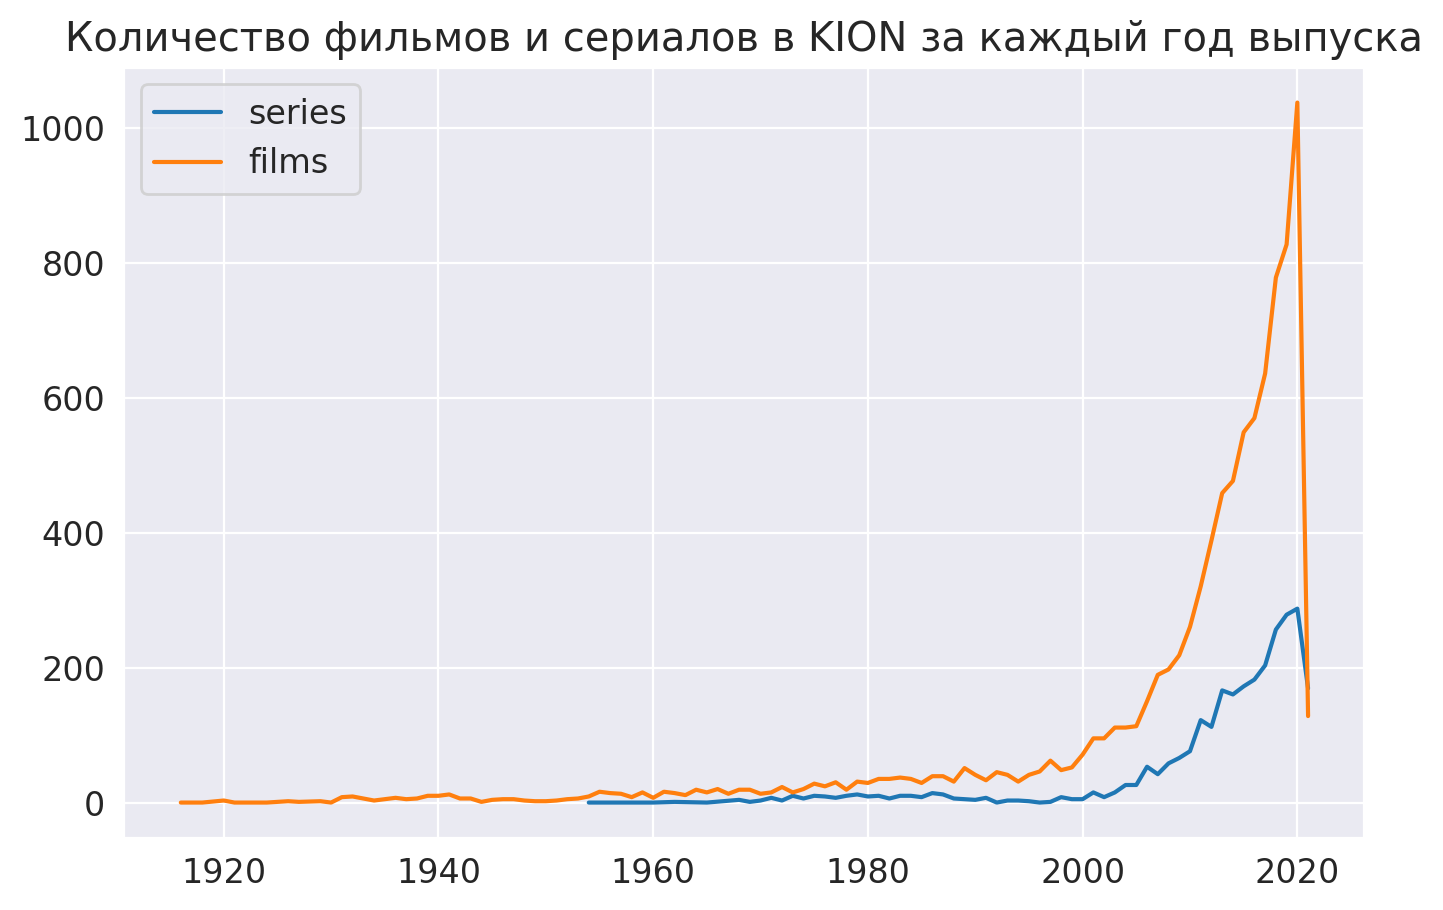

In [ ]:
fig, axs = plt.subplots(ncols=1)
plt.plot(series_year_groupby, label="series")
plt.plot(films_year_groupby, label="films")
plt.legend(loc="upper left")
plt.title('Количество фильмов и сериалов в KION за каждый год выпуска')
plt.show()

По объектам, где не указан год, видно, что они выпущены совсем недавно, поэтому логично будет их заполнить 2020 или 2021 годом. В ключевых словах там чаще встречается 2021, поэтому я выберу его

In [ ]:
no_year = items_df.loc[items_df.release_year.isna()]

In [ ]:
items_df['release_year'] = items_df['release_year'].fillna(2021)

Теперь пришло время добавить новый признак: сделать год категориальным. В дальнейшем посмотрим, как модель работает с категориями и с просто годами, и выберем, что дает лучший результат

Я сгруппирую так: 1916-1979,1980-1999, 2000-2010, 2011-2017, 2018-2021. Так в каждой группе будет достаточное число фильмов.

In [ ]:
bins = [1916, 1980, 2000, 2011, 2018, 2022]
labels = ['20-70s', '80-90s', '00s', '10s', '20s']
items_df['release_year_category'] = pd.cut(items_df['release_year'], bins=bins, labels=labels, right=False)

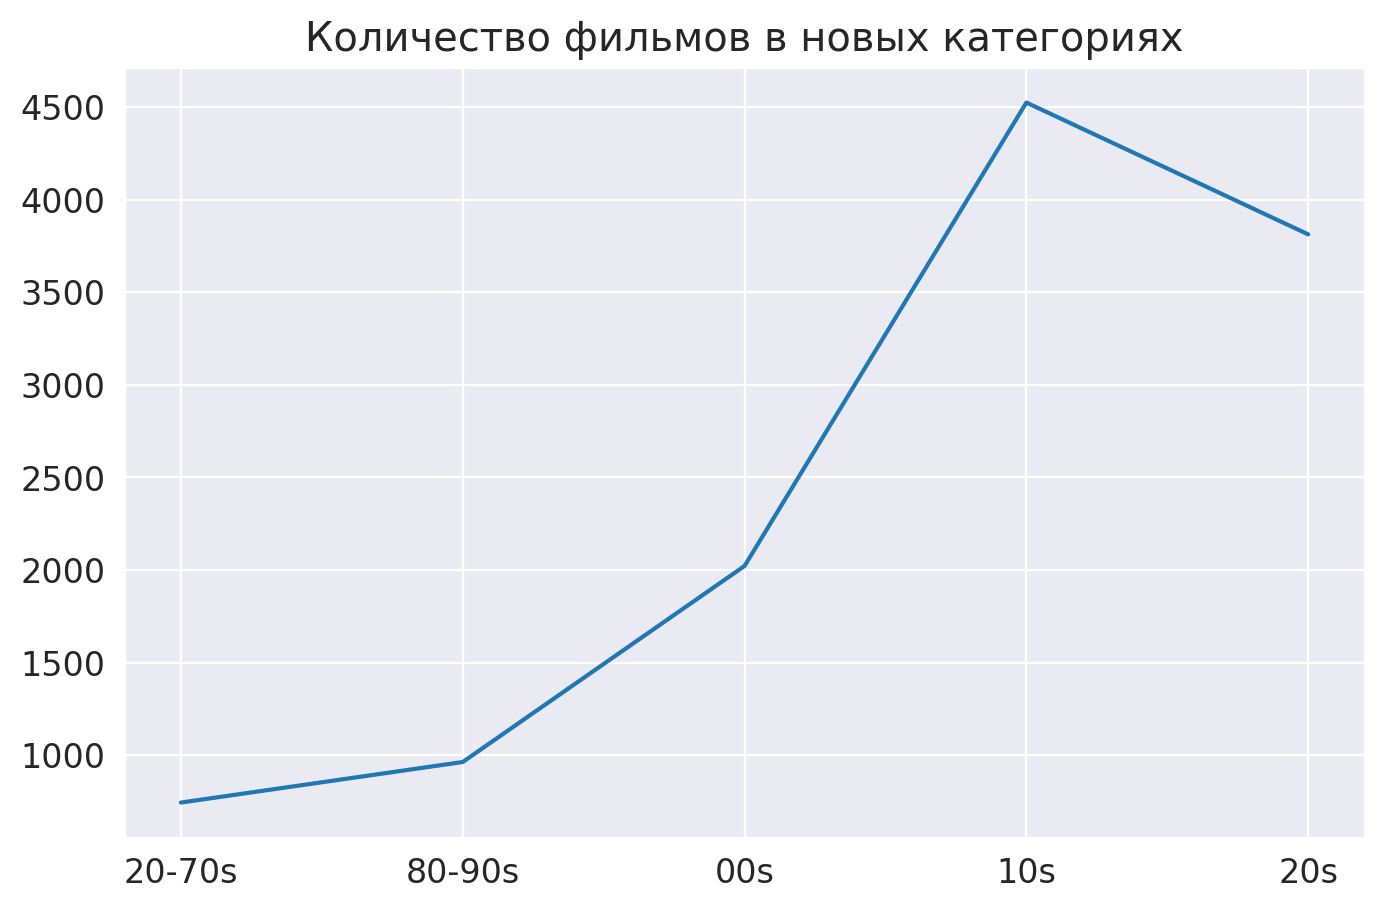

In [ ]:
plt.plot(items_df.release_year_category.value_counts().loc[labels])
plt.title("Количество фильмов в новых категориях")
plt.show()

#### Жанры

In [ ]:
items_df["genres"].describe()

count              12067
unique              2312
top       документальное
freq                 651
Name: genres, dtype: object

распарсим жанры???

#### Страны производства

In [ ]:
items_df["countries"].describe()

count     12051
unique      636
top         США
freq       3370
Name: countries, dtype: object

Видим, что большинство фильмов из США или России

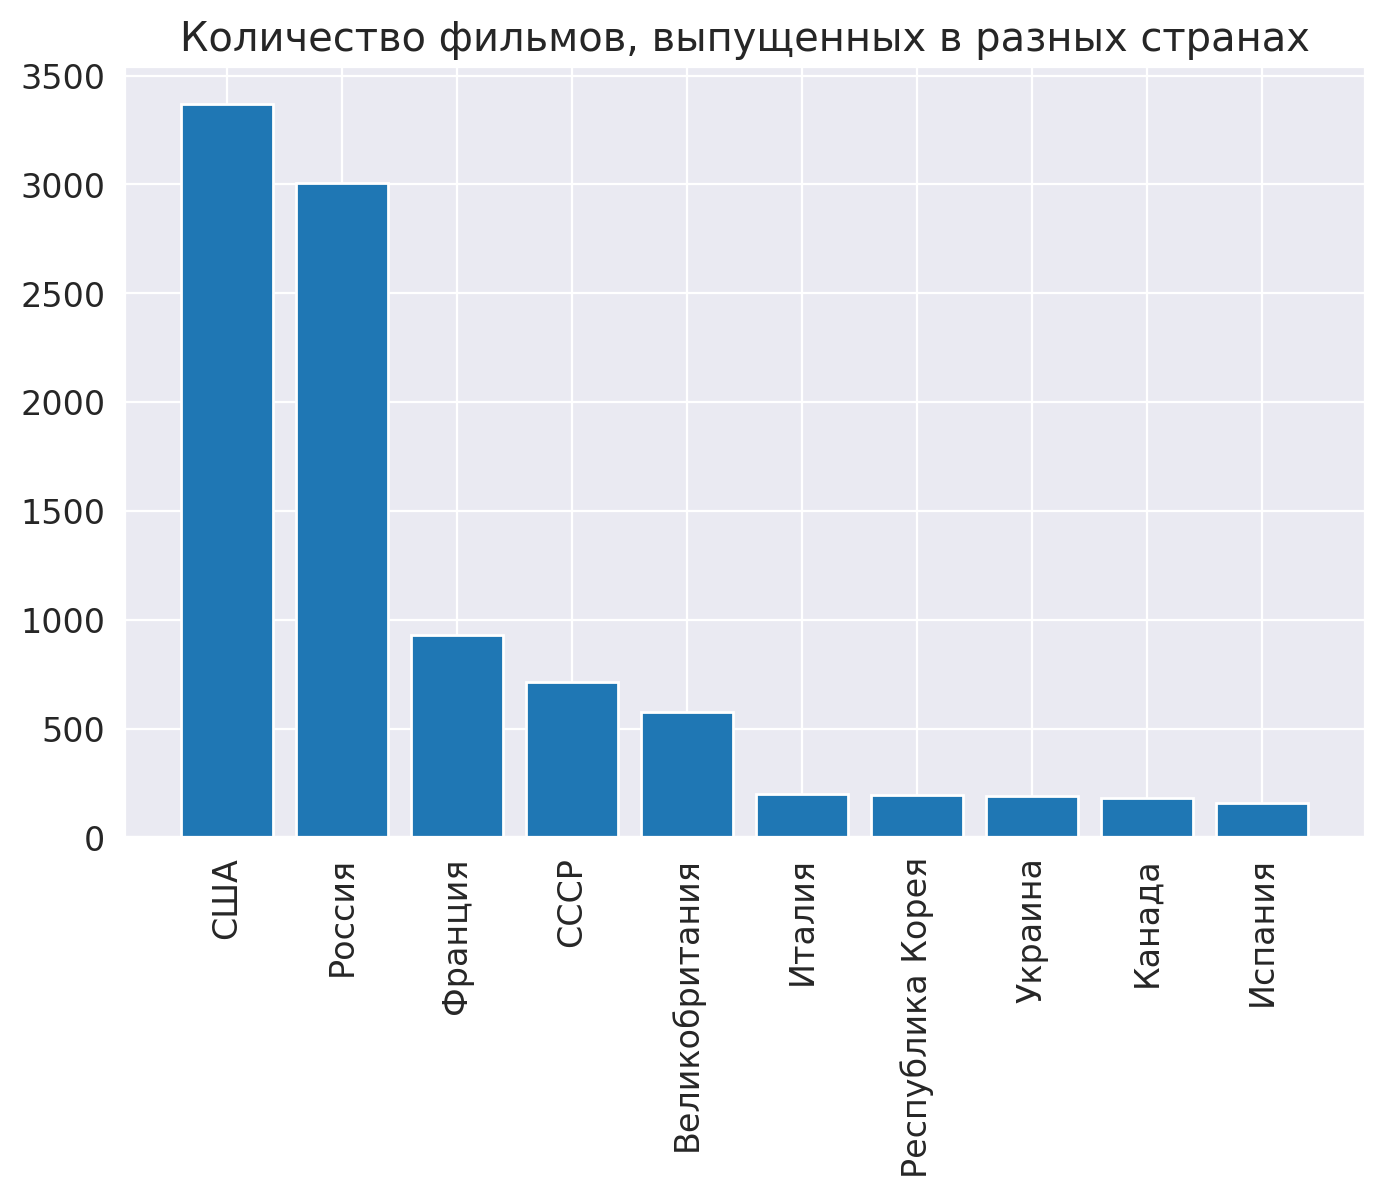

In [ ]:
plt.bar(x = items_df.countries.value_counts()[:10].index, height = items_df.countries.value_counts()[:10].values)
plt.title("Количество фильмов, выпущенных в разных странах")
plt.xticks(rotation=90)
plt.show()

Теперь заполним пропуски, их немного:
У 1 фильма было явно написано, что он российский. Про остальные было непонятно, поэтому они были причислены к США (в некоторых встречались английские фамилии)

In [ ]:
items_df.loc[items_df["title"] == "Тайная комната", "countries"] = "Россия"
items_df['countries'] = items_df['countries'].fillna("США")

#### For kids

Как видно, этот признак пока что плохо размечен: примерно 4% не NaN. Однако информация о том, что фильм предназначен для детей, может быть ценной. Следующий признак - возрастная маркировка - размечен гораздо лучше, и мне кажется, признак for kids можно выбросить/разметить по возрастной маркировке

In [ ]:
(items_df["for_kids"].value_counts().sum())/len(items_df)

0.04375569735642662

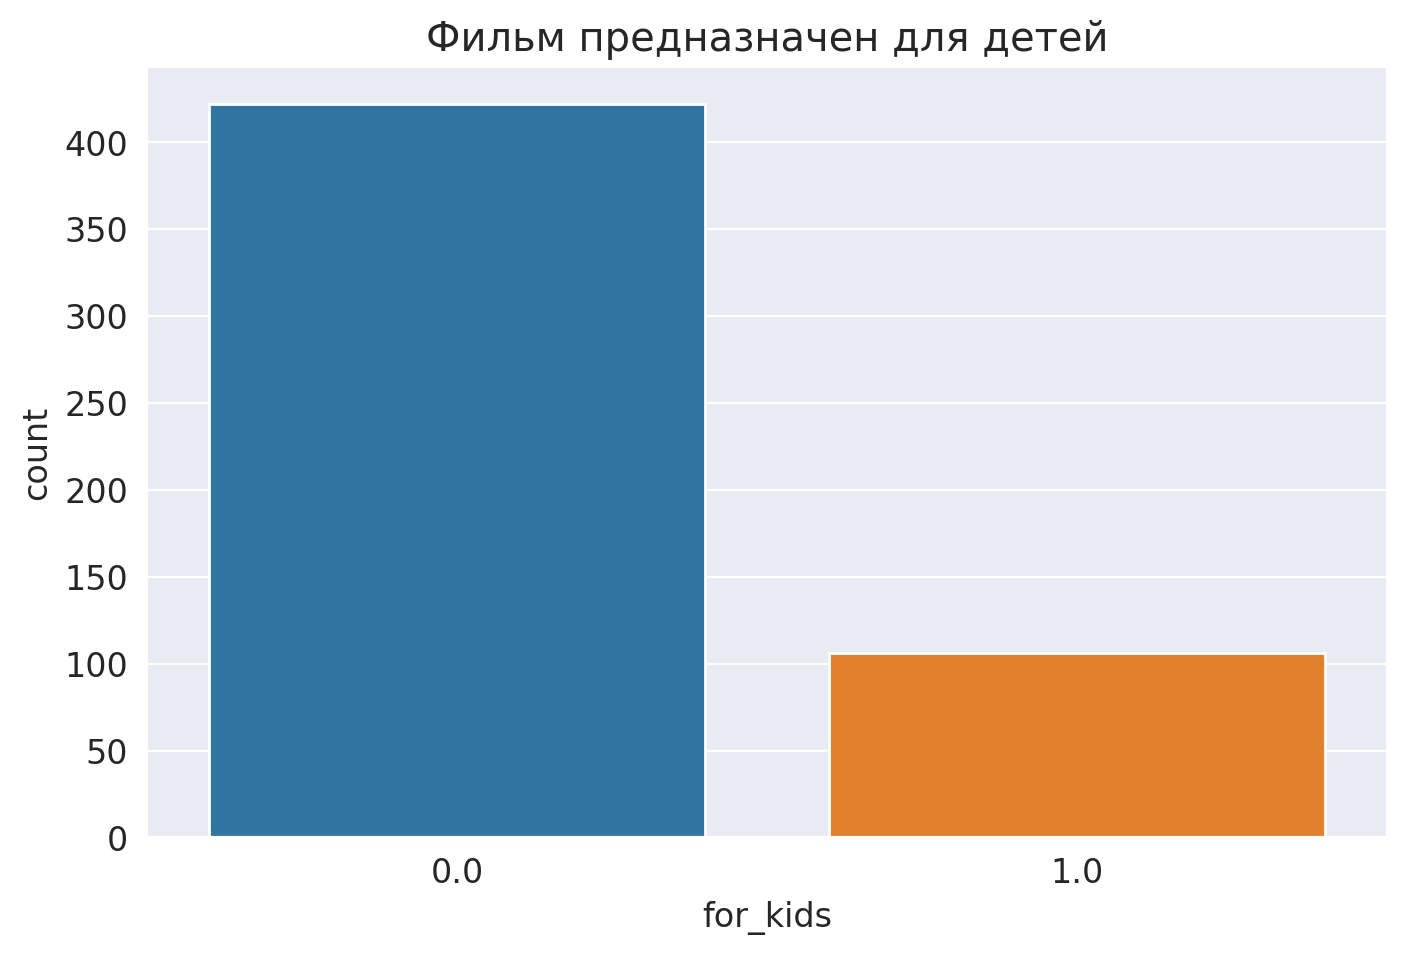

In [ ]:
sns.countplot(x=items_df["for_kids"])
plt.title("Фильм предназначен для детей")
plt.show()

#### Age Rating

Видим, что большинство фильмов рассчитаны на аудиторию 16+

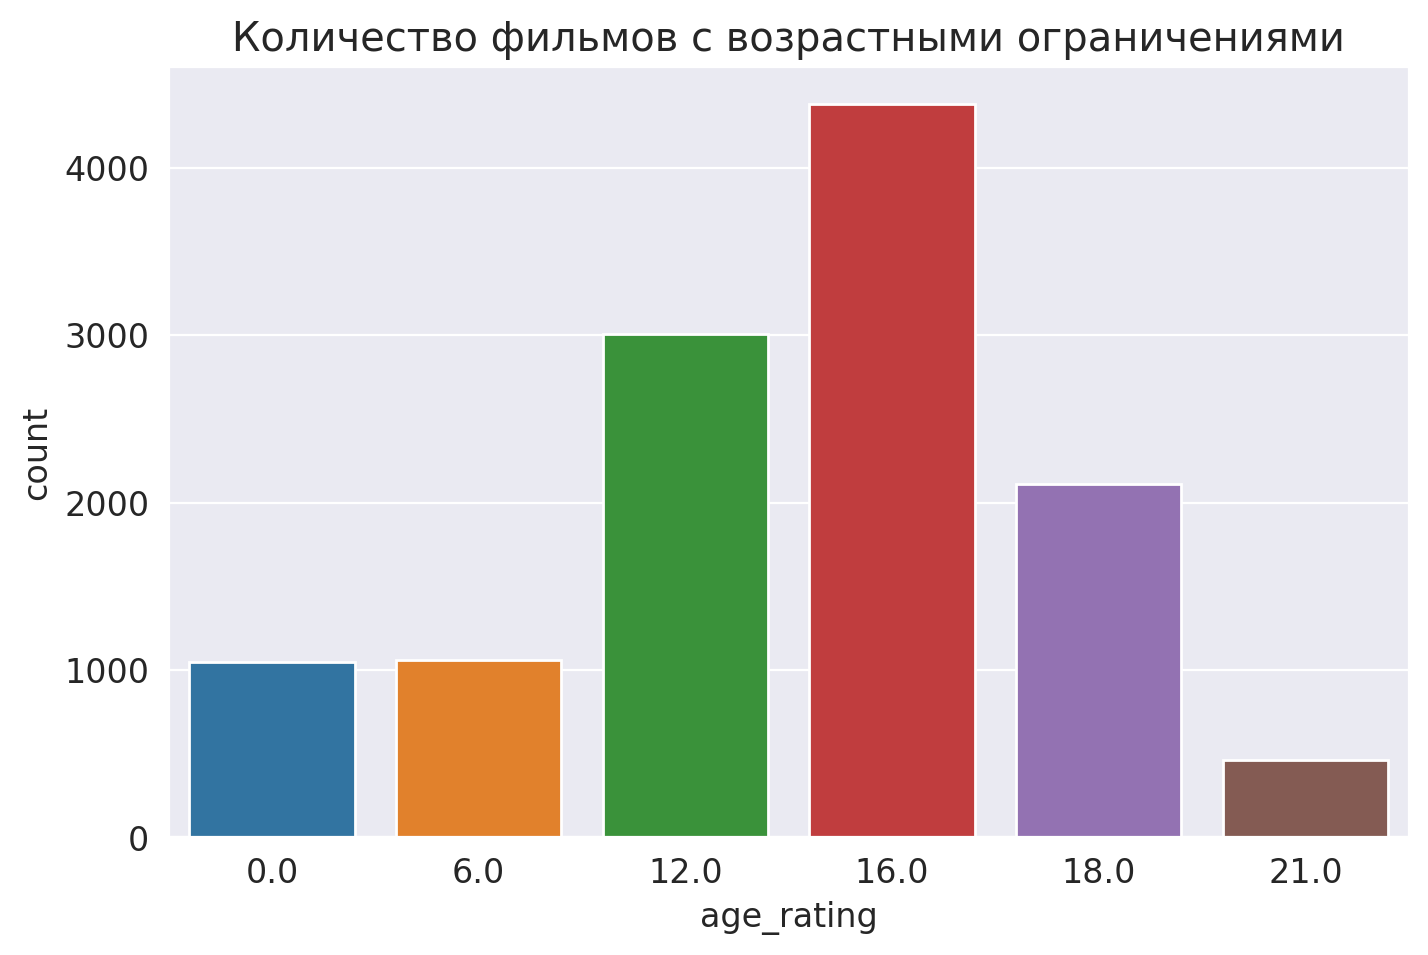

In [ ]:
sns.countplot(x=items_df["age_rating"])
plt.title("Количество фильмов с возрастными ограничениями")
plt.show()

В данных лишь 1 пропуск, как видно, это фильм для детей:

In [ ]:
items_df.loc[items_df.age_rating.isna()]

item_id content_type   title title_orig  release_year  \
9366    14409       series  БиБаБу     бибабу        2017.0   

                                                 genres countries  for_kids  \
9366  русские, сериалы, для детей, хочу всё знать, р...    Россия       NaN   

      age_rating studios directors actors  \
9366         NaN     NaN       NaN    NaN   

                                            description  \
9366  В сказочное подводное царство приглашают мален...   

                                               keywords release_year_category  
9366  друзья, магия и волшебство, рыбы, моря и океан...                   10s

In [ ]:
items_df.age_rating = items_df.age_rating.fillna(0)

#### Studios

Студии размечены очень плохо, поэтому создадим для nan отдельную категорию "без студии"

In [ ]:
items_df["studios"].describe()

count     749
unique     37
top       HBO
freq      243
Name: studios, dtype: object

In [ ]:
items_df["studios"] = items_df["studios"].fillna("no_studio")

#### Directors

Изучим список режиссеров:

In [ ]:
items_df["directors"].describe()

count              11160
unique              6576
top       Оливье Шиабоду
freq                 402
Name: directors, dtype: object

Nan тоже много, поэтому создадим отдельну категорию no_director

In [ ]:
items_df["directors"] = items_df["directors"].fillna("no director")

In [ ]:
top_directors = items_df[["genres","directors"]].groupby("directors").count().sort_values(by="genres", ascending=False)[1:6]

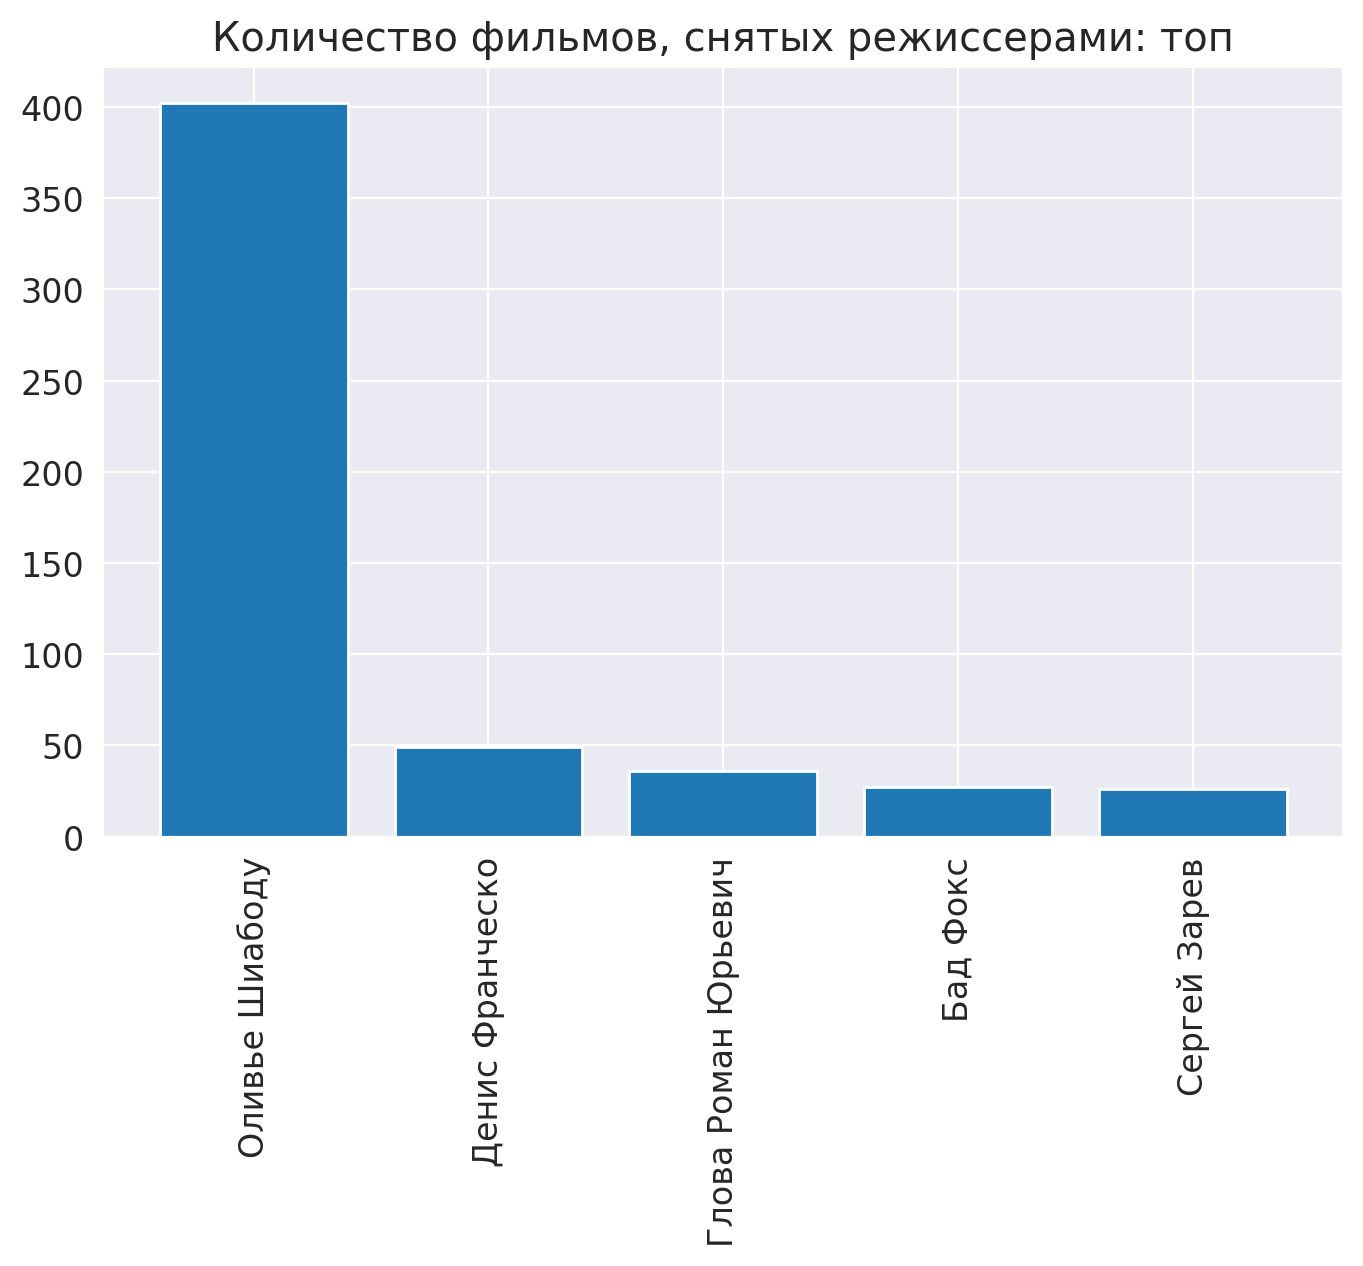

In [ ]:
plt.bar(x = top_directors.index, height = top_directors.genres)
plt.title("Количество фильмов, снятых режиссерами: топ")
plt.xticks(rotation=90)
plt.show()

Что-то выглядит не так с Оливье Шиабоду. И действительно, если посчитать уникальные заголовки у его фильмов, их количество упадет почти в два раза

In [ ]:
items_df[items_df["directors"]== "Оливье Шиабоду"]["title_orig"].nunique()

245

#### Actors

In [ ]:
items_df["actors"].describe()

count                 10268
unique                10039
top       Александр Клюквин
freq                     18
Name: actors, dtype: object

В пропуски опять запишем "no actors"

In [ ]:
items_df.actors = items_df.actors.fillna("no actors")

#### Descriptions

Для начала проверим аномалии в описаниях. Видно, какие-то серии видео. Даже хорошо, что у них совпадают описания.

In [ ]:
items_df[["genres","description"]].groupby("description").count().sort_values(by="genres", ascending=False)[:3]

genres
description                                               
МТС «Карантинники» — это домашние акустические ...      36
Лига чемпионов AFC - это главный клубный футбол...      15
Шестисерийный фильм, снятый формате 4К в Северн...       6

Заполним nan пустой строкой.

In [ ]:
items_df.description = items_df.description.fillna("")

#### Key words

Пока что заполним пропуски годом и страной (что обычно встречается в ключевых словах)  

In [ ]:
items_df["keywords"] = items_df["keywords"].fillna(items_df["release_year"].astype(int).astype(str) + ", " + items_df["countries"])

#### Итог по датасету: все пропуски заполнены

In [ ]:
items_df.drop(columns="for_kids", inplace=True)

In [ ]:
items_df.isna().sum()

item_id                  0
content_type             0
title                    0
title_orig               0
release_year             0
genres                   0
countries                0
age_rating               0
studios                  0
directors                0
actors                   0
description              0
keywords                 0
release_year_category    0
dtype: int64

In [ ]:
#for col in ['genres', 'authors', 'year']:
#    df_items[col] = df_items[col].astype('category')

# EDA: пользователи

In [ ]:
users_df.sample()

user_id        age        income sex  kids_flg
7608   241257  age_18_24  income_40_60   М         0

Продолжим исследовать данные и заполнять пропуски

In [ ]:
users_df.isna().sum()

user_id        0
age         3582
income      3349
sex         4061
kids_flg       0
dtype: int64

#### AGE

Как видно, большинство пользователей достаточно молоды: их возраст 25-44

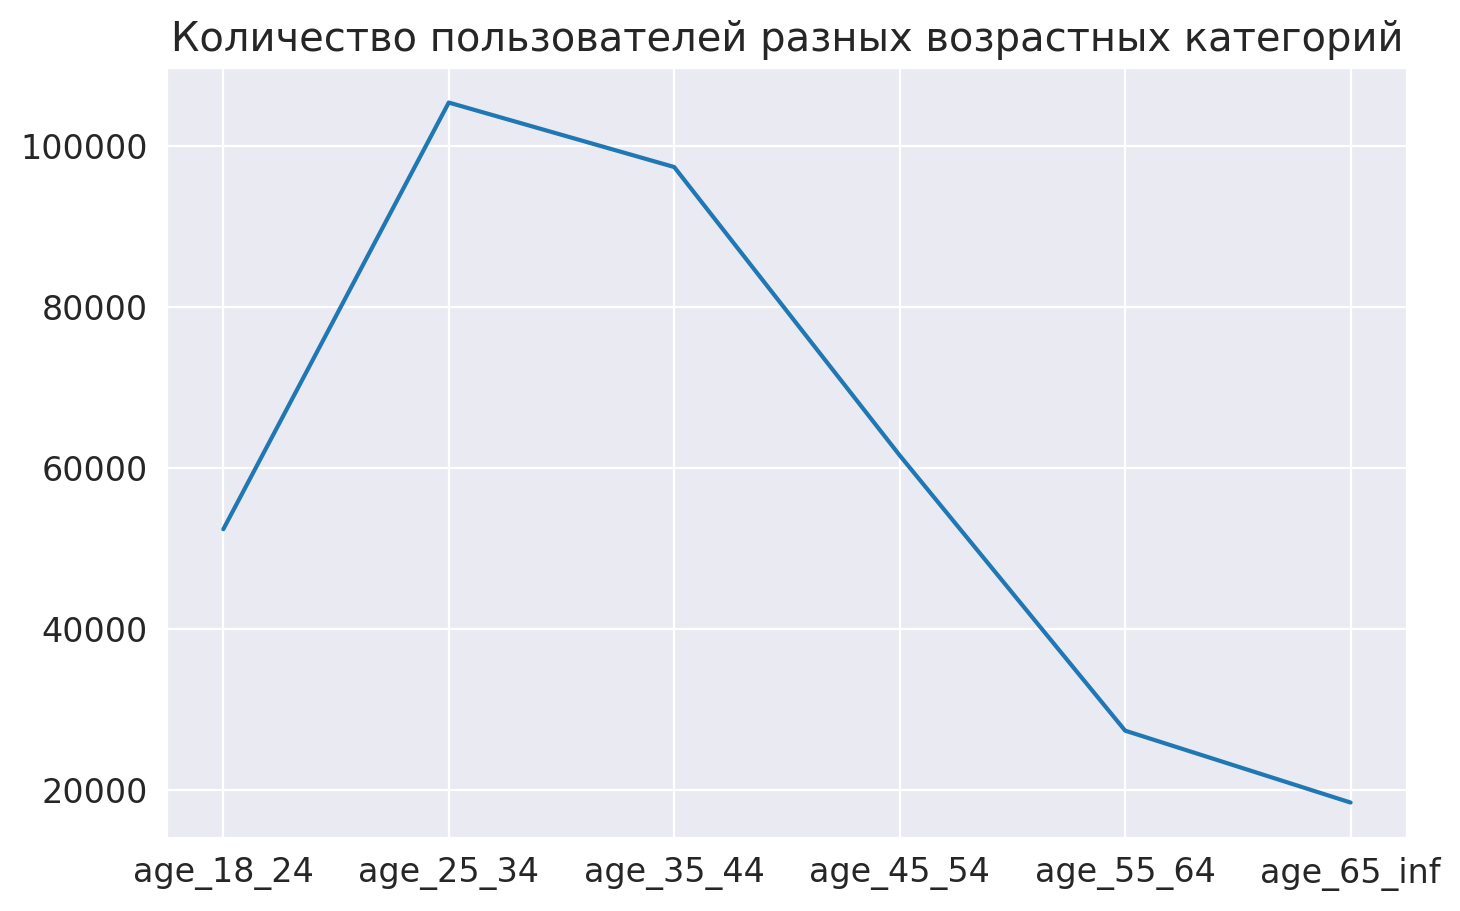

In [ ]:
plt.plot(users_df["age"].value_counts().sort_index())
plt.title('Количество пользователей разных возрастных категорий')
plt.show()

Почти всегда если пропущен возраст, то пропущен и доход. И нет вообще никакой информации, кроме id. Таких профилей всего 3200, то есть чуть меньше 1% от всех пользователей. Попробую создать с ними отдельную группу, если это покажет плохой результат, причислю их к самой большой группе

In [ ]:
condition = users_df.age.isna() & users_df.income.isna()
users_df.loc[condition, "age"] = "age_unknown"
users_df.loc[condition, "income"] = "income_unknown"

Рассмотрим оставшуюся часть пользователей, у которых пропущен возраст, но остался уровень дохода. Заполним их самым вероятным возрастом для их уровня дохода, а потом аналогично попробуем восстановить уровень дохода по возрасту

In [ ]:
income_to_age = users_df[["income", "age", "user_id"]].groupby(["income", "age"]).count()

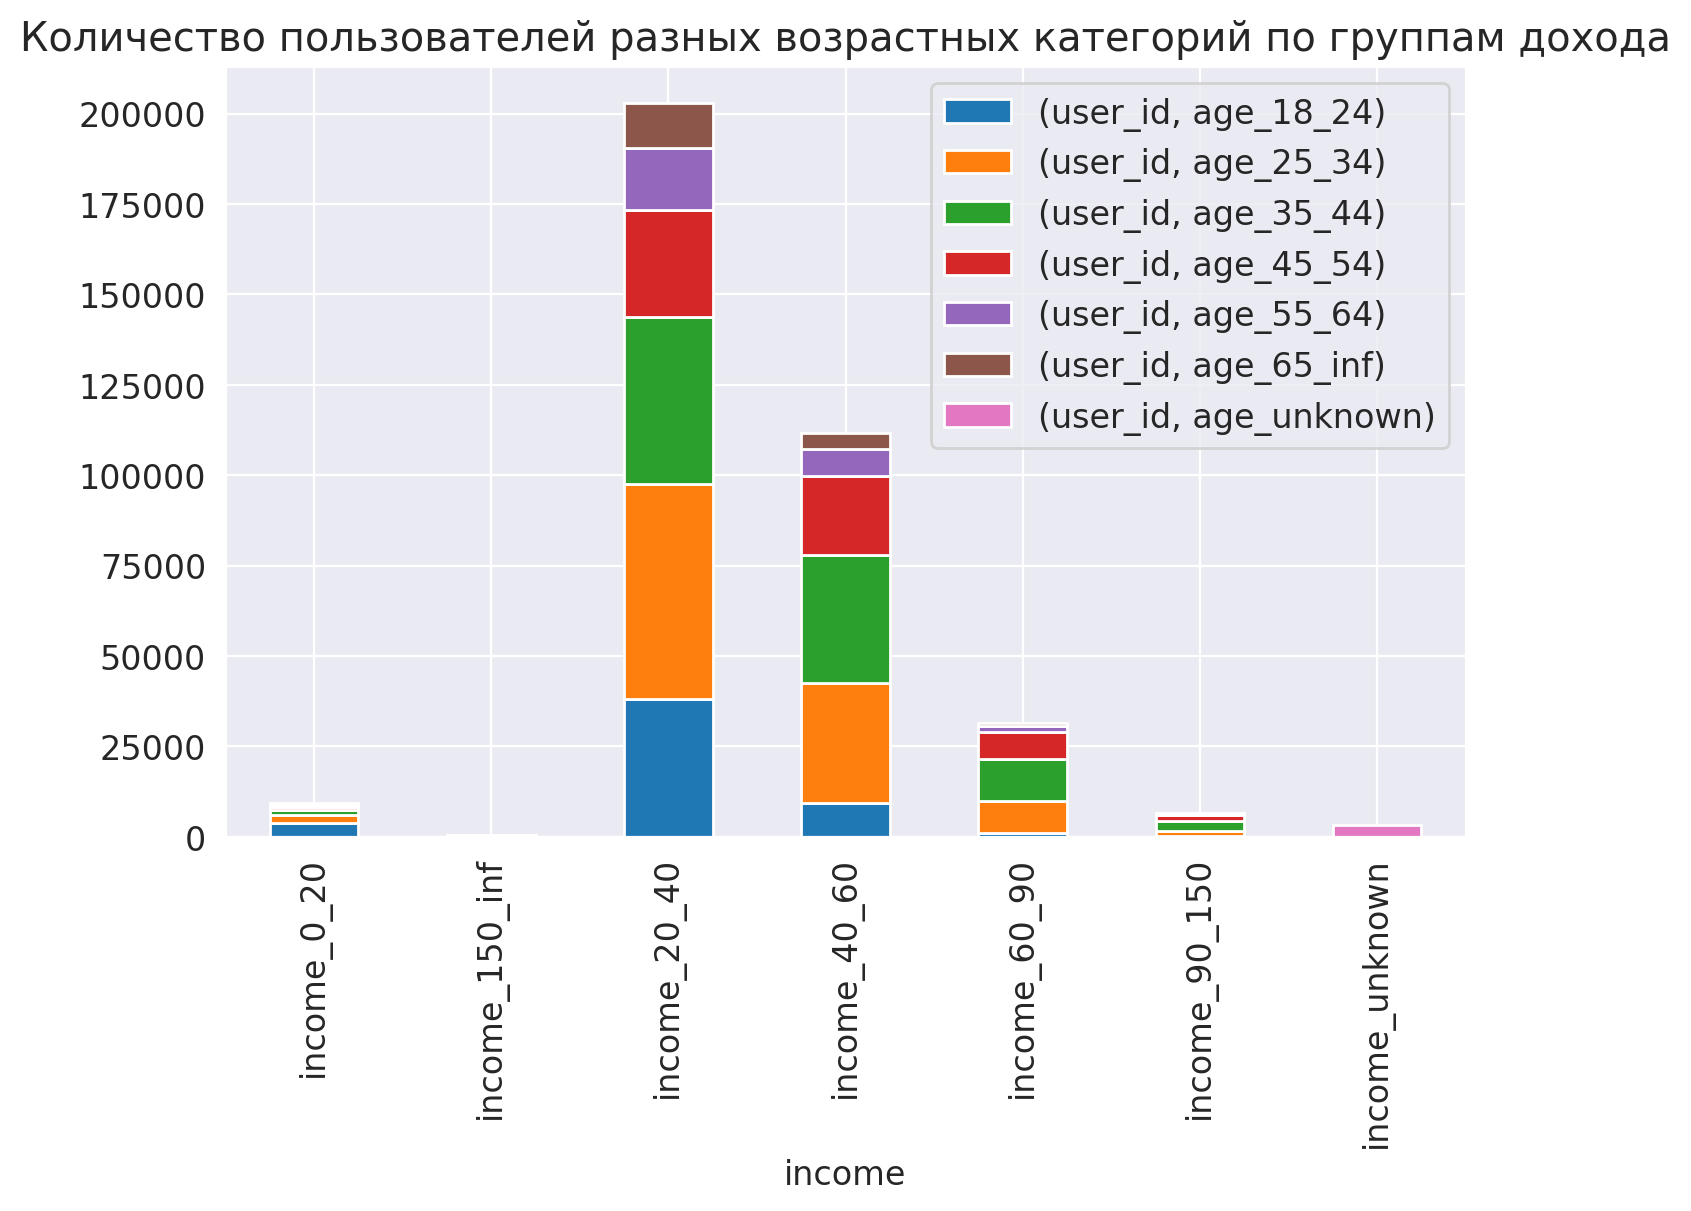

In [ ]:
income_to_age.unstack().plot(kind='bar', stacked=True)
plt.legend(loc="upper right")
plt.title('Количество пользователей разных возрастных категорий по группам дохода')
plt.show()

In [ ]:
most_common_age = {}

for income_group in users_df['income'].unique():
    age_counts = users_df[users_df['income'] == income_group]['age'].value_counts()
    if not age_counts.empty:
        most_common_age[income_group] = age_counts.idxmax()

In [ ]:
def fill_age_based_on_income(row):
    if pd.isna(row['age']):
        income_group = row['income']
        return most_common_age[income_group]
    return row['age']

In [ ]:
users_df['age'] = users_df.apply(fill_age_based_on_income, axis=1)

#### Income

Большинство пользователей зарабатывает 20-40 тысяч. Дальше небольшие группы пользователей по доходу и по возрасту можно будет объединить вместе

In [ ]:
income_order = ['income_0_20', 'income_20_40','income_40_60', 'income_60_90','income_90_150','income_150_inf']

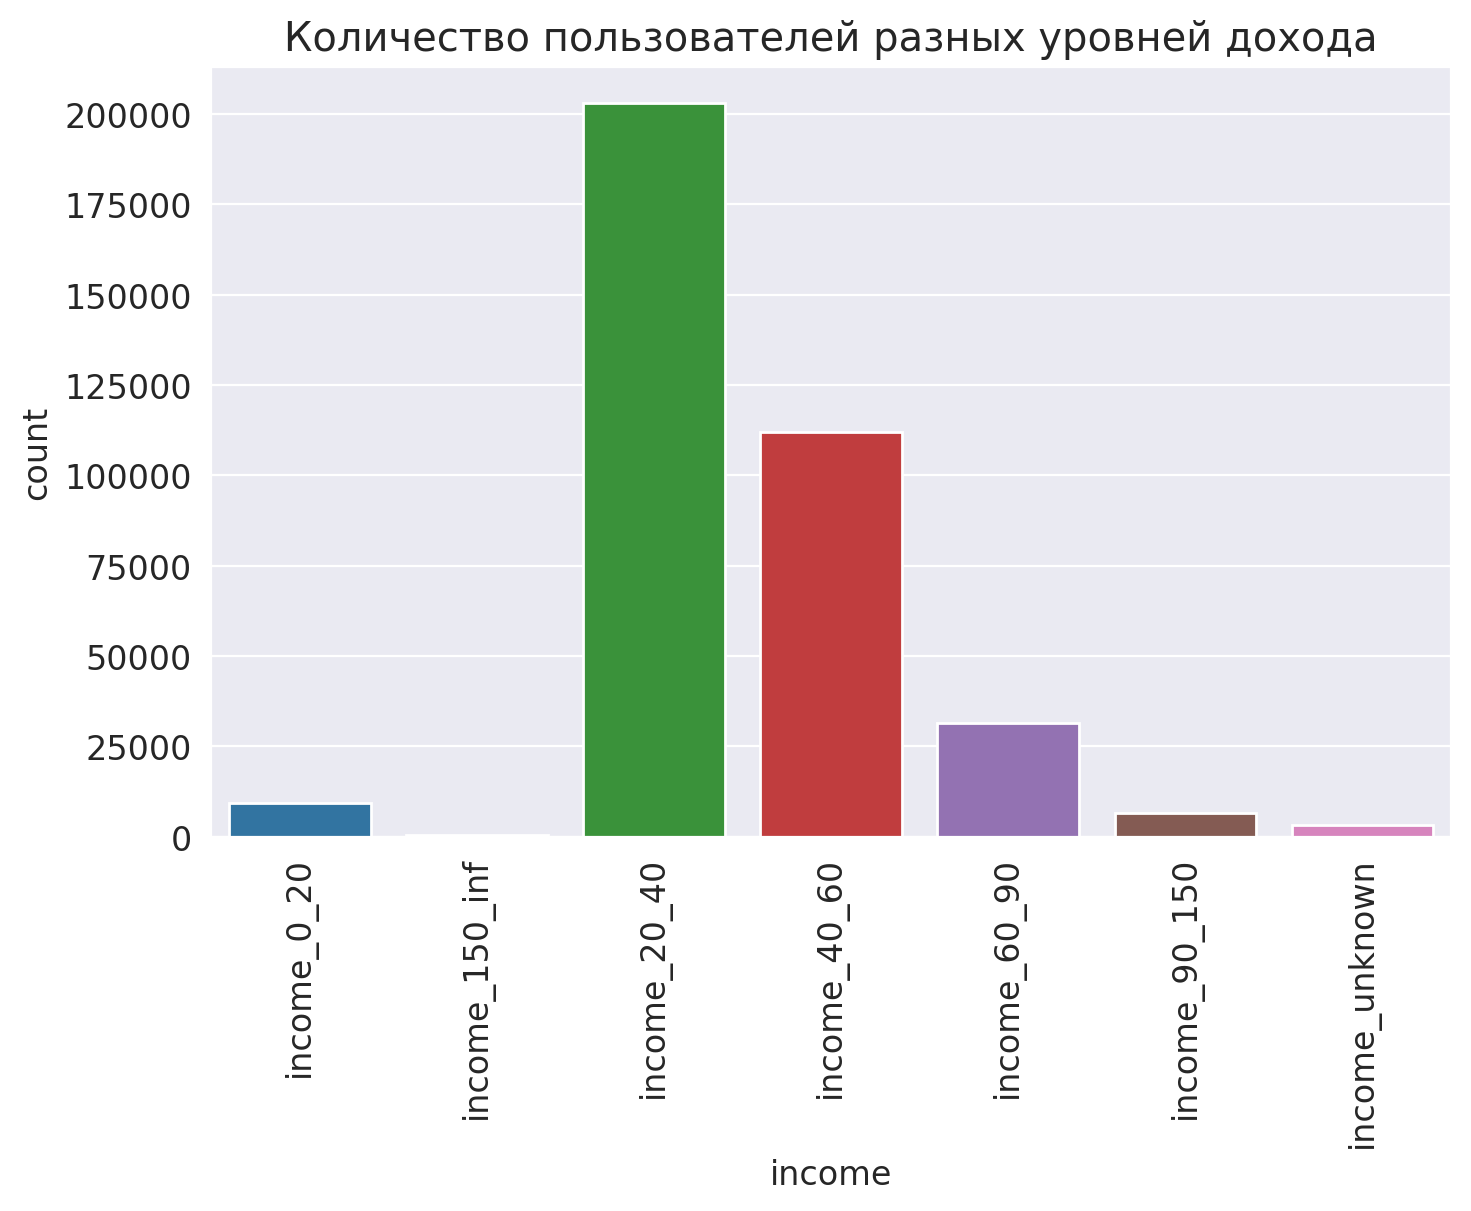

In [ ]:
sns.countplot(x = users_df["income"].sort_values())
plt.title('Количество пользователей разных уровней дохода')
plt.xticks(minor=False, rotation = 90)
plt.show()

Теперь посмотрим на возраст и доход вместе:

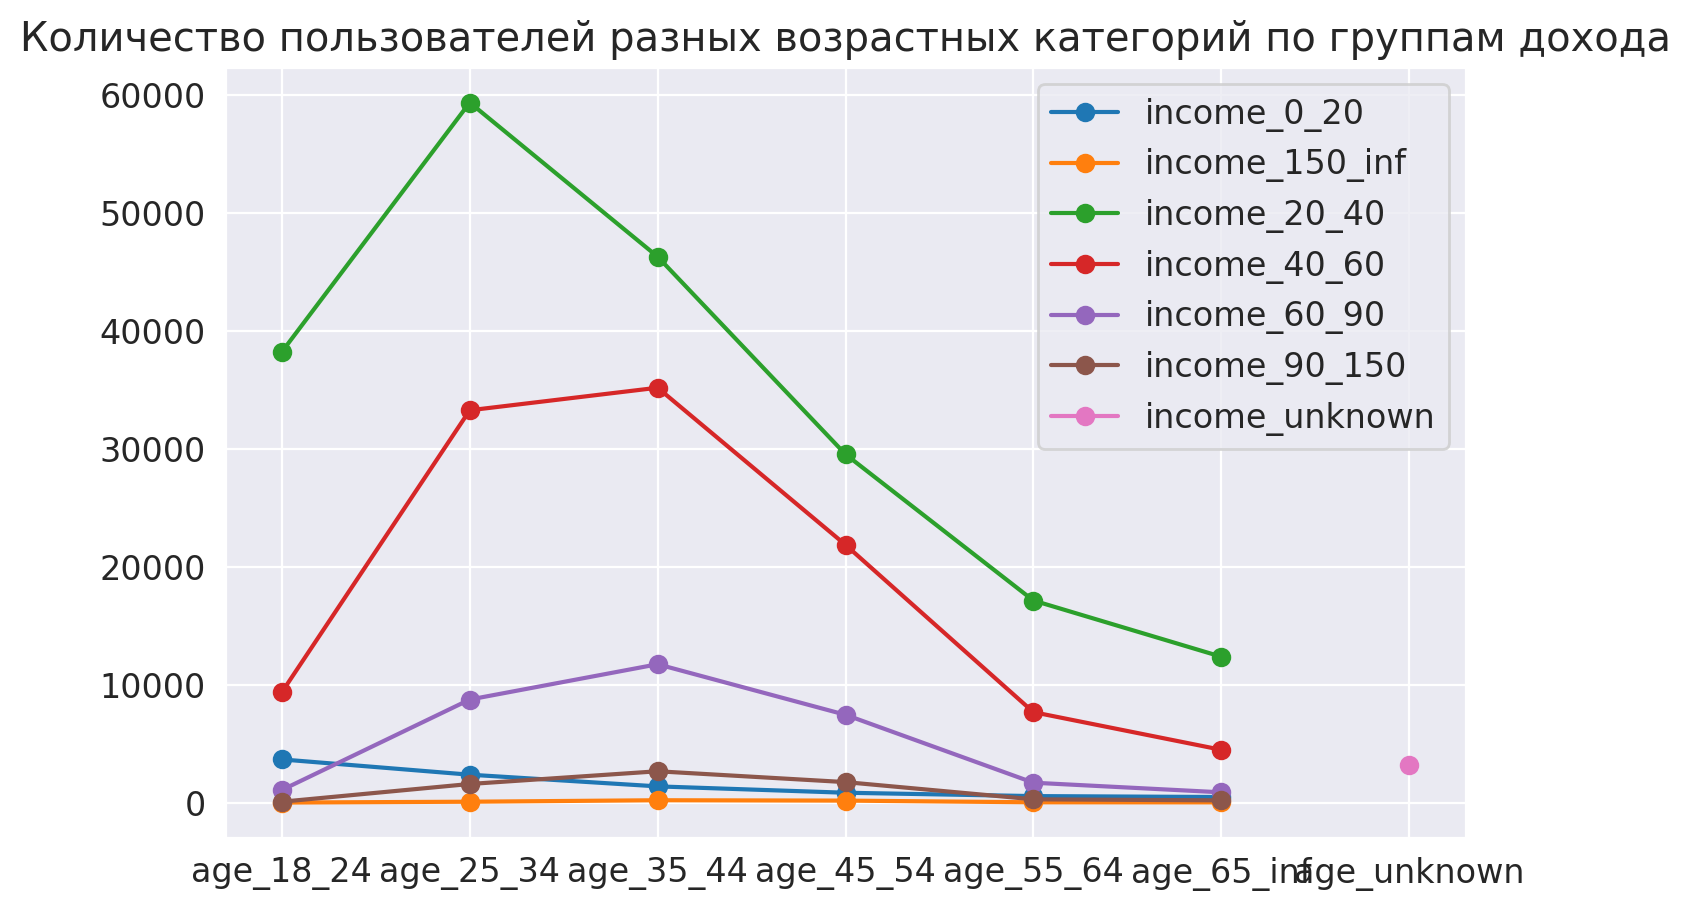

In [ ]:
for i, income_level in enumerate(income_to_age.index.levels[0]):
    age_values = income_to_age.loc[income_level]
    plt.plot(age_values.index, age_values, label=income_level, marker='o')
plt.legend(loc="upper right")
plt.title('Количество пользователей разных возрастных категорий по группам дохода')
plt.show()

Повторим заполнение пропусков, теперь уже для дохода

In [ ]:
most_common_income = {}

for age_group in users_df['age'].unique():
    income_count = users_df[users_df['age'] == age_group]['income'].value_counts()
    if not income_count.empty:
        most_common_income[age_group] = income_count.idxmax()

In [ ]:
def fill_income_based_on_age(row):
    if pd.isna(row['income']):
        age_group = row['age']
        return most_common_income[age_group]
    return row['income']

In [ ]:
users_df['income'] = users_df.apply(fill_income_based_on_age, axis=1)

#### Sex

Женщин чуть больше, чем мужчин

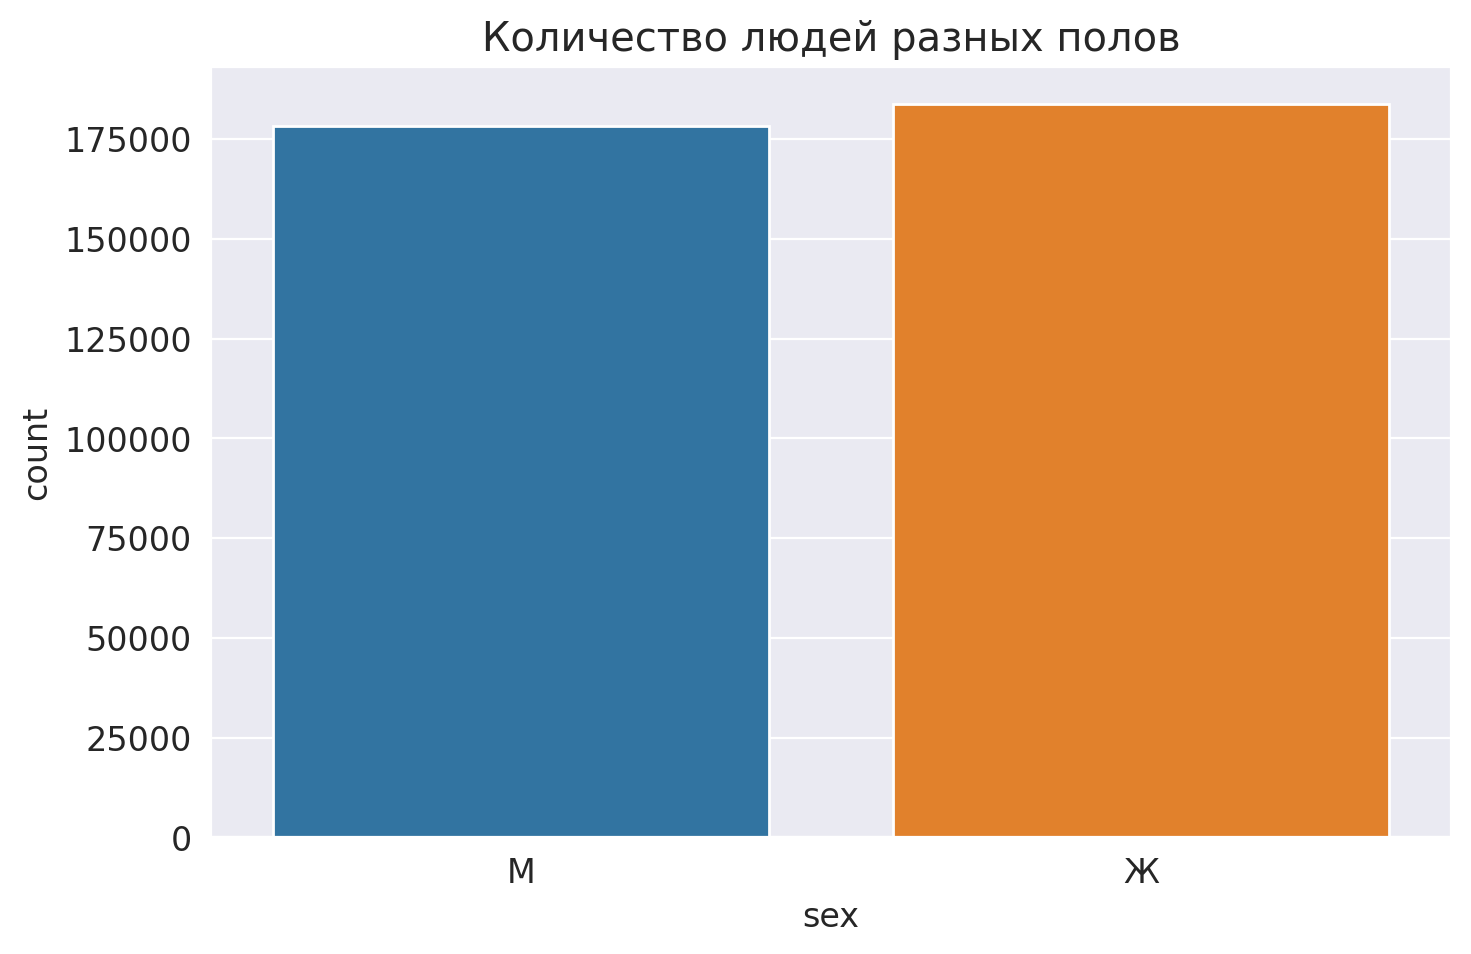

In [ ]:
sns.countplot(x= users_df["sex"])
plt.title("Количество людей разных полов")
plt.show()

In [ ]:
condition = (users_df["sex"].isna()) & (users_df.age == "unknown")
users_df.loc[condition, "sex"] = "sex_unknown"

In [ ]:
income_age_to_sex = users_df[["income","age", "sex", "user_id"]].groupby(["income", "age", "sex"]).count()

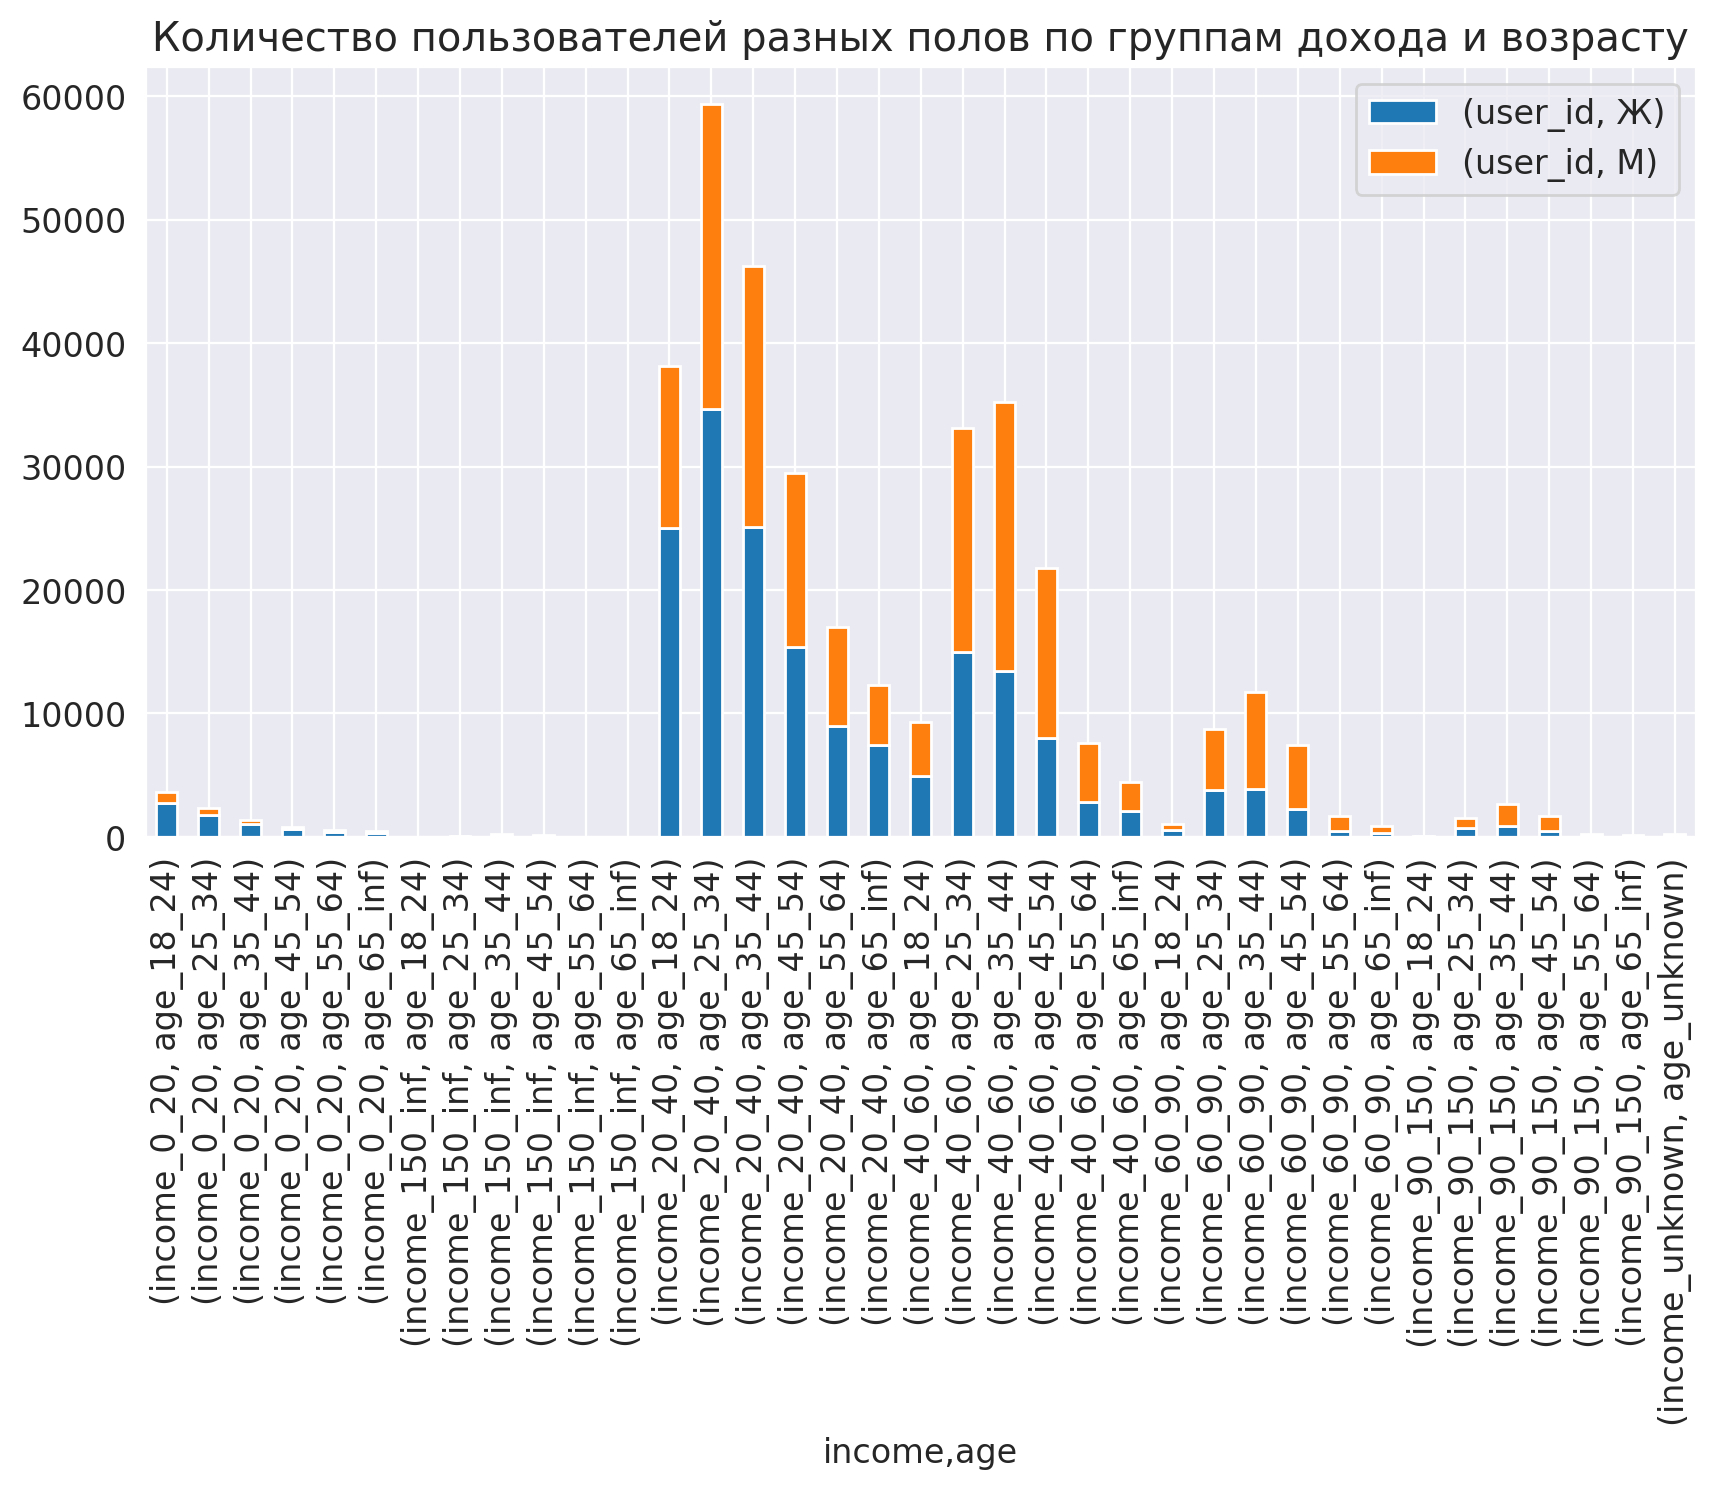

In [ ]:
ias_plot = income_age_to_sex.unstack().plot(kind='bar', stacked=True)
ias_plot.figure.set_size_inches(10, 5)
plt.legend(loc="upper right")
plt.title('Количество пользователей разных полов по группам дохода и возрасту')
plt.show()

Аналогично прошлым признаком, заполним пол наиболее вероятным значением

In [ ]:
most_common_sex = {}

for (income_group, age_group), group_df in users_df.groupby(['income', 'age']):
    most_common_sex[(income_group, age_group)] = group_df['sex'].value_counts().idxmax()

In [ ]:
def fill_sex_based_on_income_age(row):
    if pd.isna(row['sex']):
        income_group = row['income']
        age_group = row['age']
        return most_common_sex[(income_group, age_group)]
    return row['sex']

In [ ]:
users_df['sex'] = users_df.apply(fill_sex_based_on_income_age, axis=1)

#### Kids

В данных о детях пропуски не содержатся, изучим их чуть подробнее

In [ ]:
users_df["kids_flg"].isna().sum()

0

In [ ]:
users_df["kids_flg"].value_counts()

0    247266
1    118822
Name: kids_flg, dtype: int64

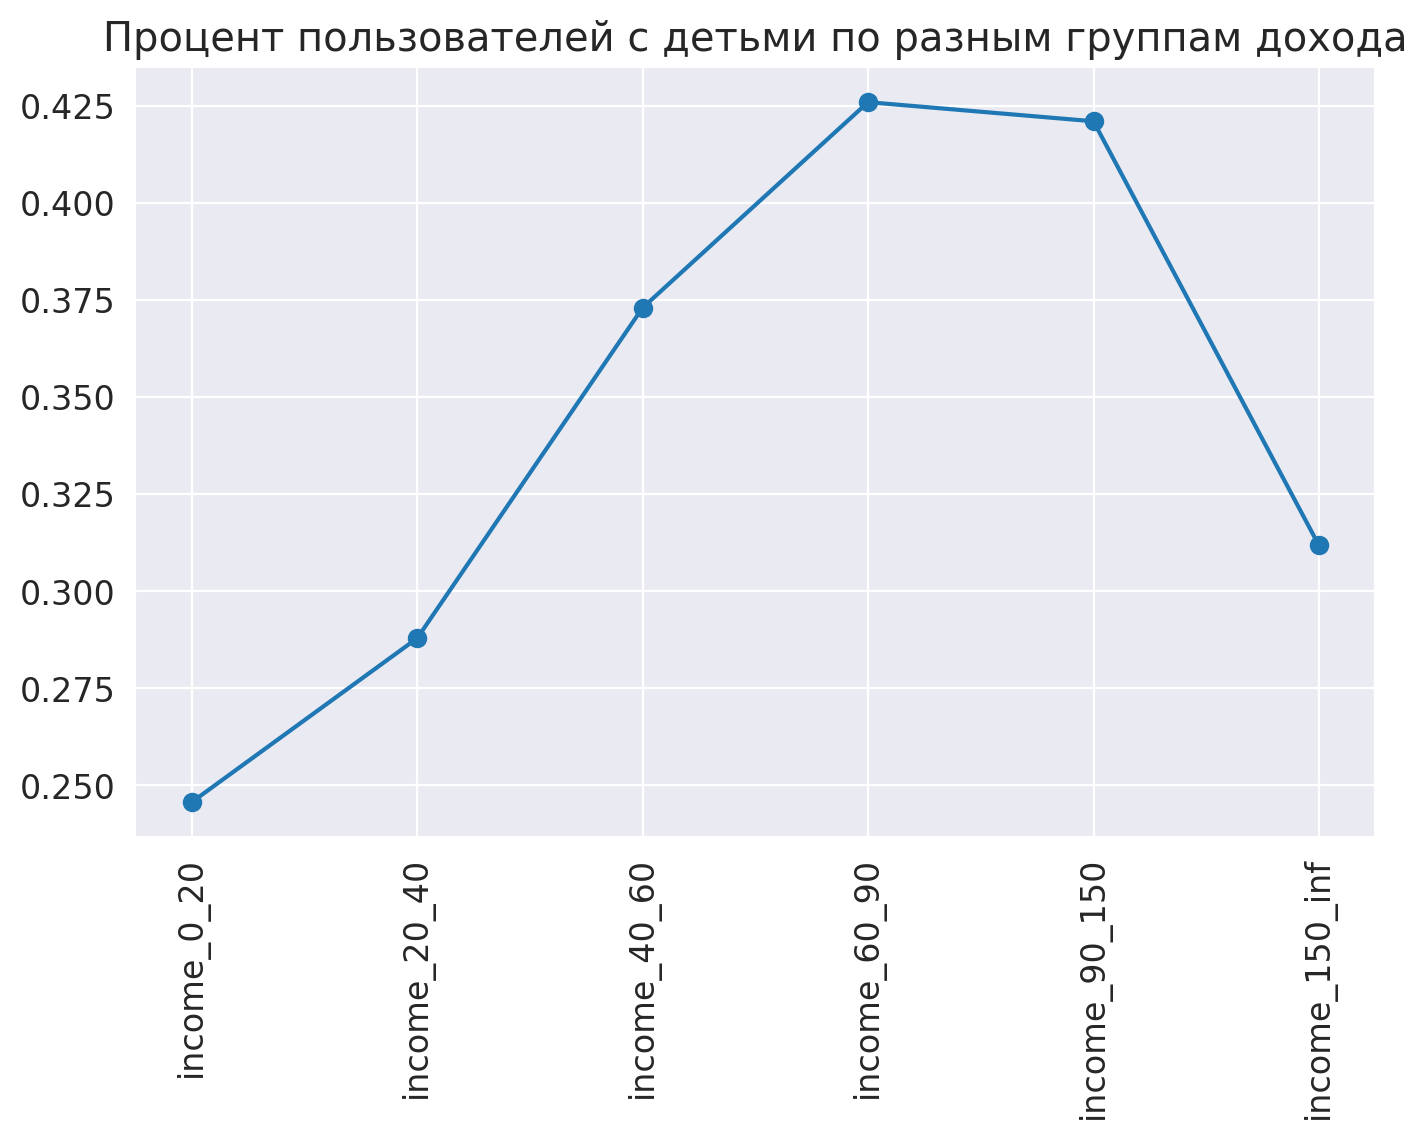

In [ ]:
plt.plot(users_df[["kids_flg", "income"]].groupby("income").mean().loc[income_order], marker='o')
plt.title('Процент пользователей с детьми по разным группам дохода')
plt.xticks(minor=False, rotation = 90)
plt.show()

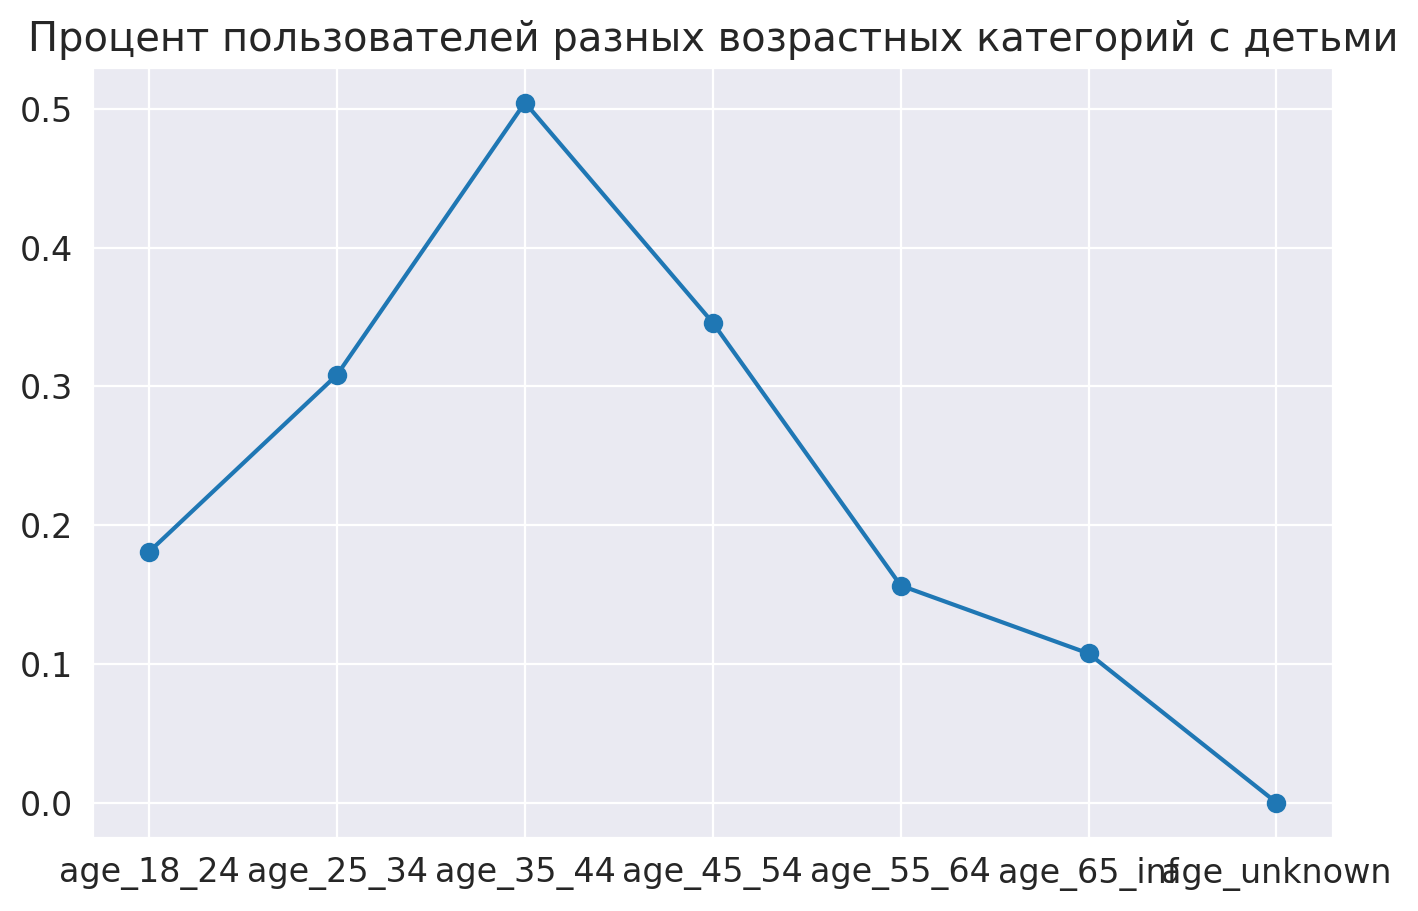

In [ ]:
plt.plot(users_df[["kids_flg", "age"]].groupby("age").mean(), marker='o')
plt.title('Процент пользователей разных возрастных категорий с детьми')
plt.show()

То есть, можем отметить, что дети в основном у пользователей 35-44 лет, и доход этих пользователей выше, чем у них сверстников

Итого: все пропуски заполнены

In [ ]:
users_df.isna().sum()

user_id     0
age         0
income      0
sex         0
kids_flg    0
dtype: int64

# EDA: трейн

In [ ]:
train_part.sample()

user_id  item_id last_watch_dt  total_dur  watched_pct
751525   196976      125    2021-07-10      144.0          2.0

In [ ]:
train_part.isna().sum()

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      265
dtype: int64

#### Процент просмотра фильма

Видим, что обычно фильм либо просматривают полностью, либо бросают в самом начале

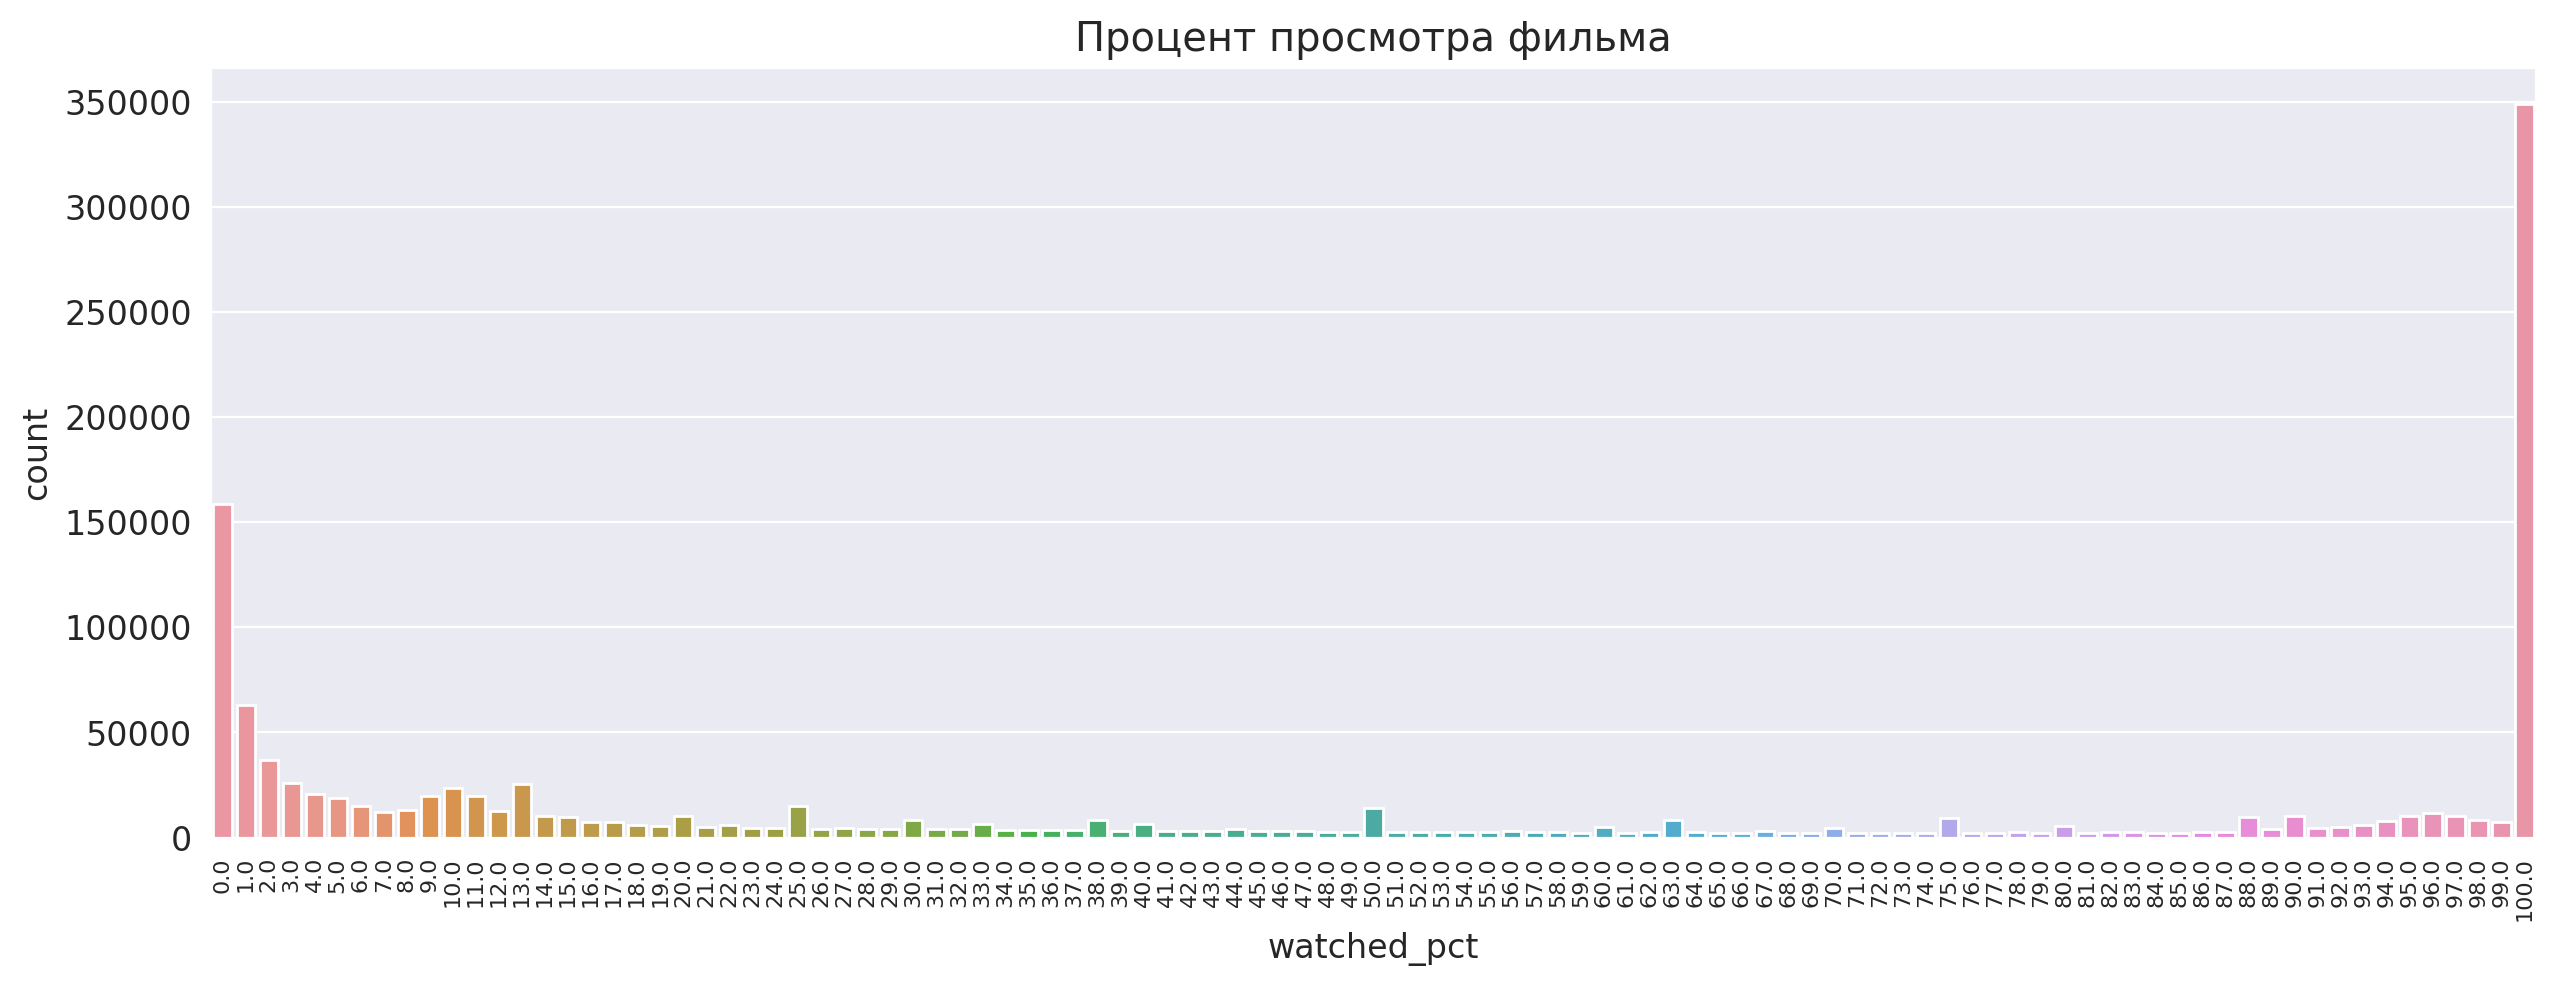

In [ ]:
watched_plt = sns.countplot(x=train_part["watched_pct"])
plt.title('Процент просмотра фильма')
plt.xticks(rotation=90, fontsize=8)

fig = watched_plt.get_figure()
fig.set_size_inches(15, 5)

Разберемся с пропусками в watched pct. Большая чась из них принадлежит 2 сериалам. Все данные о их длине пропущены. Заполню процент просмотра пропусков квантилем общего распределения

In [ ]:
for index, row in train_part.loc[train_part.watched_pct.isna()].iterrows():
  percent_rank = scipy.stats.percentileofscore(train_part['total_dur'], row['total_dur'])
  train_part.at[index, 'watched_pct'] = percent_rank

##### Длительность просмотра фильма

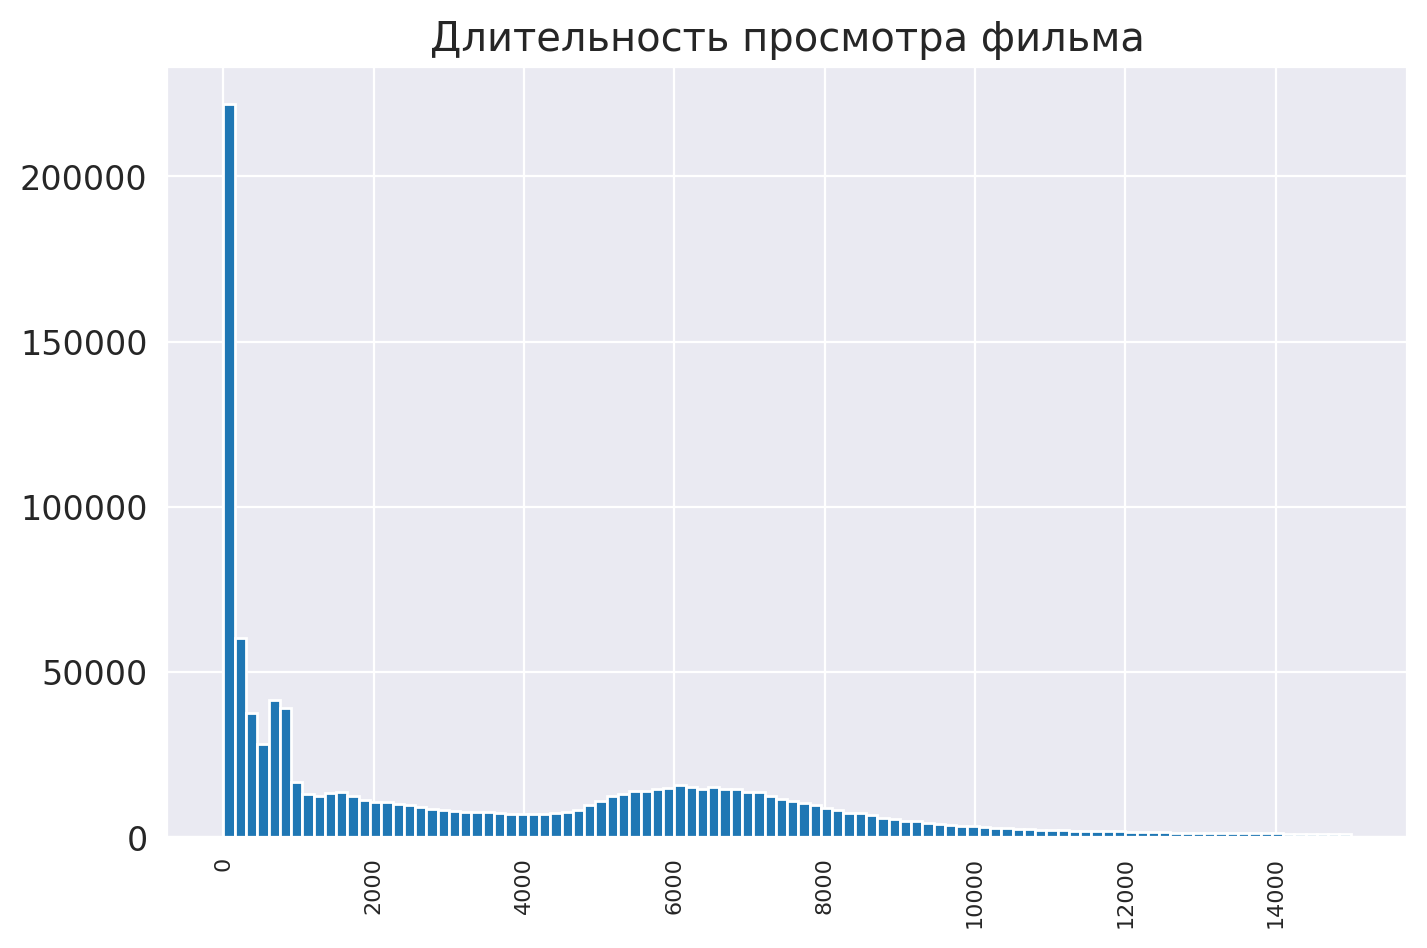

In [ ]:
plt.hist(train_part[(train_part["total_dur"] < 15000)]["total_dur"], bins=100)
plt.title('Длительность просмотра фильма')
plt.xticks(rotation=90, fontsize=8)
plt.show()

Попробуем посмотреть на распределение длительности просмотра фильма в логарифмической шкале. Так мы получим примерный порядок времени просмотра и лучше поймем распределение длительности

In [ ]:
train_part["log_watch_duration"] = np.log1p(train_part["total_dur"])

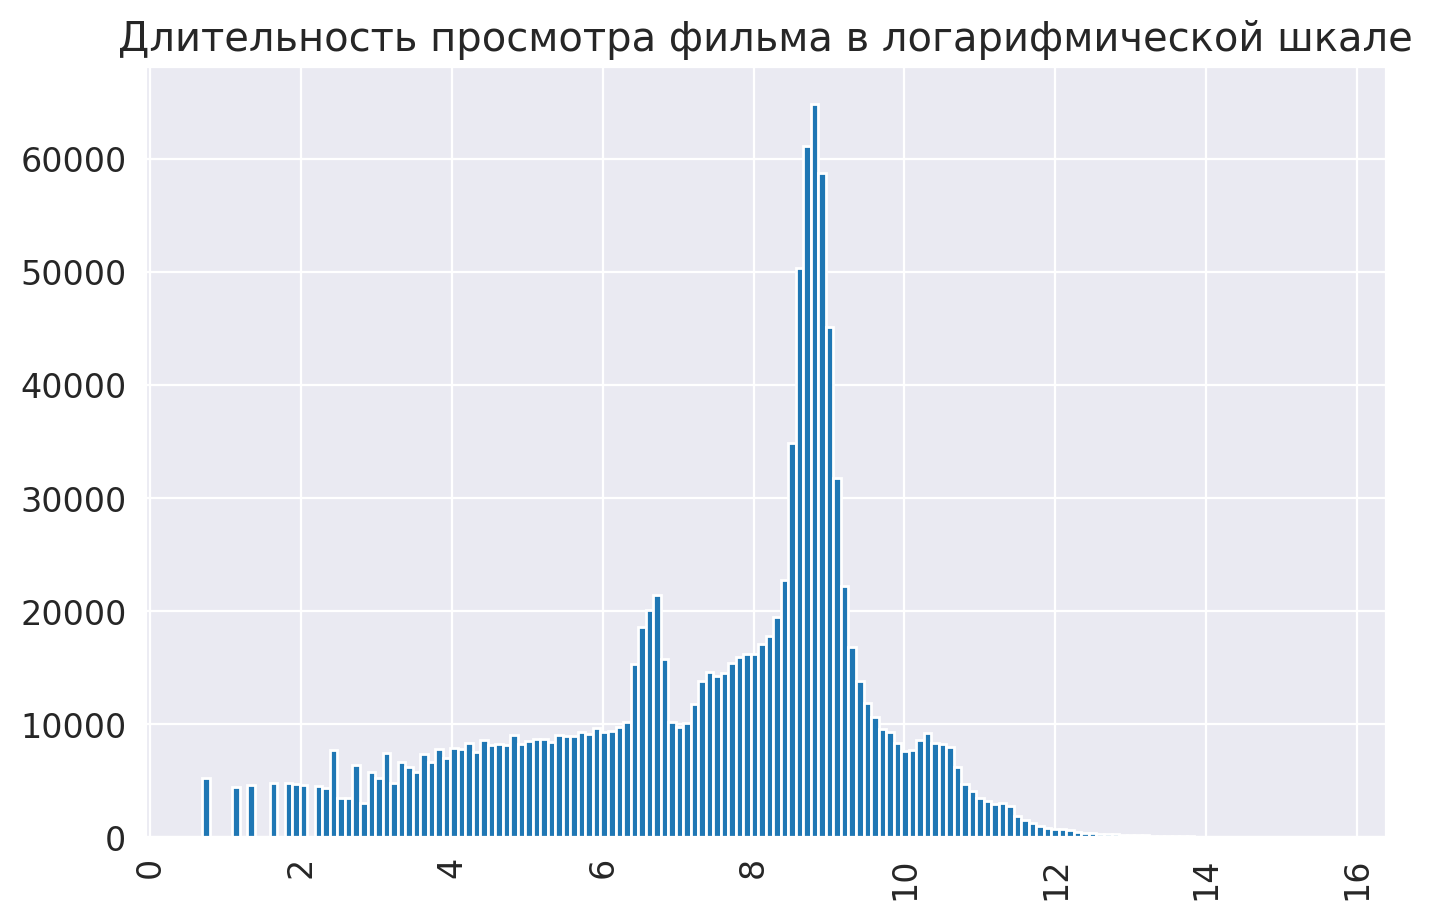

In [ ]:
plt.hist(train_part["log_watch_duration"], bins=150)
plt.title('Длительность просмотра фильма в логарифмической шкале')
plt.xticks(rotation=90)
plt.show()

Выглядит уже лучше! Изучим отдельно кусок, где логарифм больше 14. Данные, где процент просмотра меньше 90% выглядят очень подозрительно. В дальнейшем выкинем их

In [ ]:
train_part[train_part["log_watch_duration"] >=14]

user_id  item_id last_watch_dt  total_dur  watched_pct  \
2791      290517      496    2021-06-08  1509203.0        100.0   
4425      245556      496    2021-07-28  3502510.0         48.0   
16487     203286    14120    2021-06-26  1679118.0         98.0   
23854     985384    15248    2021-06-30  1452861.0         98.0   
37400     243222     5471    2021-05-20  1754345.0         98.0   
...          ...      ...           ...        ...          ...   
1151206    47224     5533    2021-05-30  5794161.0        100.0   
1154120   579434    15078    2021-07-13  3086101.0         88.0   
1157623  1047996     6968    2021-05-16  2781559.0        100.0   
1163700   564805     6192    2021-05-11  1600849.0         97.0   
1181703   329763     1544    2021-07-30  1233276.0         32.0   

         log_watch_duration  
2791              14.227093  
4425              15.068991  
16487             14.333780  
23854             14.189046  
37400             14.377607  
...                     ...  
1151206           15.572361  
1154120           14.942419  
1157623           14.838522  
1163700           14.286045  
1181703           14.025185  

[114 rows x 6 columns]

Также важно помнить, что при обучении надо будет выбрать, какую колонку  с длительностью оставить

#### Дата просмотра

In [ ]:
train_part["last_watch_dt"].value_counts()

2021-06-30    19812
2021-07-31    17194
2021-06-16    16889
2021-07-18    15973
2021-07-25    15877
              ...  
2021-04-14     3666
2021-04-06     3657
2021-04-05     3614
2021-04-13     3578
2021-04-15     3512
Name: last_watch_dt, Length: 141, dtype: int64

In [ ]:
train_part["week_start"] = train_part["last_watch_dt"].dt.to_period('W').dt.start_time

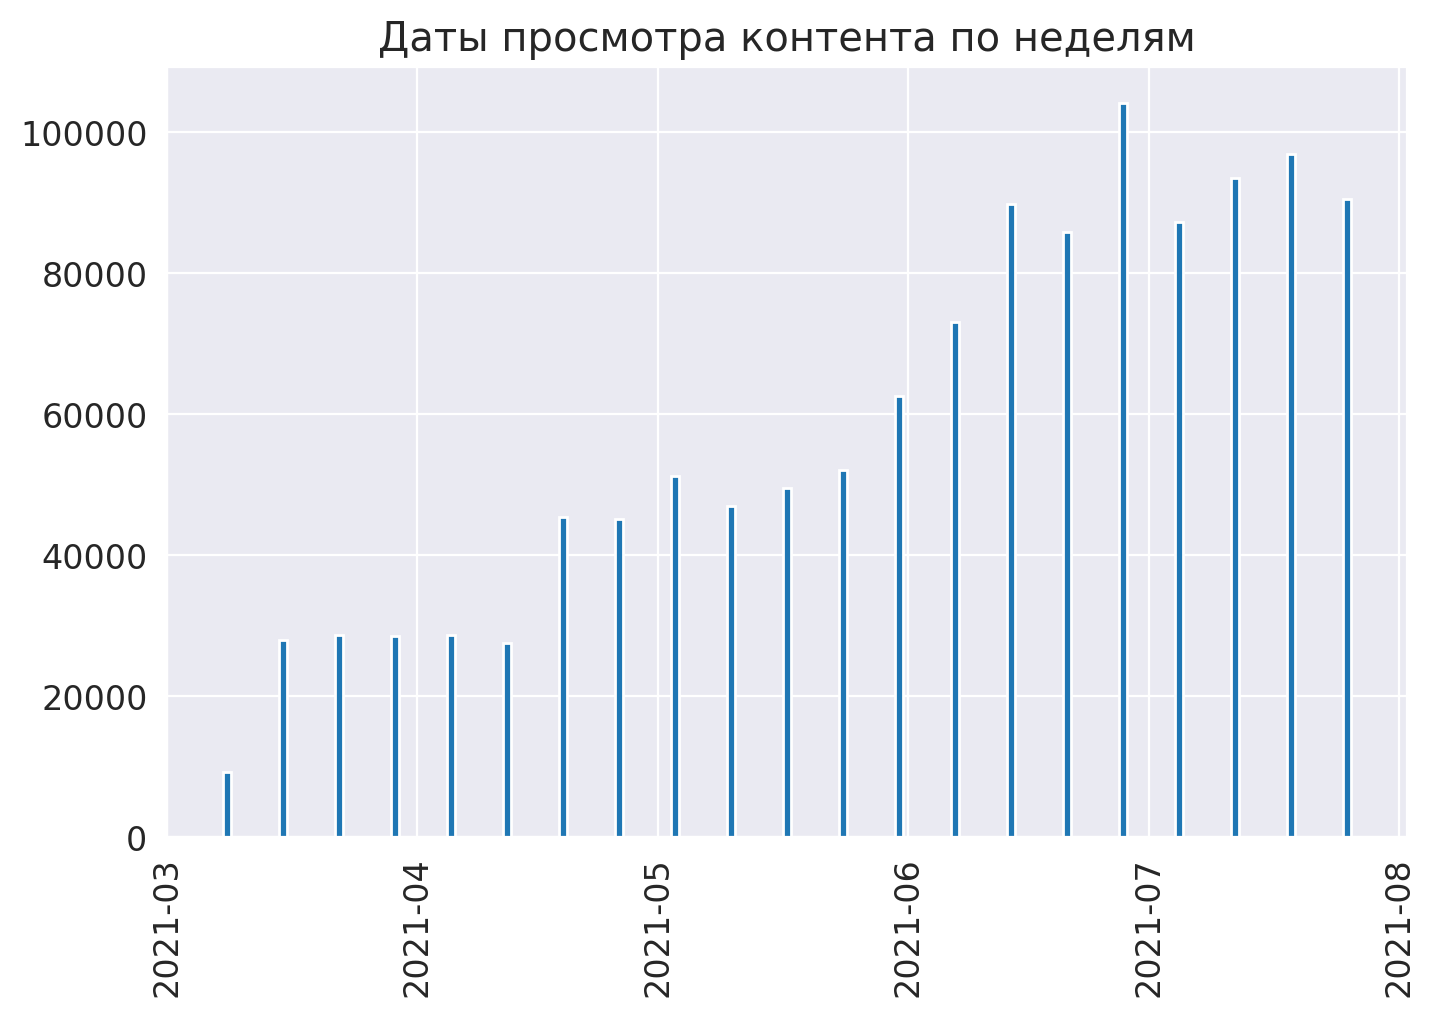

In [ ]:
plt.hist(x=train_part["week_start"], bins=141)
plt.title('Даты просмотра контента по неделям')
plt.xticks(rotation=90)
plt.show()

Топовые дни просмотров - дни премьеры завершения серий популярных оригинальных сериалов (30 июня, 16 июня), выходные дни (31 июля). Видно, что кинотеатр привлекает новых пользователей, так как 20 апреля 2021 он как раз официально открылся и все лето раздавал щедрые скидки

# Изучаем поведение пользователей

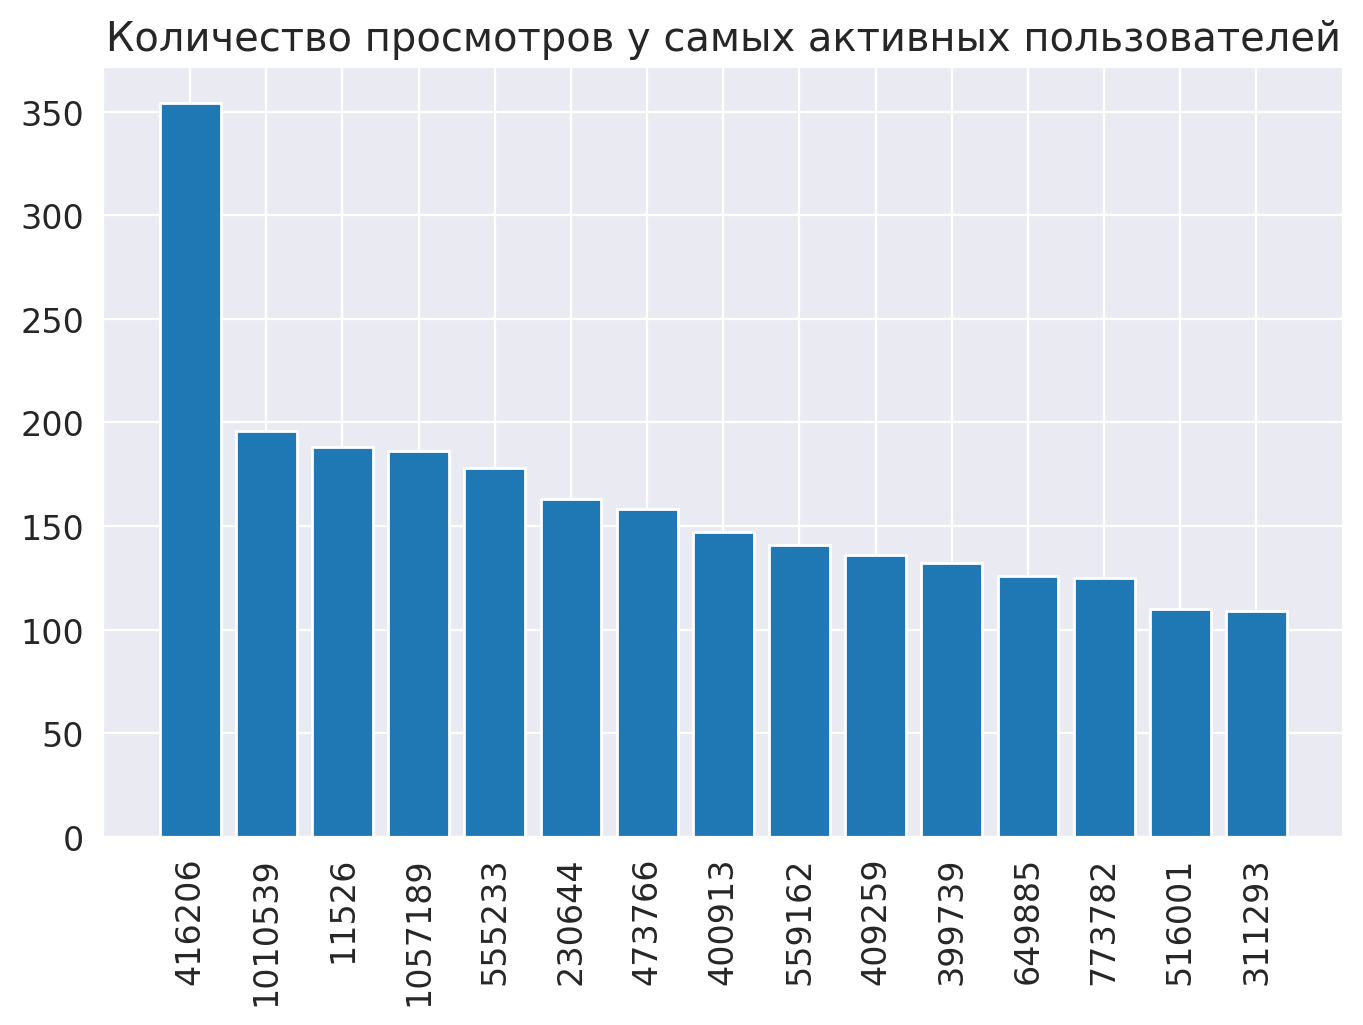

In [ ]:
plt.bar(x = train_part["user_id"].value_counts()[:15].index.astype(str), height=train_part["user_id"].value_counts()[:15].values)
plt.title("Количество просмотров у самых активных пользователей")
plt.xticks(rotation=90)
plt.show()

Топ-1 пользователь ничего почти не смотрит, его средний процент просмотра фильмов 4%:

In [ ]:
train_part[train_part["user_id"] == 416206]["watched_pct"].describe()

count    354.000000
mean       4.127119
std       15.908492
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max      100.000000
Name: watched_pct, dtype: float64

По всем пользователям он уже 48%:

In [ ]:
train_part["watched_pct"].describe()

count    1.224560e+06
mean     4.842756e+01
std      4.251774e+01
min      0.000000e+00
25%      5.000000e+00
50%      3.800000e+01
75%      1.000000e+02
max      1.000000e+02
Name: watched_pct, dtype: float64

Количество просмотренных фильмов на пользователя:

In [ ]:
train_part["user_id"].value_counts().describe()

count    459099.000000
mean          2.667311
std           3.703405
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         354.000000
Name: user_id, dtype: float64

Видим, что почти все пользователи у нас новые: около половины успели посмотреть/кликнуть только 1 фильм, 80% пользователей посмотрели не больше 3-х фильмов.

Активных пользователей всего 459099. Это больше, чем количество пользователей в датасете (366088). Новых пользователей в тестовой выборке у нас нет, что хорошо.

In [ ]:
set1 = set(train_part["user_id"].unique())

In [ ]:
set2 = set(users_df["user_id"].unique())

In [ ]:
set3 = set(test_part["user_id"].unique())

Посмотрим теперь на историю только тех пользователей, кому мы будем давать рекомендации в тесте

In [ ]:
rec_us = train_part[train_part['user_id'].isin(test_part['user_id'])]

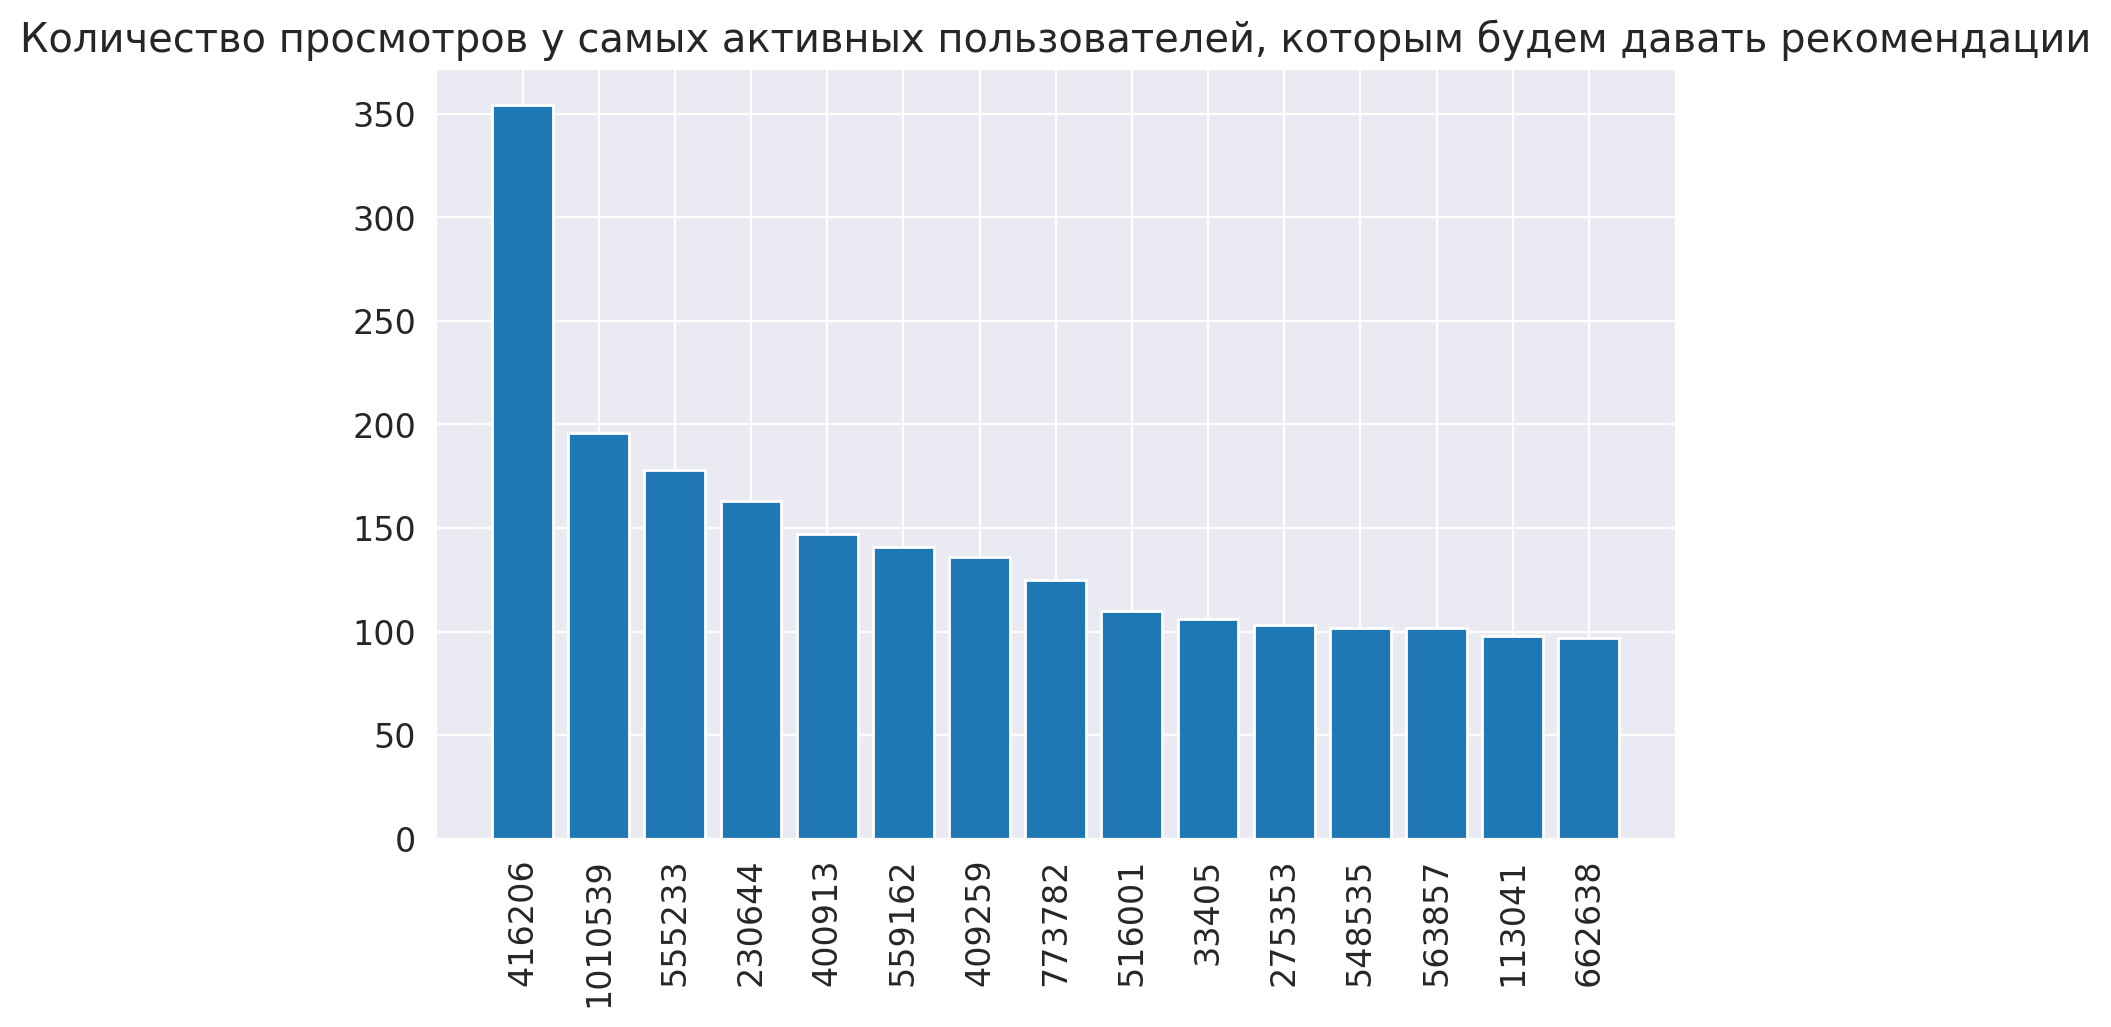

In [ ]:
plt.bar(x = rec_us["user_id"].value_counts()[:15].index.astype(str), height=rec_us["user_id"].value_counts()[:15].values)
plt.title("Количество просмотров у самых активных пользователей, которым будем давать рекомендации")
plt.xticks(rotation=90)
plt.show()

In [ ]:
rec_us["user_id"].value_counts().describe()

count    18693.000000
mean         7.040389
std          9.610170
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max        354.000000
Name: user_id, dtype: float64

Видим, что сюда попали более активные пользователи, посмотревшие большее число фильмов. По продолжительности просмотра фильмов они не очень отличаются от основной выборки:

In [ ]:
rec_us["watched_pct"].describe()

count    131606.000000
mean         53.787488
std          42.551301
min           0.000000
25%           8.000000
50%          55.000000
75%         100.000000
max         100.000000
Name: watched_pct, dtype: float64

# Изучаем популярность контента

Наибольшей популярностью пользуются оригинальные сериалы KION (с большим отрывом), а также фильмы с цифровым релизом на KIOne и просто новые популярные фильмы

In [ ]:
most_popular_movies = items_df.merge(train_part["item_id"].value_counts()[:10].reset_index().rename(columns={"index":"item_id", "item_id":"count"}), on='item_id', how='inner', indicator=True)

In [ ]:
most_popular_movies = most_popular_movies[["title", "count"]].sort_values(by='count', ascending=False)

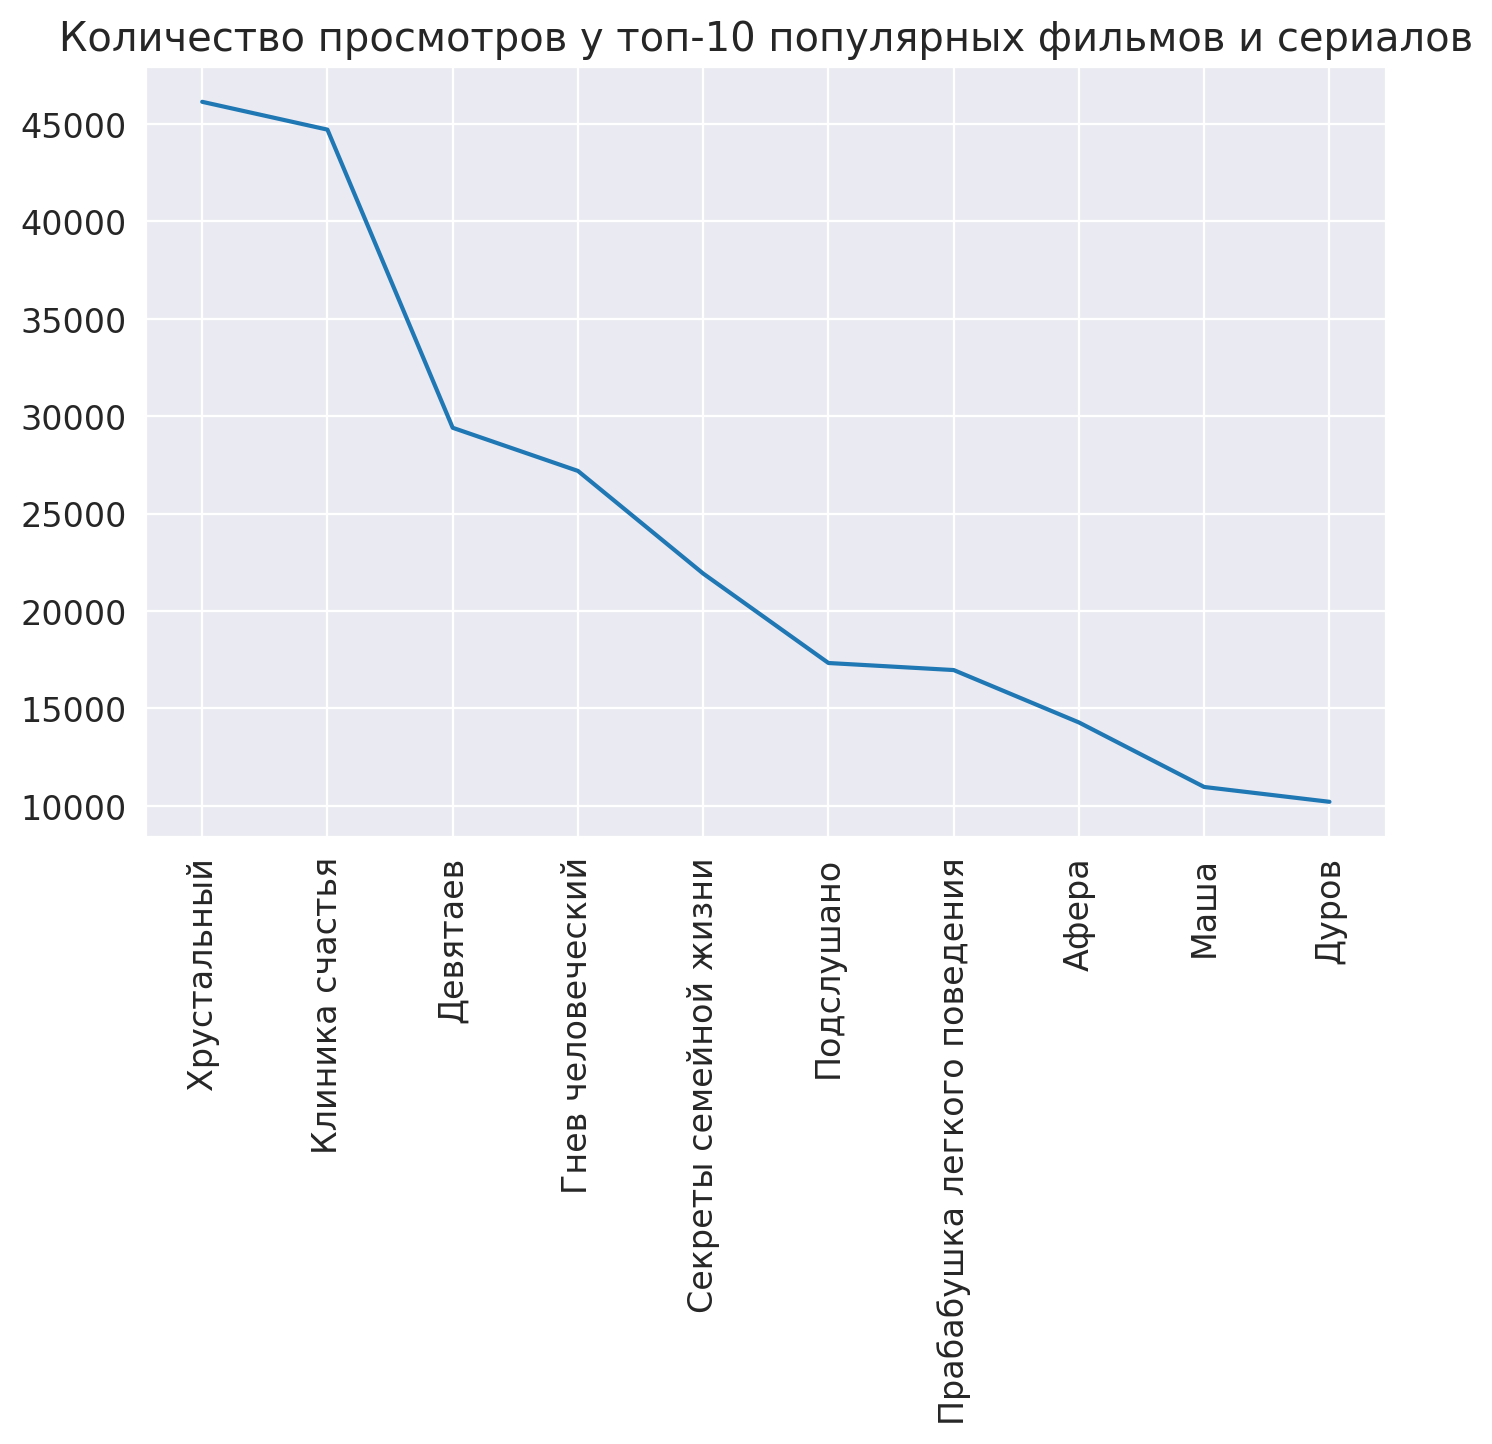

In [ ]:
plt.plot(most_popular_movies["title"], most_popular_movies["count"])
plt.title('Количество просмотров у топ-10 популярных фильмов и сериалов')
plt.xticks(rotation=90)
plt.show()

Если же говорить про все просмотры, то видим, что большинство картин не очень популярны

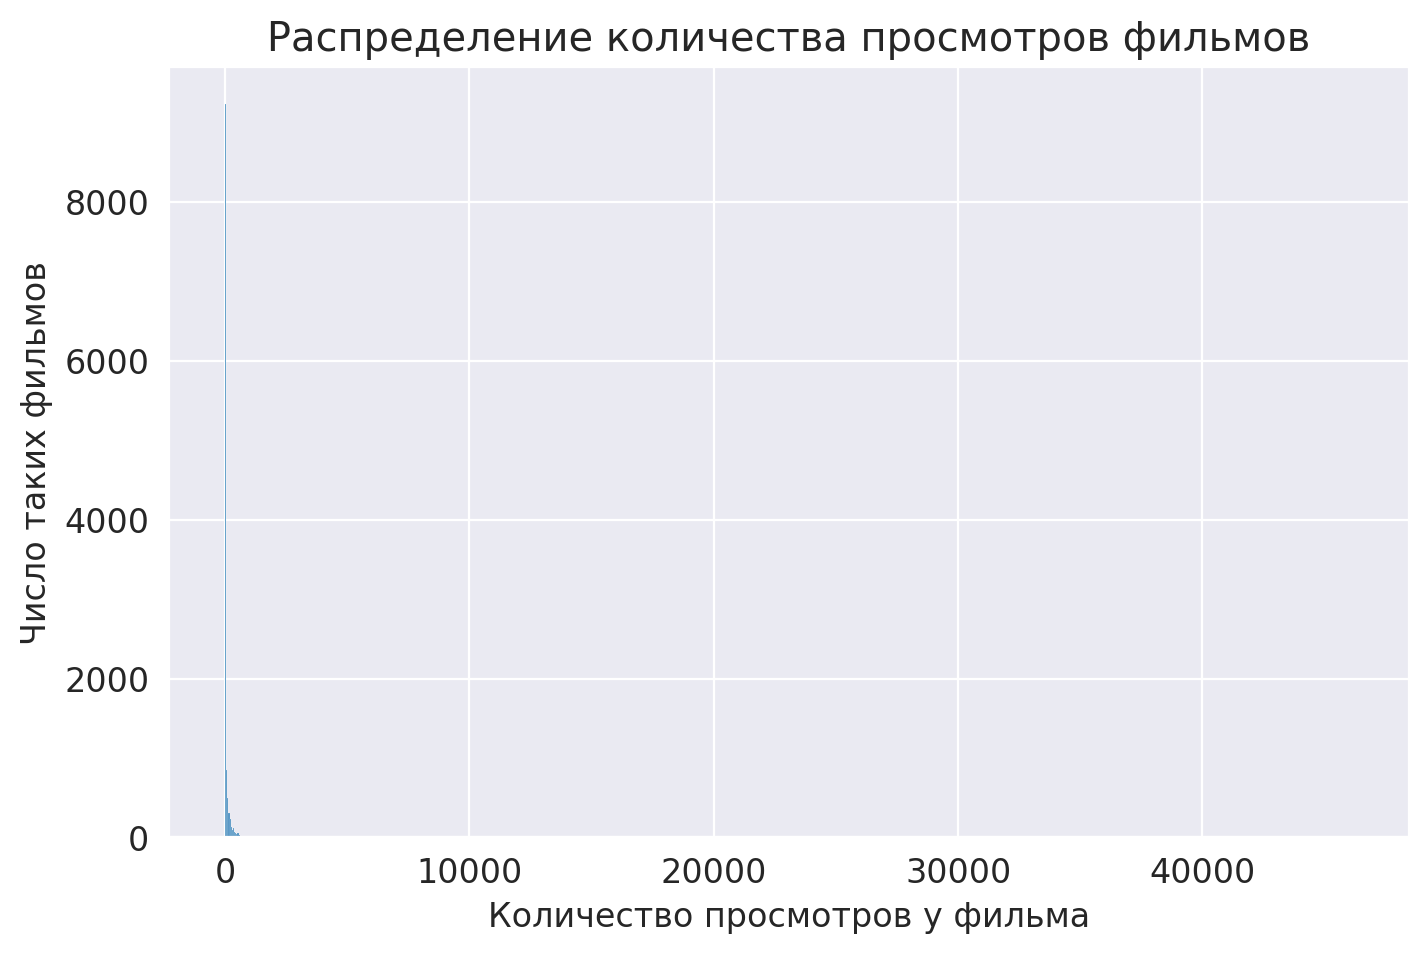

In [ ]:
sns.histplot(train_part["item_id"].value_counts().values, bins=1000)
plt.title('Распределение количества просмотров фильмов')
plt.xlabel("Количество просмотров у фильма")
plt.ylabel("Число таких фильмов")
plt.show()

Все объекты в датасете посмотрел хотя бы 1 человек. Медиана количества просмотров - 6, а среднее 101 (сильно смещено в сторону хитов)

In [ ]:
seen_shows = set(train_part["item_id"].unique())
total_shows = set(items_df["item_id"].unique())

In [ ]:
len(total_shows) - len(seen_shows)

0

In [ ]:
train_part["item_id"].value_counts().describe()

count    12067.000000
mean       101.480070
std        837.720945
min          1.000000
25%          2.000000
50%          6.000000
75%         42.000000
max      46131.000000
Name: item_id, dtype: float64

# Модели

## Implicit KNN

In [ ]:
class IKNN(BaseRecommender):
    def __init__(self, K = 1467) -> None:
        super().__init__()
        self.model = TFIDFRecommender(K=K)
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained
        knn_recs = []
        knn_similarity = []
        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn, filter_already_liked_items=True)
            knn_recs.append(self.item_encoder.inverse_transform(encoded_rec_items[0]))
            knn_similarity.append(encoded_rec_items[1])
        return pd.DataFrame({'knn_recs': knn_recs, 'knn_sim': knn_similarity})

##### Валидация:

Проведем валидацию на последних двух неделях обучающей выборки. Вообще, можно поэкспериментировать, сколько последних недель брать 1,2,3 или 4, но точно не стоит брать недели с премьерами финалов популярных сериалов, так как там данные по просмотрам будут довльно сильно отличаться от того, что происходит в среднем. Так как в тестовой выборке все пользователи имеют историю просмотров, на валидации я буду отбирать только тех пользователей, у которых она есть. Вообще, для новых пользователей можно было бы предложить рекомендовать им популярное, а еще лучше популярное по их  признакам (возраст, доход, пол) и выбрать самые важные такие признаки нам еще предстоит после обучения CatBoost

Кроме того, валидироваться на последних неделях лучше тем, что так мы увидим данные, похожие на тест, так как они стоят близко по времени

Я пробовала все три вида модели, лучше всего себя показали TFIDFRecommender и CosineRecommender

In [ ]:
last_date = train_part['last_watch_dt'].max()

In [ ]:
train = train_part[(train_part['last_watch_dt'] < last_date - pd.Timedelta(days=14))]
validation = train_part[(train_part['last_watch_dt'] >= last_date - pd.Timedelta(days=14))]
validation = validation[validation['user_id'].isin(train['user_id'].unique())]

In [ ]:
train.shape

(1006614, 7)

In [ ]:
validation.shape

(108861, 7)

In [ ]:
validation.drop(columns=["last_watch_dt", "total_dur", "watched_pct" ,"log_watch_duration"], inplace=True)
validation = validation.groupby('user_id')['item_id'].apply(list).reset_index()
validation.rename(columns={'item_id':'ground_truth'}, inplace=True)

Обучим модель, затем по валидационной выборке подберем гиперпараметры:

In [ ]:
def evaluate_KNN(train, validation):
    results_df = pd.DataFrame(columns=['K', 'Mean Similarity', 'Score'])

    for K in np.linspace(1000, 1700, 10):
        knn_model = IKNN(K)
        knn_model.fit(train)
        knn_recs = knn_model.predict(validation.drop(columns="grounded_truth"))

        mean_similarity = knn_recs.knn_sim.explode().mean()
        validation["knn_recs"] = knn_recs['knn_recs']
        score = evaluate_recommender(validation, model_preds_col="knn_recs")

        results_df = results_df.append({'K': K, 'Mean Similarity': mean_similarity, 'Score': score}, ignore_index=True)

    return results_df

###### TFIN

In [ ]:
tfin_results = evaluate_KNN(train, validation)

In [ ]:
tfin_results

K  Mean Similarity  \
0  1000.000000         0.097927   
1  1077.777778         0.098016   
2  1155.555556         0.098080   
3  1233.333333         0.098128   
4  1311.111111         0.098165   
5  1388.888889         0.098195   
6  1466.666667         0.098218   
7  1544.444444         0.098235   
8  1622.222222         0.098249   
9  1700.000000         0.098261   

                                               Score  
0  {'ndcg': 0.12053862042408331, 'recall': 0.0992...  
1  {'ndcg': 0.12056339219836208, 'recall': 0.0993...  
2  {'ndcg': 0.12061770258835866, 'recall': 0.0993...  
3  {'ndcg': 0.12059920367518373, 'recall': 0.0993...  
4  {'ndcg': 0.12060817789052597, 'recall': 0.0993...  
5  {'ndcg': 0.12064876384285364, 'recall': 0.0993...  
6  {'ndcg': 0.1206595490591723, 'recall': 0.09933...  
7  {'ndcg': 0.12064277255198887, 'recall': 0.0993...  
8  {'ndcg': 0.12062204535041028, 'recall': 0.0992...  
9  {'ndcg': 0.12058226663599281, 'recall': 0.0992...

In [ ]:
def get_ndcg(str_score: str):
  ndcg_value = re.search(r"'ndcg': (\d+\.\d+)", str_score).group(1)
  return ndcg_value

In [ ]:
tfin_results['Score'] = tfin_results['Score'].astype(str)

In [ ]:
tfin_results['ndcg'] = tfin_results['Score'].apply(get_ndcg)

In [ ]:
tfin_results['ndcg'] = tfin_results['ndcg'].astype(float)

In [ ]:
max_ndcg_row = tfin_results[tfin_results['ndcg'] == tfin_results['ndcg'].max()]

In [ ]:
print(f'Best k is {max_ndcg_row["K"].values[0]} with ndcg={max_ndcg_row["ndcg"].values[0]}')

Best k is 1466.6666666666665 with ndcg=0.1206595490591723


###### Cosine

In [ ]:
cosine_results = evaluate_KNN(train, validation)

In [ ]:
cosine_results['Score'] = cosine_results['Score'].astype(str)
cosine_results['ndcg'] = cosine_results['Score'].apply(get_ndcg)
cosine_results['ndcg'] = cosine_results['ndcg'].astype(float)
max_ndcg_row_cos = cosine_results[cosine_results['ndcg'] == cosine_results['ndcg'].max()]
print(f'Best k is {max_ndcg_row_cos["K"].values[0]} with ndcg={max_ndcg_row_cos["ndcg"].values[0]}')

Best k is 2084.736842105263 with ndcg=0.1163270707005327


##### Работа на тесте

На этапе валидации себя лучше показала TFIDF, поэтому я остановилась на этом типе. В области ее лучших значений метрик я дополнительно проверила еще несколько значений К

Запустим модель с подобранным гиперпараметром (указан в классе, как и выбранный тип модели) и замерим метрики на тестовой выборке

In [ ]:
knn_model = IKNN()

In [ ]:
knn_model.fit(train_part)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.010645627975463867 seconds
  warnings.warn(


  0%|          | 0/12067 [00:00<?, ?it/s]

In [ ]:
knn_recs = knn_model.predict(test_part.drop(columns="grounded_truth"))

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [ ]:
print(f'Средняя близость получилась довольно маленькой: {knn_recs.knn_sim.explode().mean()}')

Средняя близость получилась довольно маленькой: 0.1237333703096112


In [ ]:
test_part["knn_recs"] = knn_recs['knn_recs']

Метрики:

In [ ]:
evaluate_recommender(test_part, model_preds_col="knn_recs")

{'ndcg': 0.12740625299219174, 'recall': 0.056630588488746386}

##### EDA рекомендаций

Сравним топ рекомендаций с топом самого популярного контента: в топ-10 этой модели 7 фильмов совпадает с топ-10 самых популярных, однако места среди них распределились иначе: сильно вырвался вперед "Девятаев". Добавились 2 части Мстителей и Ральф

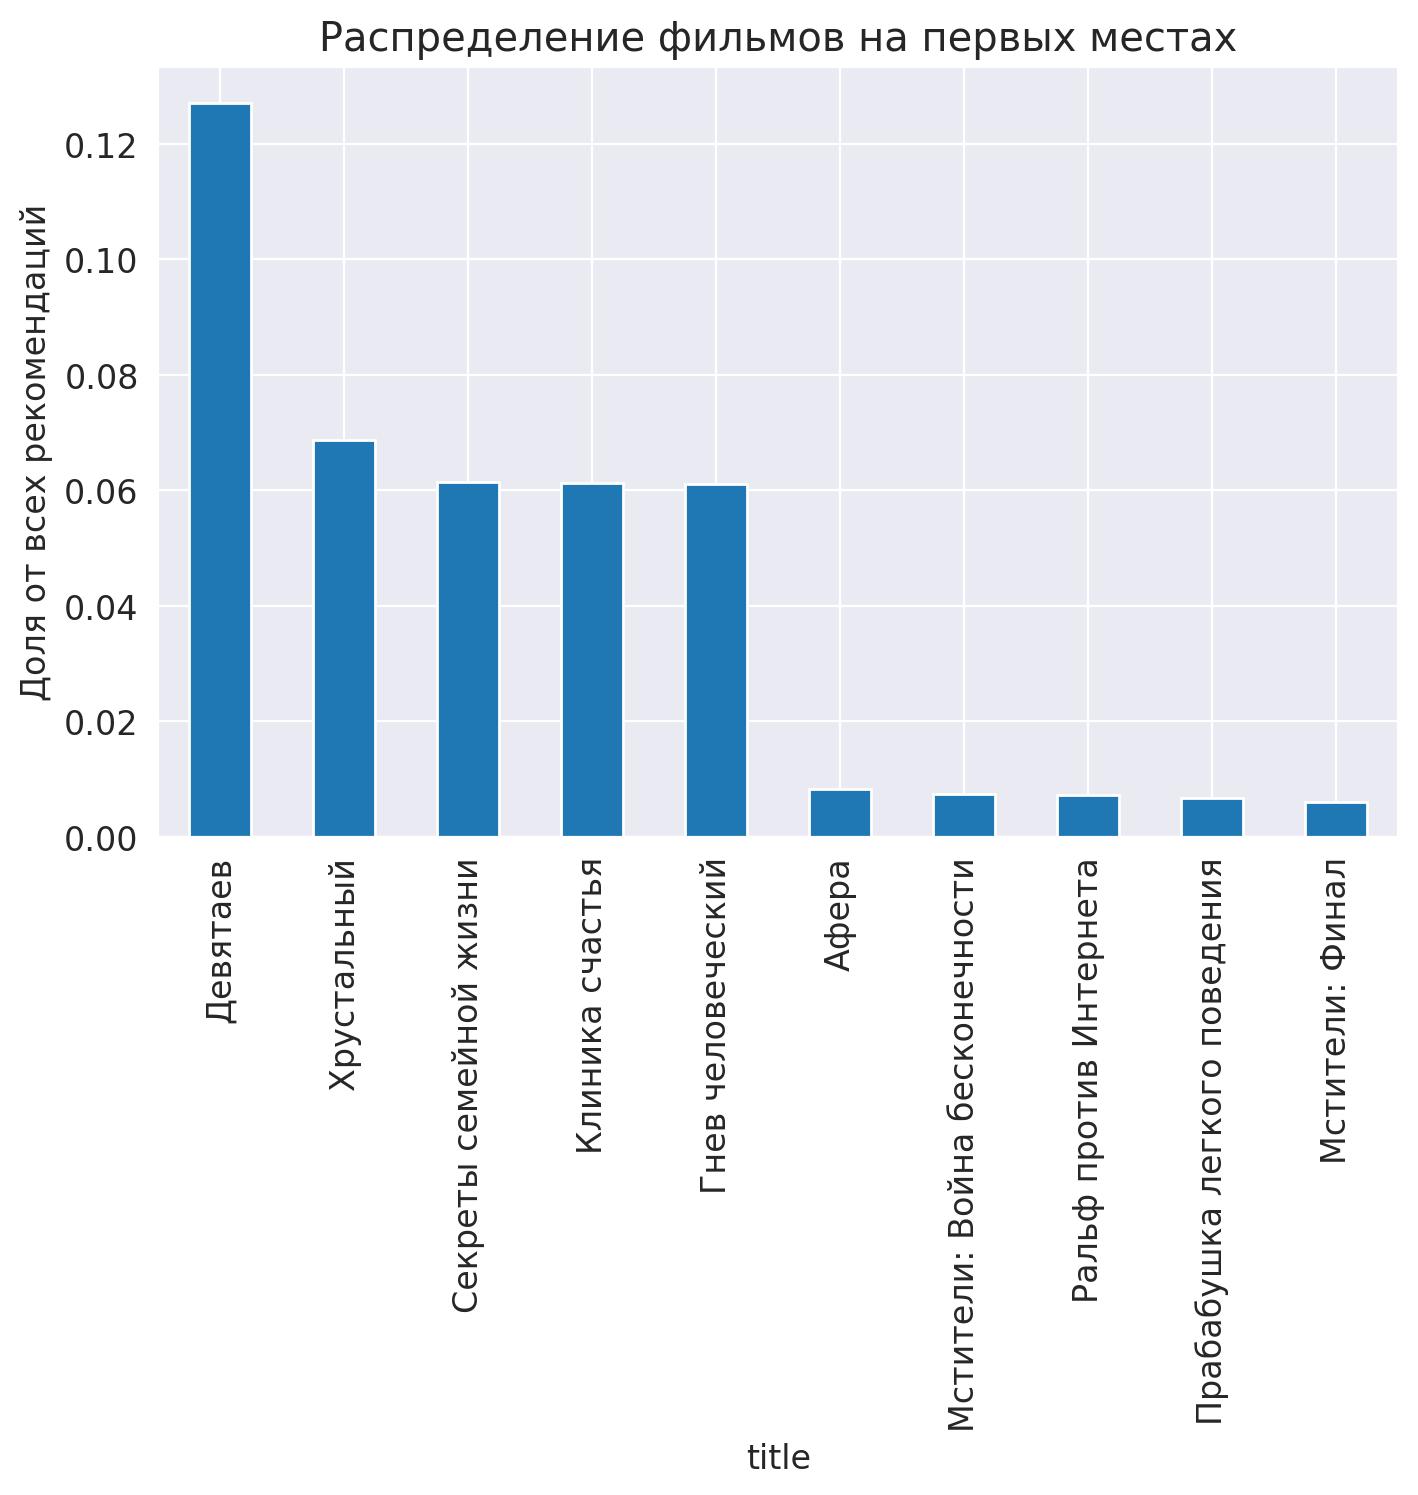

In [ ]:
plot_first_items(test_part, items_df, 'knn_recs')

Сейчас подборка похожих фильмов стала вполне себе адекватной:

In [ ]:
get_similar_films("Ральф против Интернета", knn_model)

content_type                               title  release_year  \
117          film                              Вперёд        2020.0   
966          film  Монстры на каникулах 3: Море зовёт        2018.0   
1176         film                          Тайна Коко        2017.0   
4318         film                   История игрушек 4        2019.0   
7345         film                          Зверополис        2016.0   
7457         film                               Ральф        2012.0   
7511         film                               Моана        2016.0   
8519         film                      Суперсемейка 2        2018.0   
8774         film                        Суперсемейка        2004.0   
9573         film                         Головоломка        2015.0   

                                                 genres countries  \
117   для детей, приключения, семейное, фэнтези, ком...       США   
966           мультфильм, фэнтези, приключения, комедии       США   
1176                   мультфильм, фэнтези, приключения       США   
4318                       мультфильм, фэнтези, комедии       США   
7345        приключения, мультфильм, детективы, комедии       США   
7457                       мультфильм, фэнтези, комедии       США   
7511                       мультфильм, фэнтези, мюзиклы       США   
8519                фантастика, мультфильм, приключения       США   
8774                фантастика, мультфильм, приключения       США   
9573                    фантастика, мультфильм, комедии       США   

                                directors  age_rating  
117                           Дэн Скэнлон         6.0  
966                  Генндий Тартаковский         6.0  
1176             Ли Анкрич, Эдриан Молина        12.0  
4318                            Джош Кули         6.0  
7345   Байрон Ховард, Рич Мур, Джаред Буш         6.0  
7457                              Рич Мур         6.0  
7511  Рон Клементс, Джон Маскер, Дон Холл         6.0  
8519                            Брэд Бёрд         6.0  
8774                            Брэд Бёрд         6.0  
9573      Пит Доктер, Роналдо Дель Кармен         6.0

In [ ]:
get_similar_films("Гнев человеческий", knn_model)

content_type                         title  release_year  \
158         series                         Афера        2021.0   
572         series               Клиника счастья        2021.0   
1429        series                   Хрустальный        2021.0   
4921          film                      Девятаев        2021.0   
5064        series        Секреты семейной жизни        2021.0   
5868          film                      Пальмира        2020.0   
6298          film                  Восемь сотен        2020.0   
7640          film                 Поступь хаоса        2021.0   
9137          film  Прабабушка легкого поведения        2021.0   
11506         film                          Маша        2020.0   

                                          genres                countries  \
158                                      комедии                   Россия   
572                             драмы, мелодрамы                   Россия   
1429                         триллеры, детективы                   Россия   
4921                 драмы, военные, приключения                   Россия   
5064                                     комедии                   Россия   
5868                                       драмы                   Россия   
6298       боевики, драмы, историческое, военные                    Китай   
7640   боевики, фантастика, фэнтези, приключения  США, Канада, Люксембург   
9137                                     комедии                   Россия   
11506                            драмы, триллеры                   Россия   

                  directors  age_rating  
158          Михаил Старчак        18.0  
572      Александр Кириенко        18.0  
1429         Душан Глигоров        18.0  
4921      Тимур Бекмамбетов        12.0  
5064         Шота Гамисония        18.0  
5868        Иван Болотников        16.0  
6298               Гуань Ху        18.0  
7640             Даг Лайман        16.0  
9137         Марюс Вайсберг        16.0  
11506  Анастасия Пальчикова        16.0

Также посмотрим, какие жанры в топе

In [ ]:
def plot_popular_genres(test_part: pd.DataFrame , rec_type: str , items_df: pd.DataFrame):
    first_items = pd.DataFrame([x[0] for x in test_part[rec_type].values], columns=["item_id"])
    first_items = (first_items.merge(items_df[["item_id", "genres"]], on="item_id")
                   .groupby("genres").size().sort_values(ascending=False)
                   )
    first_items /= first_items.sum()

    all_genres = ' '.join(first_items.index)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Самые популярные жанры")
    plt.show()

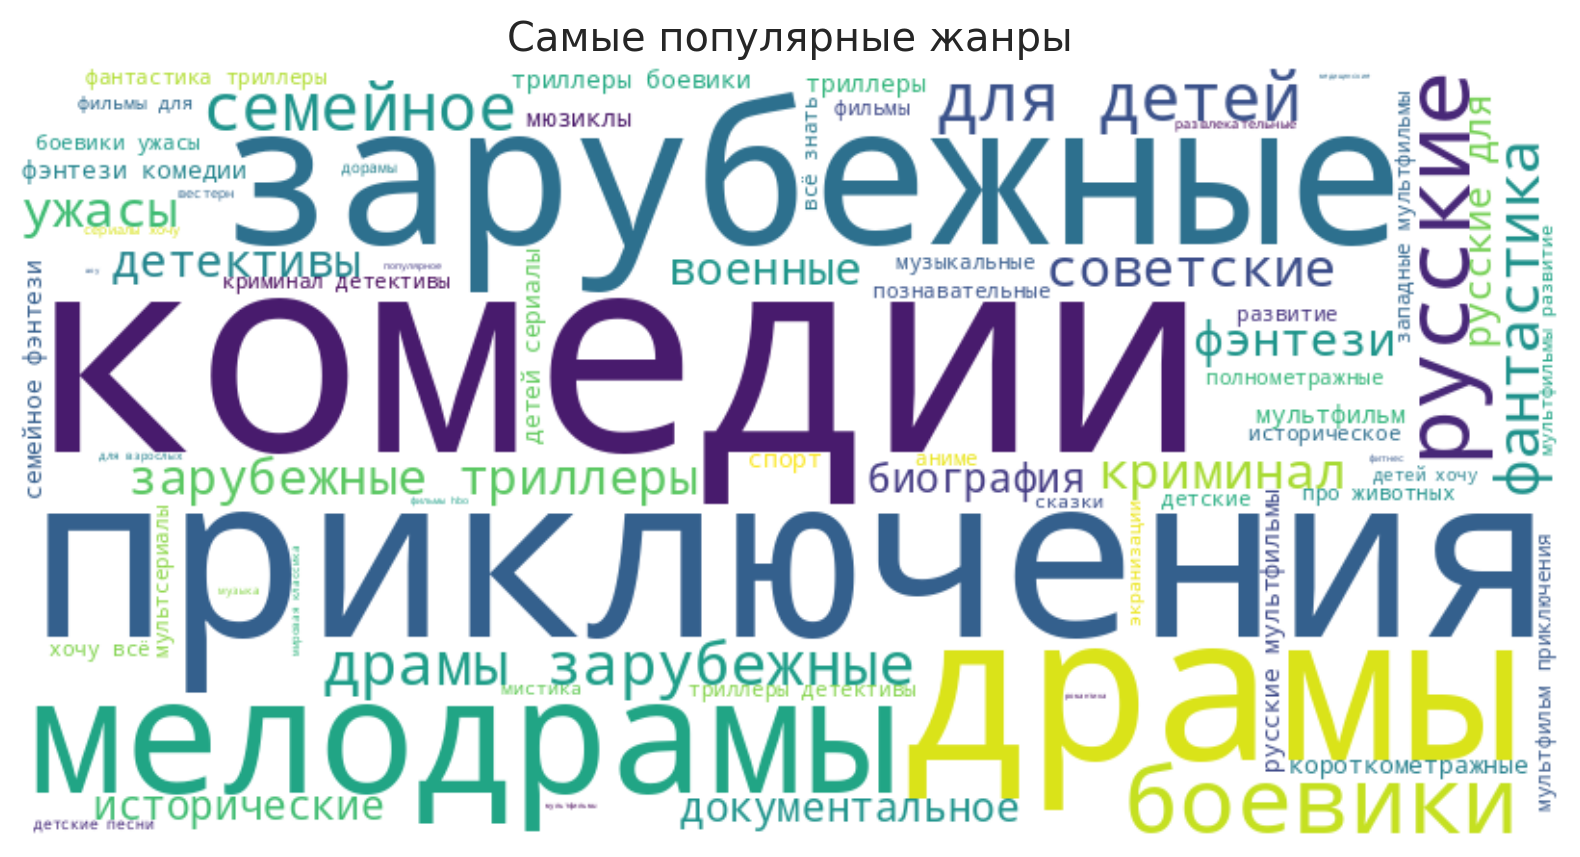

In [ ]:
plot_popular_genres(test_part, 'knn_recs', items_df)

Посмотрим также, какие страны лидируют по фильмам:

In [ ]:
from countries_transl import translations

In [ ]:
def plot_map(rec_type:str):
  first_items = pd.DataFrame([x[0] for x in test_part[rec_type].values], columns=["item_id"])
  country_recommendations = (first_items.merge(items_df[["item_id", "countries"]], on="item_id")
                   .groupby("countries").count().reset_index())
  country_recommendations['countries'] = country_recommendations['countries'].str.split(',').str[0]
  aggregated_recommendations = country_recommendations.groupby('countries')['item_id'].sum().reset_index()
  aggregated_recommendations['countries'] = aggregated_recommendations['countries'].map(translations)
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
  world = world[(world.pop_est > 0) & (world.name != "Antarctica")]
  world = world.merge(aggregated_recommendations, left_on='name', right_on='countries', how='left')

  world['item_id'] = world['item_id'].fillna(0)
  world['item_id'] = world['item_id'].apply(lambda x: 0 if x < 0.1 else np.log(x))


  fig, ax = plt.subplots(1, 1, figsize=(16, 7))
  world.plot(column='item_id', cmap='coolwarm', linewidth=0.6, ax=ax, edgecolor='0.8', legend=True)
  ax.set_title('Страны с наиболее рекомендуемыми фильмами')
  ax.axis('off')
  plt.show()


<ipython-input-320-b0a0e4ae5067>:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


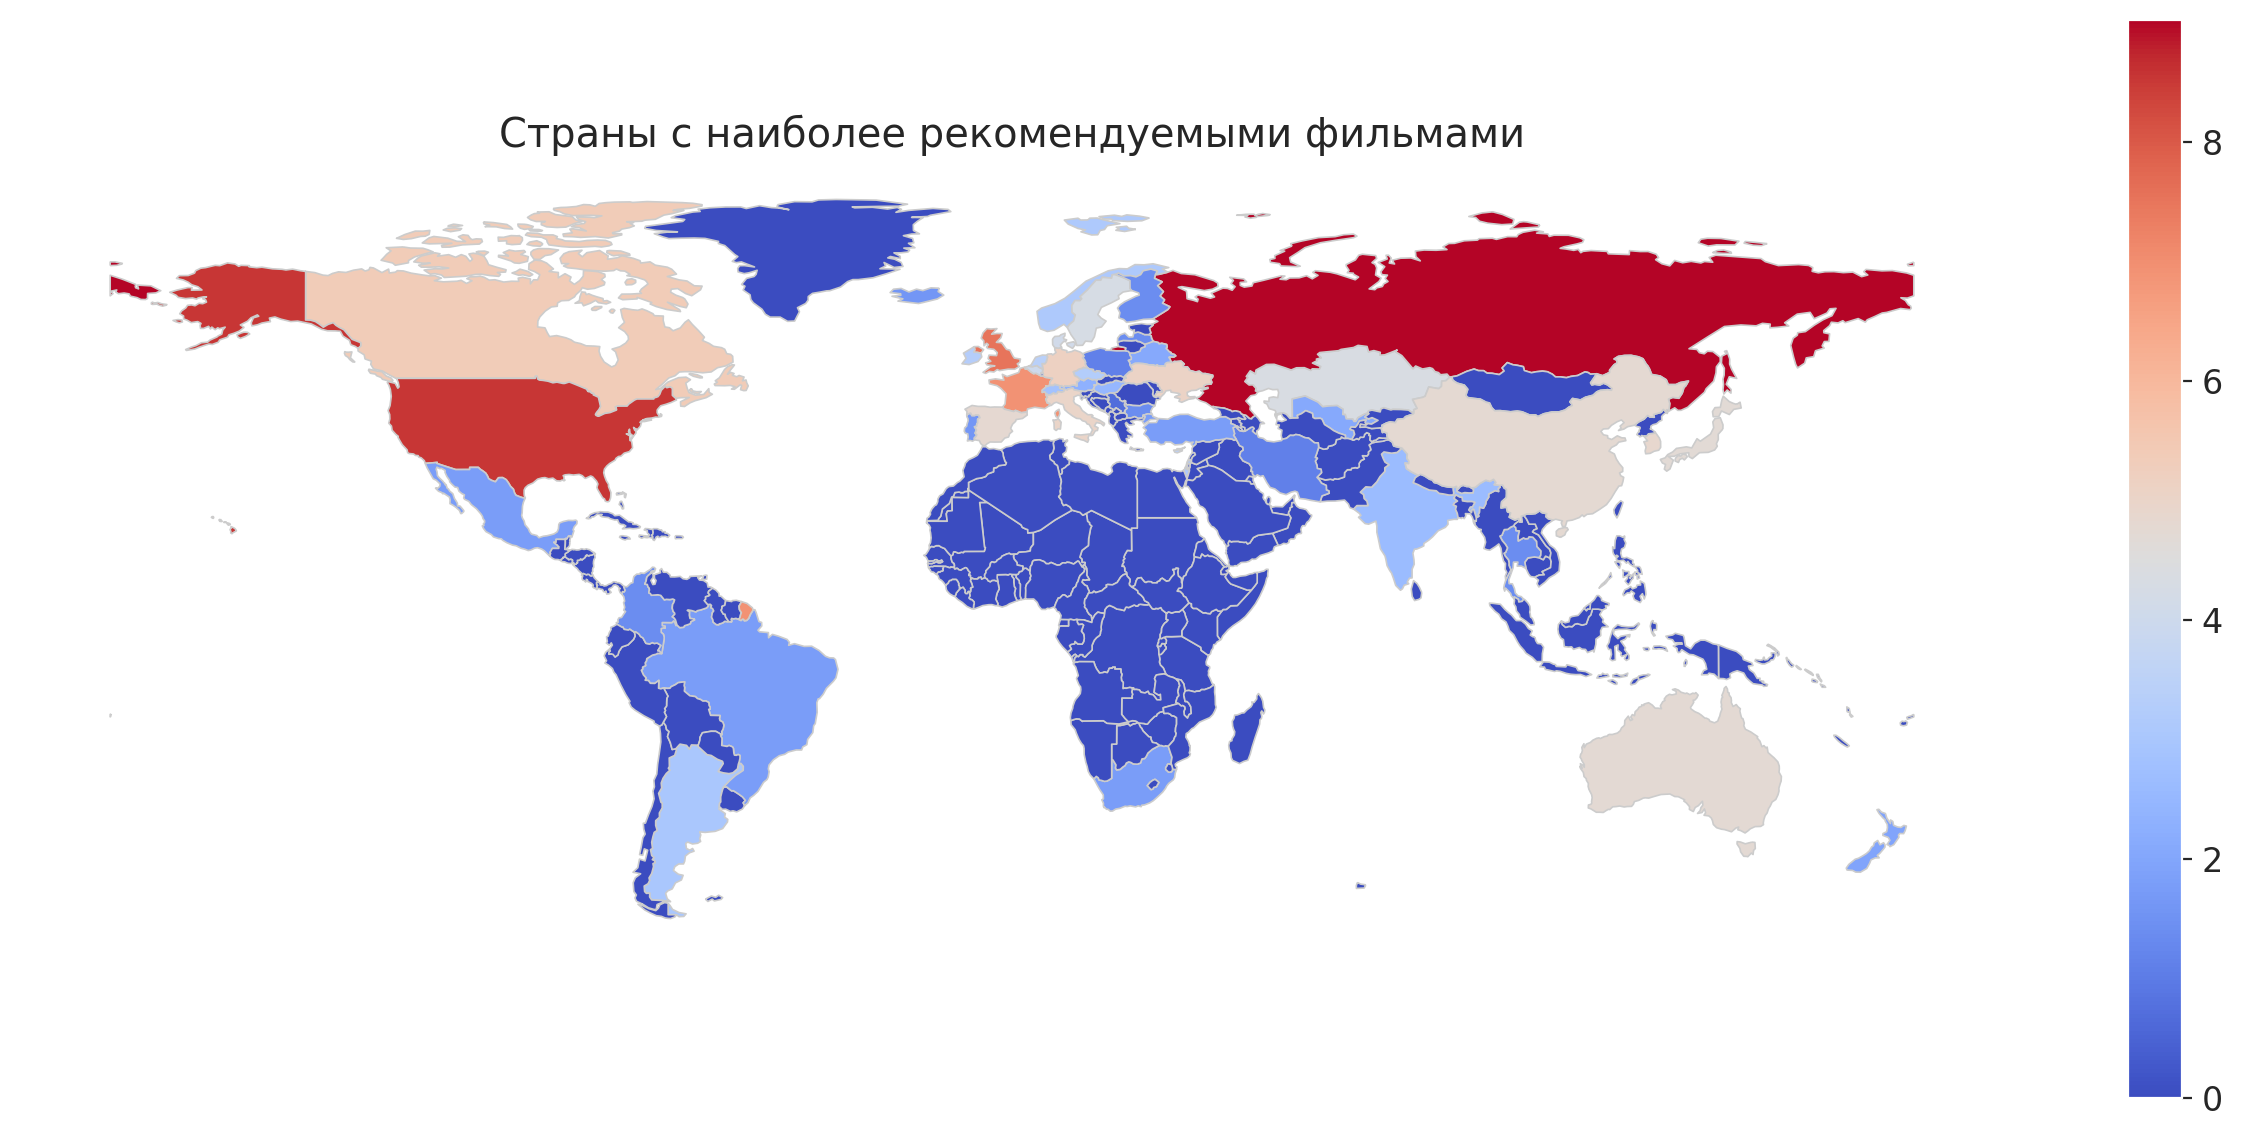

In [ ]:
plot_map("knn_recs")

## Light FM

In [ ]:
class Light_FM(BaseRecommender):
    def __init__(
        self, no_components: int = 16, learning_rate: float = 0.01,
        loss: str = 'warp', max_sampled: int=5) -> None:
        super().__init__()
        self.model = LightFM(no_components=no_components,
                             learning_rate=learning_rate, loss=loss,
                             max_sampled=max_sampled)
        self.trained = False

    def fit(self, train_df: pd.DataFrame, item_col: str = "item_id",
        user_col: str = "user_id", value_col: str = "watched_pct",
        num_epochs: int = 20) -> None:

        # Creating dataset
        self.lfm_dataset = Dataset()
        self.lfm_dataset.fit(train_df[user_col].unique(), train_df[item_col].unique())
        data = list(zip(train_df[user_col], train_df[item_col], train_df[value_col]))
        interactions_matrix, weights_matrix = self.lfm_dataset.build_interactions(data)
        self.weights_matrix_csr = weights_matrix.tocsr()

        # Mapping
        self.lightfm_mapping = {
            'users_mapping': self.lfm_dataset.mapping()[0],
            'items_mapping': self.lfm_dataset.mapping()[2]
        }
        self.lightfm_mapping['users_inv_mapping'] = {v: k for k, v in self.lightfm_mapping['users_mapping'].items()}
        self.lightfm_mapping['items_inv_mapping'] = {v: k for k, v in self.lightfm_mapping['items_mapping'].items()}

        # Fitting data
        for _ in tqdm(range(num_epochs)):
            self.model.fit_partial(self.weights_matrix_csr)

        self.trained = True


    def predict(self, df: pd.DataFrame, known_items: dict = {}, topn: int = 10):
        assert self.trained

        user_mapping = self.lightfm_mapping['users_mapping']
        item_inv_mapping = self.lightfm_mapping['items_inv_mapping']
        all_cols = list(self.lightfm_mapping['items_mapping'].values())

        def _recs_mapper(user):
            user_id = user_mapping[user]
            recs = self.model.predict(user_id, all_cols, num_threads=20)

            #additional_N = len(known_items.get(user_id, [])) if user_id in known_items else 0
            #total_N = topn + additional_N
            total_N = topn
            top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]

            final_recs = [item_inv_mapping[item] for item in top_cols]
            #if additional_N > 0:
            #    filter_items = known_items.get(user_id, [])
            #    final_recs = [item for item in final_recs if item not in filter_items]
            return final_recs[:topn]

        user_ids = df['user_id'].tolist()
        recs = [_recs_mapper(user_id) for user_id in user_ids]

        lfm_df = pd.DataFrame({'user_id': user_ids, 'lfm_rec': recs})

        return lfm_df

    def get_similar_films(self, title, N=10):
        item_id = items_df.loc[items_df["title"] == title, 'item_id'].values[0]

        similar_encoded_ids = self.model.similar_items(
            self.lightfm_mapping['items_mapping'][item_id], N=N, filter_items=self.lightfm_mapping['items_mapping'][item_id]
        )[0][0]
        similar_ids = self.lightfm_mapping['items_inv_mapping'][similar_encoded_ids]

        similar_films = items_df[items_df["item_id"].isin(similar_ids)][
            ["content_type", "title", "release_year", "genres", "countries", "directors", "age_rating"]]

        return similar_films

#### Валидация

Возьмем уже созданные для прошлой модели test и validation и продолжим валидировать на них уже LightFM. Я буду валидировать только два парметра: learning_rate и no_components, так как они показались мне наиболее важными. Так как перебирать вложенный цикл оказалось долго, я независимо проверю несколько значений для каждого из них  

In [ ]:
def evaluate_LightFM(train, validation):
    results_df = pd.DataFrame(columns=['nc', 'Score'])

    for nc in [8, 10, 16]:
      lfm_model = Light_FM(no_components=nc)
      lfm_model.fit(train)
      lfm_recs = lfm_model.predict(validation)

      validation["lfm_recs"] = lfm_recs['lfm_rec']
      score = evaluate_recommender(validation, model_preds_col="lfm_recs")

      results_df = results_df.append({'nc': nc, 'Score': score}, ignore_index=True)

    return results_df

In [ ]:
lfm_results = evaluate_LightFM(train, validation)

  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-331-517cbaa0694c>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'nc': nc, 'Score': score}, ignore_index=True)


  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-331-517cbaa0694c>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'nc': nc, 'Score': score}, ignore_index=True)


  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-331-517cbaa0694c>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'nc': nc, 'Score': score}, ignore_index=True)


In [ ]:
lfm_results

nc                                              Score
0   8  {'ndcg': 0.1833785416384604, 'recall': 0.15092...
1  10  {'ndcg': 0.18344423026962833, 'recall': 0.1508...
2  16  {'ndcg': 0.18161240643636234, 'recall': 0.1493...

In [ ]:
lfm_results

no_components                                              Score
0            16  {'ndcg': 0.16009172412522454, 'recall': 0.1313...
1            32  {'ndcg': 0.1529592227969899, 'recall': 0.12546...
2            64  {'ndcg': 0.14774738900855086, 'recall': 0.1211...

In [ ]:
lfm_results

lr                                              Score
0  0.010000  {'ndcg': 0.18102099470935148, 'recall': 0.1486...
1  0.073333  {'ndcg': 0.16203675428982786, 'recall': 0.1325...
2  0.136667  {'ndcg': 0.16022108520329575, 'recall': 0.1319...
3  0.200000  {'ndcg': 0.06422056504119031, 'recall': 0.0559...

#### Работа на тесте

Посмотрим, как работает модель с подобранными гиперпараметрами на тестовой выборке:

In [ ]:
lfm_model = Light_FM()

In [ ]:
lfm_model.fit(train_part)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
recs = lfm_model.predict(test_part)

In [ ]:
test_part["lfm_rec"] = recs["lfm_rec"]

In [ ]:
evaluate_recommender(test_part, "lfm_rec")

{'ndcg': 0.1742178935611927, 'recall': 0.07728353688566057}

#### EDA рекомендаций:

И вновь сравним полученные рекоммендации с топом популярных: совпало 5/10 фильмов. В целом, объем популярных фильмов вырос, несмотря на то, что их количество сократилось

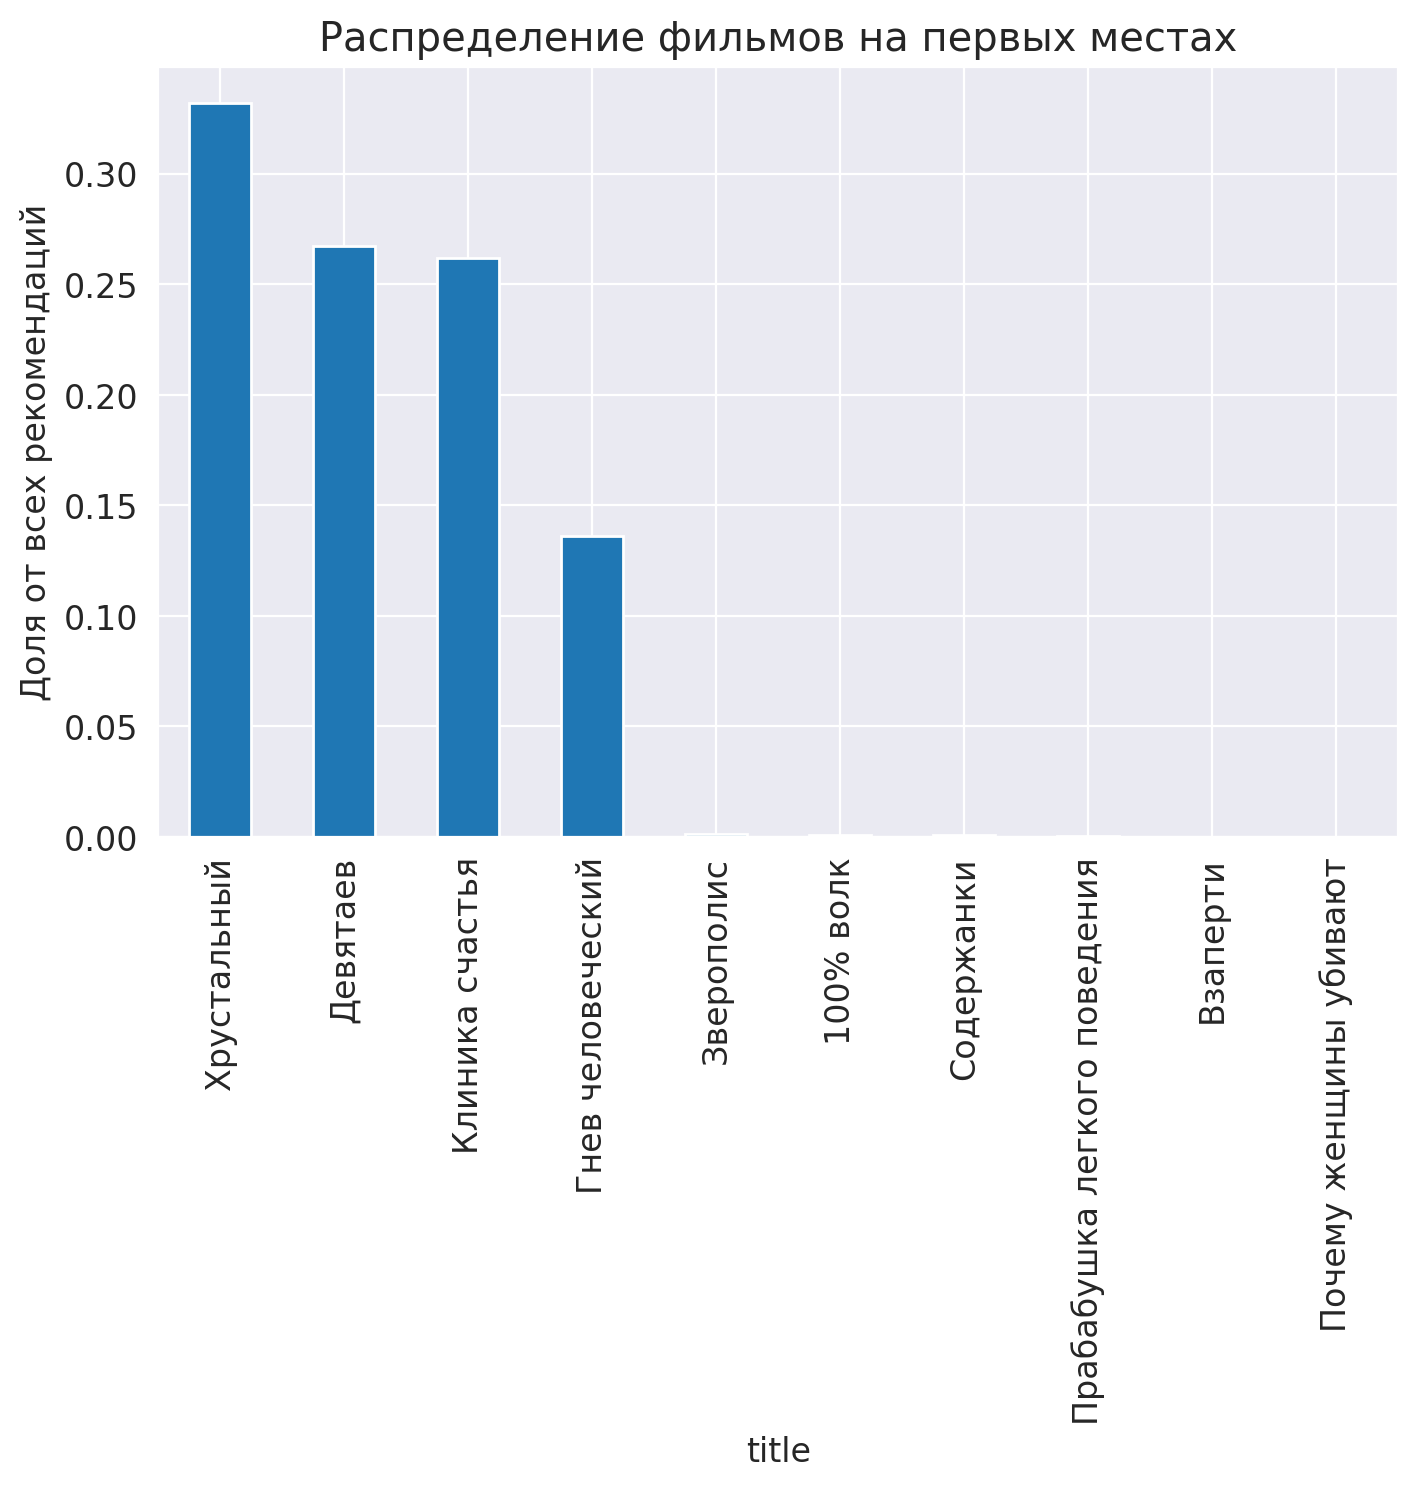

In [ ]:
plot_first_items(test_part, items_df, 'lfm_rec')

Вновь визуализируем самые популярные жанры:

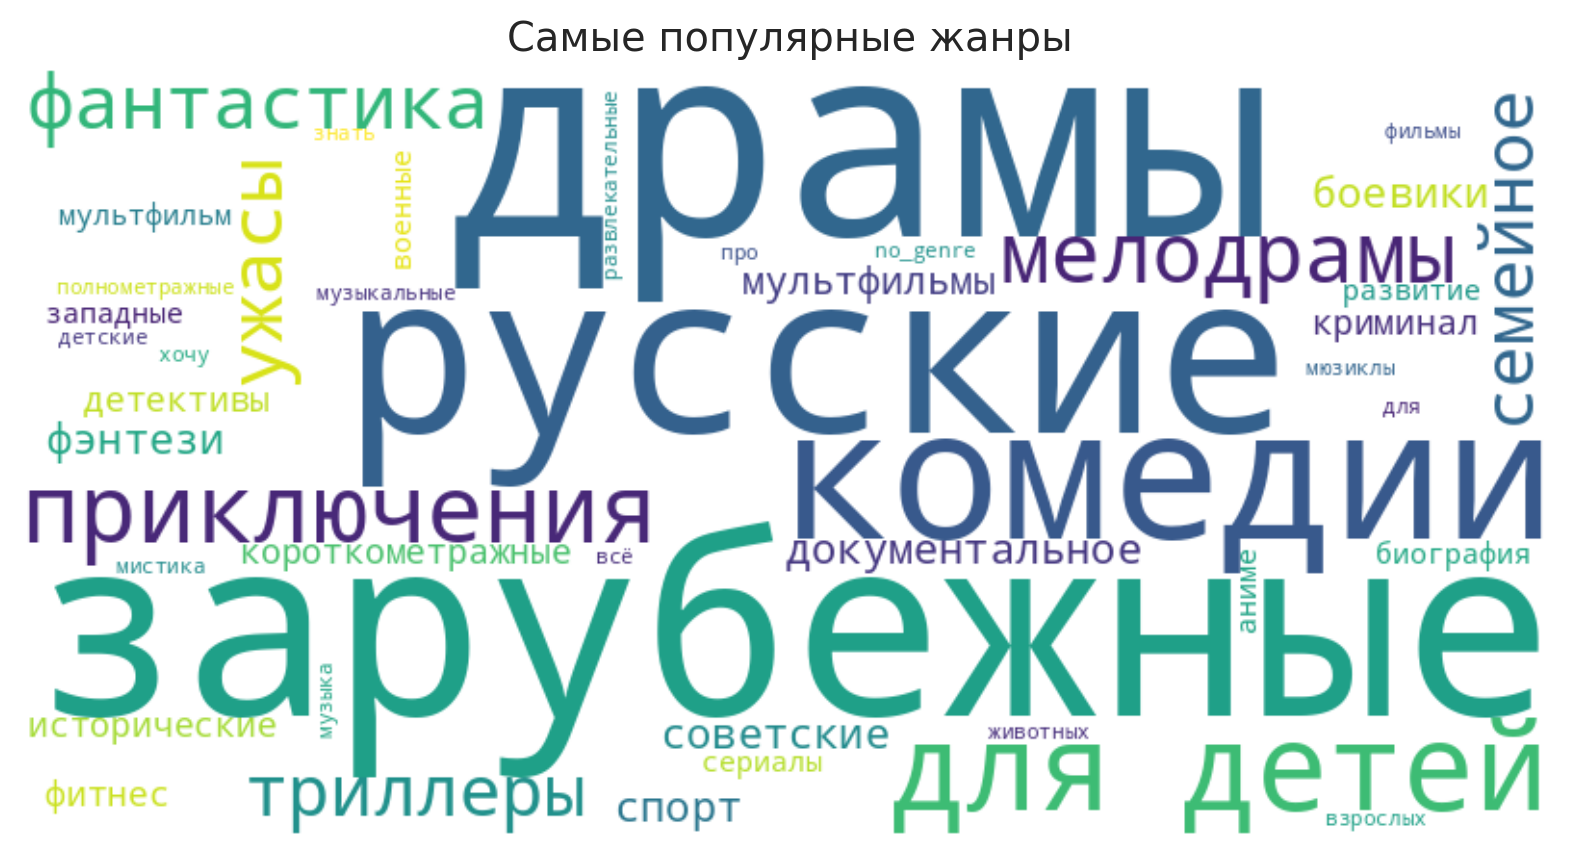

In [ ]:
plot_popular_genres(validation, 'lfm_recs', items_df)

Также посмотрим, какие страны лидируют в рекомендациях:

<ipython-input-316-cd348dd4e1f8>:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


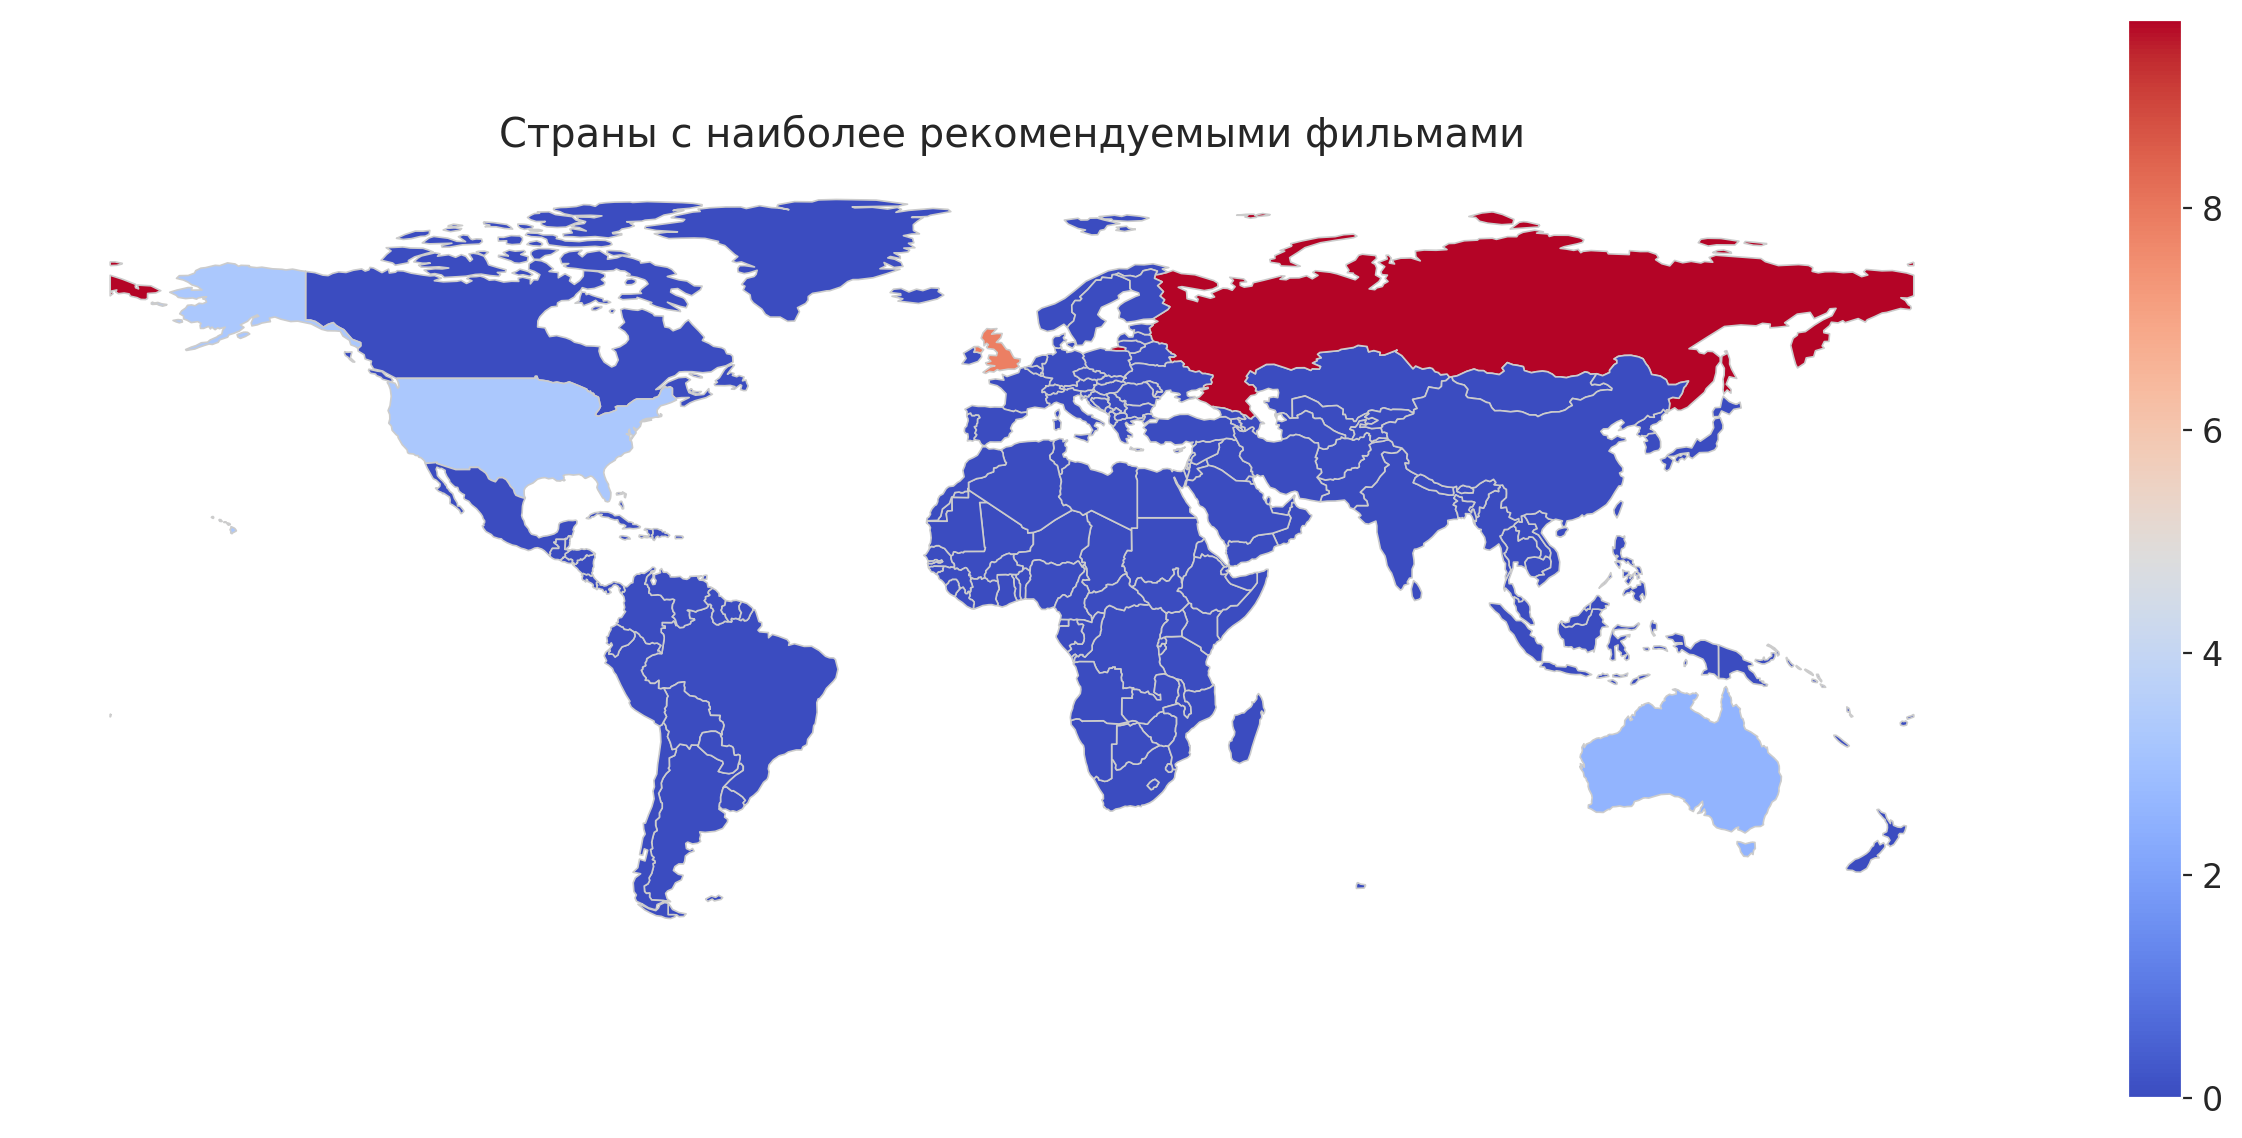

In [ ]:
plot_map('lfm_rec')

## Нейросеть

Нейросеть я сделать не успела, но обязательно хочу ее потом доделать для себя

# Итоги

# Так что же нужно сделать?

### tl;dr – красивые визуализации, креативные подходы, различные модели

**Мы не ставим перед вами задачу выбить лучший скор на тестовой выборке** (хотя это очень желательно), задание скорее в том, чтобы исследовать различные подходы, поискать инсайты в данных, построить красивый анализ своих предсказаний и поиграться с данными.

Если говорить более формально, то мы будем оценивать следующее:
1. Какие методы вы попробовали для решения задачи
   ##### Это могут быть
   * статистически подходы, основанные на вашем анализе данных
   * классические метрические методы, вроде knn, а как посчитать вектора пользователей – пусть уже ваша фантазия вам диктует. Здесь вам помогут item-based модели, вроде EASE или SLIM
   * затюненный или модифицированный ALS (ну или любая другая модель матричной факторизации)
   * классические модели вроде градиентных бустингов (catboost, lightGBM) тоже работают в таких задачах (вам ведь ничего не мешает учить классификатор на просмотренный и непросмотренный фильмы, правда? осталось только насэмплить вторых)
   * очень приветствуются (но не обязательны) DL подходы, например [DSSM](https://kishorepv.github.io/DSSM/), [NCF](https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401), [Bert4Rec](https://towardsdatascience.com/build-your-own-movie-recommender-system-using-bert4rec-92e4e34938c5) или [любой другой алгоритм](https://habr.com/ru/companies/prequel/articles/573880/), который вы найдете, например графовые или дифузионные подходы, почему нет)
     
   В общем нет никаких ограничений на модели, используйте то, что вам нравится или кажется логичным. Не стоит бросаться в крайности: обучать целый зоопарк моделей или затюнить одну до 0 ошибки. Найдите баланс между количеством и качеством)
2. Как хорошо вы валидировали свои модели
3. EDA (Exploration Data Analysis) данных, с которыми вы работаете
4. EDA полученных рекомендаций, насколько они разнообразные, насколько смещены в сторону популярных айтемов и всякое такое
5. **Обязательно** сохраните свою лучшую модель (файлик обученной модели), чтобы мы могли воспроизвести ваш результат!


## Помните:
1. Все дополнительные источники данных **обязательно** должны быть описаны
2. Нет правильного способа решить задачу. Не стоит беспокоиться, что вы делаете что-то неправильно. Мы хотим увидеть творческий подход и ваши способности к исследованию и прототипированию, а не какое-то конкретное решение задачи.
3. Вы можете использовать любые библиотеки и фреймворки, которые вам могут быть необходимы.
4. Сфокусируйтесь на том, чтобы код были чистый и понятный. Если вы считаете, что какая-то его часть может быть непонятна, то добавьте комментарии. Мы очень сильно ценим хорошо написанный код и выводы, поэтому если решение задачи будет оформлено грязно, то мы можем отклонить заявку.

## Результат
Мы ожидаем увидеть один или два (EDA + обучение моделей) ноутбук(а) на вашем [GitHub](https://github.com/) или ссылками на ваш [Google Colab](https://colab.research.google.com/?hl=ru).


Источники:
1. Курс ВШЭ по рекомендательным системам: http://wiki.cs.hse.ru/RecSys_2022_2023
2. Курс МТС: YourFirstRecsys, YourSecondRecsys : https://ods.ai/tracks/mts-recsys-df2020